In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Basic Python
from itertools import chain, groupby
from bisect import bisect_left
from heapq import heappush, heappop
from math import comb
from scipy import optimize

# Numerical Staff
import numpy as np
from scipy import optimize

# Ploting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

from Bio import SeqIO  # to read FASTA

# Custom functions that are not very informative to include in full
from utils.similarity import BLOSUM62, get_amino_freq
from utils.analysis import get_ladders_and_peaks, print_alignment
from utils.visualize import plot_path_graph, plot_alignment, plot_graph_alignment

In [3]:
# matplotlib default params
plt.rc('font', size=15)
plt.rc('figure', figsize=(6, 4), dpi=300)

# Database Search (BLAST)

## Why Sequences?

### Homology

Genetic sequence is the main substrate on which evolution acts thus sequence *similarity* provides evidence (under the appropriate model) that the compared genes share a common ancestor. 

![Thomas Shafee, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons](https://upload.wikimedia.org/wikipedia/commons/d/d8/Ortholog_paralog_analog_%28homologs%29.svg)

### Protein Function

Proteins are the key molecules in cellular biochemistry. They are composed by a sequence of amino-acids that fold to form a 3D structure.
The 3D structure of a protein determines its function by allowing it to interact or not with other molecules inside the cell.
There are strong evidence that the 1D string of amino-acid sequence determines the 3D structure of the protein and that this function/mapping is "continuous"
and thus similarity among sequences implies similarity of structure either in whole or in part.

Flow of information (the functions are non-injective, ie many sequences can give rise to the same structure):

$$ \text{sequence} \rhd_f \text{structure} \rhd \text{function} $$

Similarity of sequence implies similarity of structure:

$$d_{1D}\left(S_1, S_2\right) \lt \delta \Rightarrow 
  d_{3D}\left(f(S_1), f(S_2)\right) \lt \varepsilon $$

[Schneider & Sander (1991)](https://pubmed.ncbi.nlm.nih.gov/2017436/) and [Burkhard Rost (1999)](https://pubmed.ncbi.nlm.nih.gov/10195279/) showed that
the probability that highly similar proteins (>40%) are homologous is very high (>90%) and this relationship virtually disappear for dissimilar proteins (<20%) while in the middle there is a "twilight" zone.
A map of this boundary is shown below:

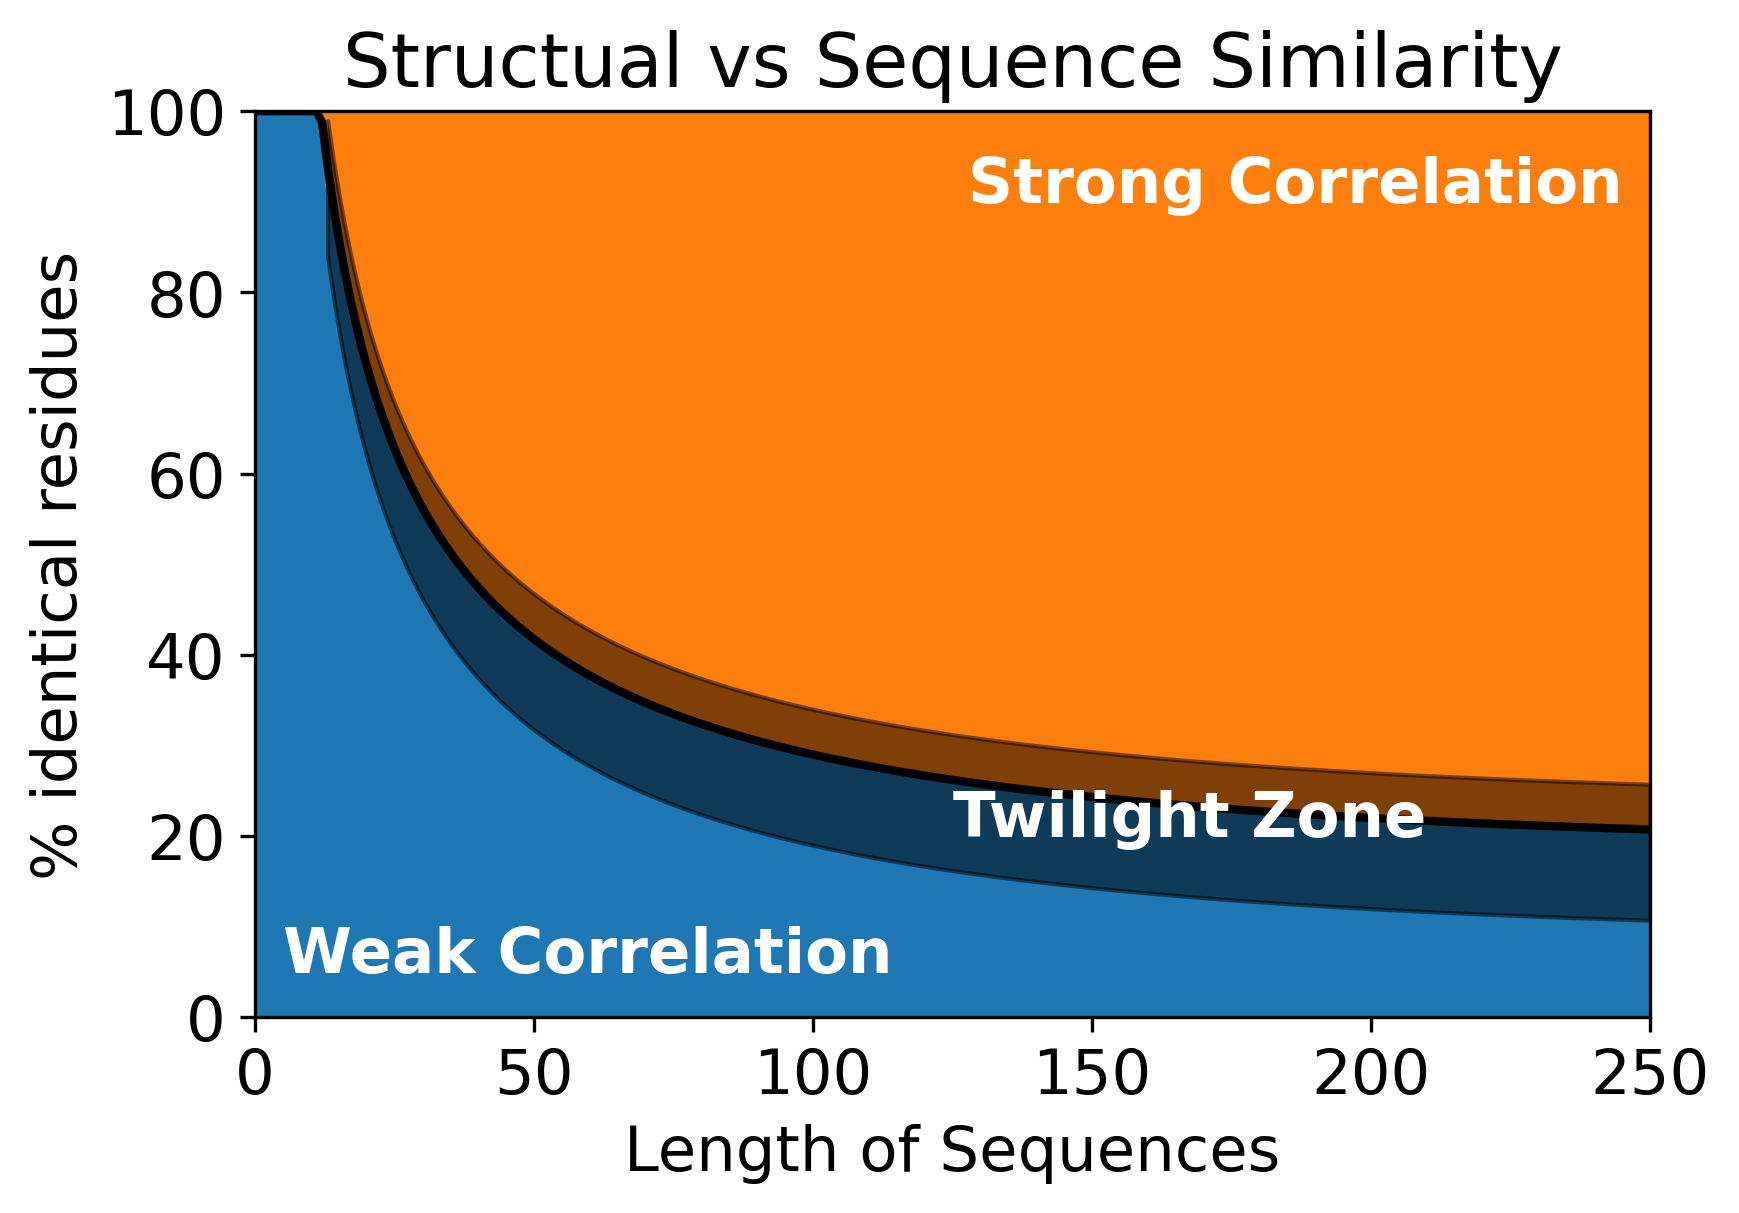

In [4]:
def hssp(L, n=0., mode='l'):
    # based on: https://www.rostlab.org/papers/1999_twilight/paper.html
    if mode == 'l':
        bounds = (11, 450)
        asymptote = (100., 19.5)
        scale = 480.
        rate = -0.32
        decay = 1000.
    elif mode == 's':
        bounds = (8, 650)
        asymptote = (100., 10.)
        scale = 420.
        rate = -0.335
        decay = 2000.
        
    if L <= bounds[0]:
        return asymptote[0]
    if L > bounds[1]:
        return asymptote[1]
    exponent = rate * (1. + np.exp(-L/decay))
    return n + scale * L**exponent

hssp = np.vectorize(hssp)

def plot_twilight(L, hssp):
    Lmin, Lmax = min(L), max(L)
    p = hssp(L, mode='l')
    fig, ax = plt.subplots()
    ax.plot(L, p, color='black', linewidth=2.)
    ax.fill_between(L, p, 0, color='C0')
    ax.fill_between(L, p, 100, color='C1')
    ip = p < 95.
    ax.fill_between(L[ip], p[ip]-10., p[ip]+5., color='black', alpha=.5)
    ax.text(Lmin+5., 5., 'Weak Correlation', {'color': 'white', 'weight': 'bold'})
    ax.text(Lmax-5., 90., 'Strong Correlation', {'color': 'white', 'weight': 'bold', 'ha': 'right'})
    ax.text((Lmax-Lmin)/2, 20., 'Twilight Zone', {'color': 'white', 'weight': 'bold'})
    ax.set_xlim(0, L[-1])
    ax.set_ylim(0, 100)
    ax.set_xlabel('Length of Sequences')
    ax.set_ylabel('% identical residues')
    ax.set_title('Structual vs Sequence Similarity')
    plt.show()

plot_twilight(np.arange(251), hssp)

Given this close connection between sequence similarity and structure, a reasonable strategy to characterize a novel sequence is to look for *similar* sequences (or sub-sequences) in a database of proteins with known structure/function and thus try to characterize its different parts.

### Read Mapping

In the context of genomics, reads (sequences) are the primary data type. To endow reads with coordinates, we have to map them to a reference genome by comparing their sequence with sub-sequences of it. Exact matching is not applicable in this case because:

1. Sequences are corrupted by experimental noise
2. We only have a *generic* reference genome not the one that generated
   the reads.

Thus we have to settle for *"similar"* sequences.

Searching for a *pattern* is a large corpus of *text* (either a genome or all known proteins) is a classic CS problem, namely string matching. There are many variations of the problem for different applications. Here, we are going to focus in BLAST one of Bioinformatics most celebrated algorithms.


## Edit Distance

What do we mean by *similarity* or conversely *distance*?

Formally, a distance metric is a function that takes 2 inputs and returns a non-negative real number that obeys the 3 axioms:

$$d: S \times S \to \mathbb{R}^+$$

1. *Identity of indiscrimables*: $d(x,x) = 0$
2. *Symmetry*: $d(x, y) = d(y, x)$
3. *Triangle Inequality*: $d(x, z) \le d(x, y) + d(y, z)$


Inputs in our case are strings $S$ composed of sequence of "letters" drawn from an alphabet $\Sigma$ (the 20 amino-acids or 4 nucleotides usually). Thus we write a sequence of length $n$ as $S = s_1 s_2 \dots s_n$

There is no single/natural metric to compare sequences. 
We have to come up with appropriate metrics for the task at hand, whether that is to estimate the homology between proteins, finding highly conserved features, or mapping reads to a genome. We also have to take into account practical considerations, for example we have to able to compute it quickly.

A common choice is the family of *edit distances*. 
Edit distances are based on an implied model that can morph one sequence into another using a fixed set of operations. The smallest (weighted) sum of all the operations required to achieved that is distance between the 2 sequences.
Some typical examples are:

1. **Hamming** distance: only <span style='color:#DF536B'> substitutions </span> are allowed
2. Longest common sub-sequence (**LCS**): only <span style='color:#2297E6'> insertions/deletions </span> are allowed
3. **Levenshtein** distance: both <span style='color:#DF536B'> substitutions </span> and <span style='color:#2297E6'> insertions/deletions </span> are
   allowed

![Adapted from doi:10.1017/S0016672306228258](figures/edit_operations.svg)

### Sequence Alignment

Computing the Hamming distance is the easiest of the 3. Originally, the Hamming distance is defined between 2 sequences of the *same length* as the number of characters that differ. So we just have to scan the strings and count their differences like so:

```
sum(x != y for x, y in zip(S1, S2))
```

However, we would like to be able to compare distances between sequences of unequal length. To do so, we extend the definition as follows:

- Define an extra "gap" character `-`
- Pad the shortest sequence with gaps until it matches the length of the longer.
- Count the number of differences between the *extended* sequences

An implementation of this distance is shown below:

In [5]:
def hamming(S0, S1):
    L = len(S0), len(S1)
    if L[0] == L[1]:
        return sum(x != y for x, y in zip(S0, S1))
    if L[0] < L[1]:
        S0, S1 = S1, S0  # reverse so that S0 is longer (distance is symmetric)
        padding = '-' * (L[1] - L[0])
    else:
        padding = '-' * (L[0] - L[1])
    
    pref = hamming(S0, padding + S1)  # pad at the begining
    suff = hamming(S0, S1 + padding)  # pad at the end
    return min(pref, suff)  # distance is defined as the shortest path from S0 -> S1

hamming('BANANA', 'BANA')
# BANANA vs BANANA
# --BANA    BANA--

2

We see that there is a choice to be made. 
We can pad at the beginning or we can pad at the end.
Because distance is defined as the *shortest path* between 2 sequences we have to chose the `min` of the 2 options.

This example illustrates that to compute the distance between 2 sequences,
we have to find the **optimal alignment** between them, ie where to put the gaps in one or the other so that we can them compare them character-wise and calculate. In the `hamming` case that was relatively easy but once we allow gaps to mix with character then the task become significantly harder.

In [6]:
dHamm = hamming('MISSISSIPI', 'MISISSIPI')
dLeve = hamming('MISSISSIPI', 'MIS-ISSIPI')

In [7]:
print(f'Hamming = {dHamm} | Levensthein = {dLeve}')
print('------------|----------------')
print('MISSISSIPI  |   MISSISSIPI')
print('-MISISSIPI  |   MIS-ISSIPI')

Hamming = 3 | Levensthein = 1
------------|----------------
MISSISSIPI  |   MISSISSIPI
-MISISSIPI  |   MIS-ISSIPI


Mixing gaps with characters gives rise to the following concepts:

- Given a sequence $S$, an *extended* sequence $S'$ is an arbitrary extension of $S$ with gap
  symbols "-". The gap symbols can go anywhere in the sequence not just beginning and end.
- A **global alignment** of 2 sequences $S$ and $Q$ is a 1-1 correspondence of their extended
  sequences $S'$ and $Q'$. The correspondence must be *co-linear* (no permutations of the 
  letters is allowed) and have no pairs of gaps aligned to each other.
- A **local alignment** is similar to a global one but it doesn't have to use the whole sequence 
  $S'$ and $Q'$ just contiguous segment of theirs.

The hamming distance we defined above performed a global alignment, but if we were interested if finding parts of the 2 sequences that have strong similarity (so as to characterize parts of one 
vs the other) then we would want to perform a local alignment.

Without loss of generality, we denote one sequence to be the "subject" $S$ and one to be the "query" $Q$. An edit distance needs to transform $Q \rightarrow S$. Given an alignment we can immediately read which operations are required. In particular a position of the alignment corresponds to:

- **Substitution**: if both sequences have a non-gap symbol there (we consider letters mapping to themselves as trivial substitutions)
- **Insertion**: if the $S'$ sequence has a gap. $Q$ has an extra symbols "inserted" at this position.
- **Deletion**: if the $Q'$ sequence has a gap. $Q$ has a symbol "deleted" at this position

Finding the optimal alignment that would allow us to compute the distance of 2 sequences is going to be the main task today.

### Distance vs Similarity

Not all substitutions are created equal.
Amino-acids are characterized by different physiochemical properties (polarity, charge, hydrophylicity). Substitutions that switch amino-acids with different properties are expected to have a greater impact on a protein's structure. Likewise, not all nucleotides substitutions (mutations) have the same effect or are as common, for example transitions vs transversions. Thus we would like to penalize substitutions differently. 


Amino Acids | Nucleotides
- | - 
![Amino Acid by property](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Amino_Acids.svg/389px-Amino_Acids.svg.png) | ![transition_vs_transversion](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/All_transitions_and_transversions.svg/501px-All_transitions_and_transversions.svg.png)

If we use different penalties for different substitutions we are not guaranteed to have a proper distance functions. However, that is a sacrifice worth making usually. Consequently, it is better if we drop the term "distance" and use the term "similarity", which carries less baggage and "gains" instead of "penalties".

So our goal is given 2 sequences to find either the global or local alignment the *maximizes the similarity metric* based on a predefined scoring scheme that is described by a **substitution matrix** and a **gap penalty**. 

For amino acid substitutions there are families like PAM and BLOSUM of matrices based on protein homology while for nucleotide sequences, we will either use a uniform scoring (match vs mismatch) or one that distinguishes between transition vs transversion. Below we show the substitution matrices that are going to use for this lecture.

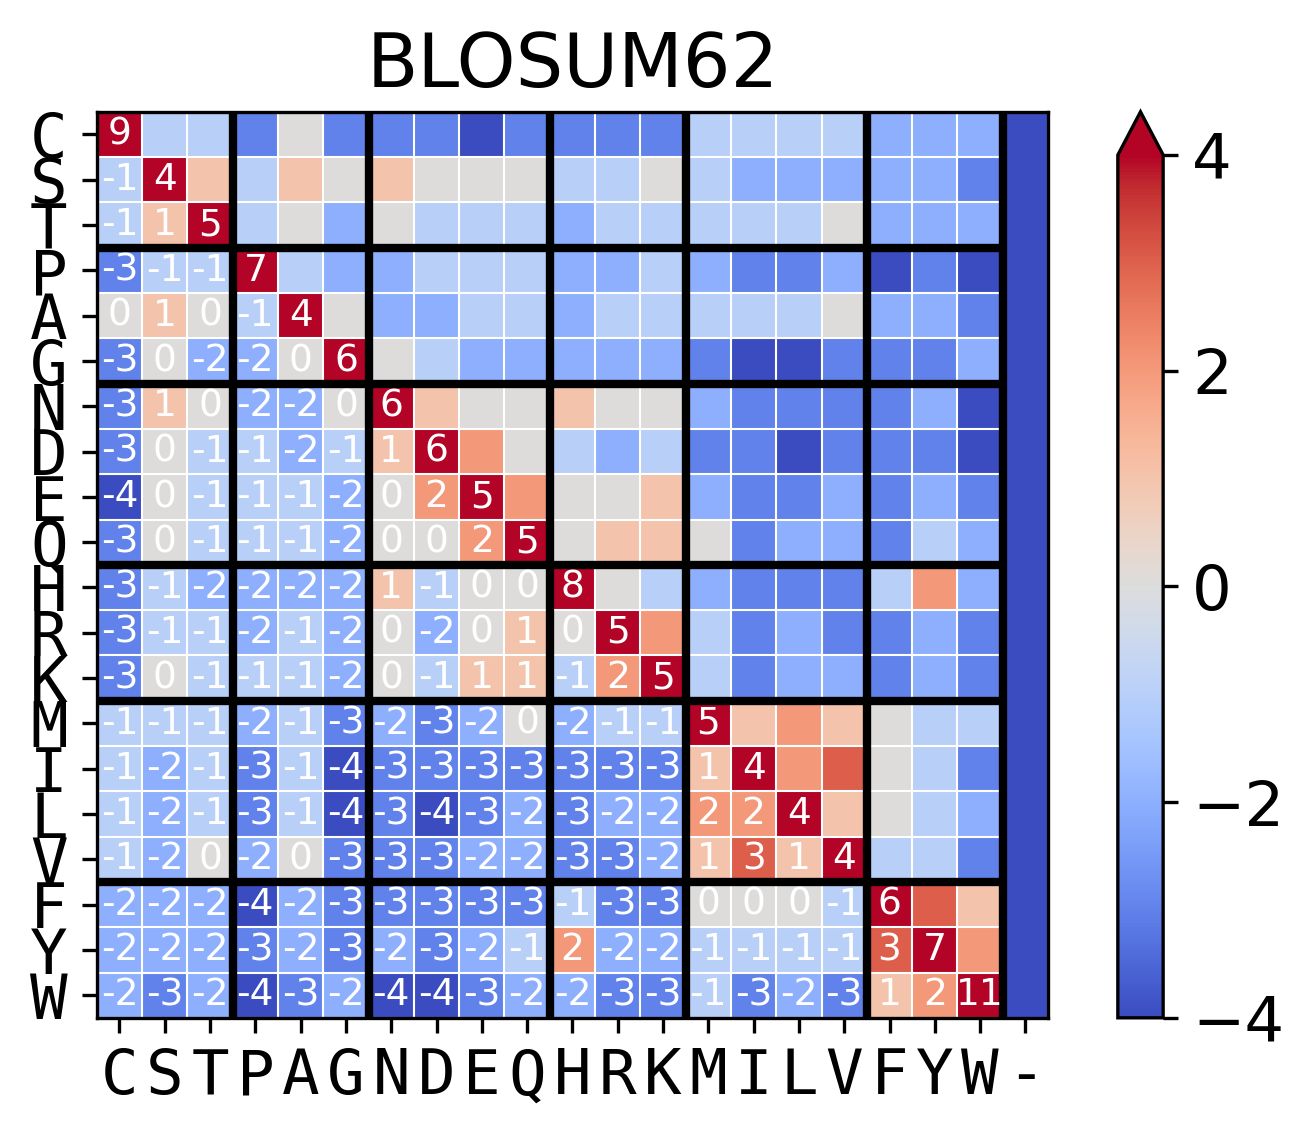

In [8]:
BLOSUM62.alphabet = 'CSTPAGNDEQHRKMILVFYW'
mat = BLOSUM62.to_array()
mat = np.hstack([mat, BLOSUM62.gap * np.ones((20, 1), dtype=int)])
plt.imshow(mat, norm=colors.CenteredNorm(halfrange=4), cmap='coolwarm')
plt.hlines(np.arange(20)+.5, -.5, 19.5, color='white', lw=.5)
plt.vlines(np.arange(21)+.5, -.5, 19.5, color='white', lw=.5)
plt.hlines(np.asarray([2, 5, 9, 12, 16]) + .5, -.5, 19.5, color='black', lw=2.)
plt.vlines(np.asarray([2, 5, 9, 12, 16, 19]) + .5, -.5, 19.5, color='black', lw=2.)
plt.xticks(np.arange(21), BLOSUM62.alphabet + '-', family='monospace')
plt.yticks(np.arange(20), BLOSUM62.alphabet, family='monospace')
plt.colorbar(extend='max')
for i in range(len(BLOSUM62.alphabet)):
    for j in range(len(BLOSUM62.alphabet)-i):
        plt.text(i, i+j, mat[i+j,i], size=9, ha='center', va='center', color='w')
plt.title('BLOSUM62')
plt.show()

Based on this we can redefine the `hamming` function to calculate similarity

In [9]:
def hamming(S0, S1, M):
    L = len(S0), len(S1)
    if L[0] == L[1]:
        return sum(M[x, y] for x, y in zip(S0, S1))  # score given by matrix M
    if L[0] < L[1]:
        S0, S1 = S1, S0
        padding = '-' * (L[1] - L[0])
    else:
        padding = '-' * (L[0] - L[1])
    
    pref = hamming(S0, padding + S1, M) 
    suff = hamming(S0, S1 + padding, M)
    return max(pref, suff)  # max instead of min

hamming('PANAMA', 'PAMA', BLOSUM62)
# PANAMA vs PANANA
# --PAMA    PAMA--

5

## Dot Plot 

The [dot-plot](https://doi.org/10.1111/j.1432-1033.1970.tb01046.x) (or dot-matrix) is a visual representation of *all possible local alignments between 2 sequences*. To construct a dot-plot the 2 sequences are arranged in a 2D grid to define a lattice and every node corresponding to a symbol pair is filled in based on their similarity score. Below is a very basic implementation of this idea.


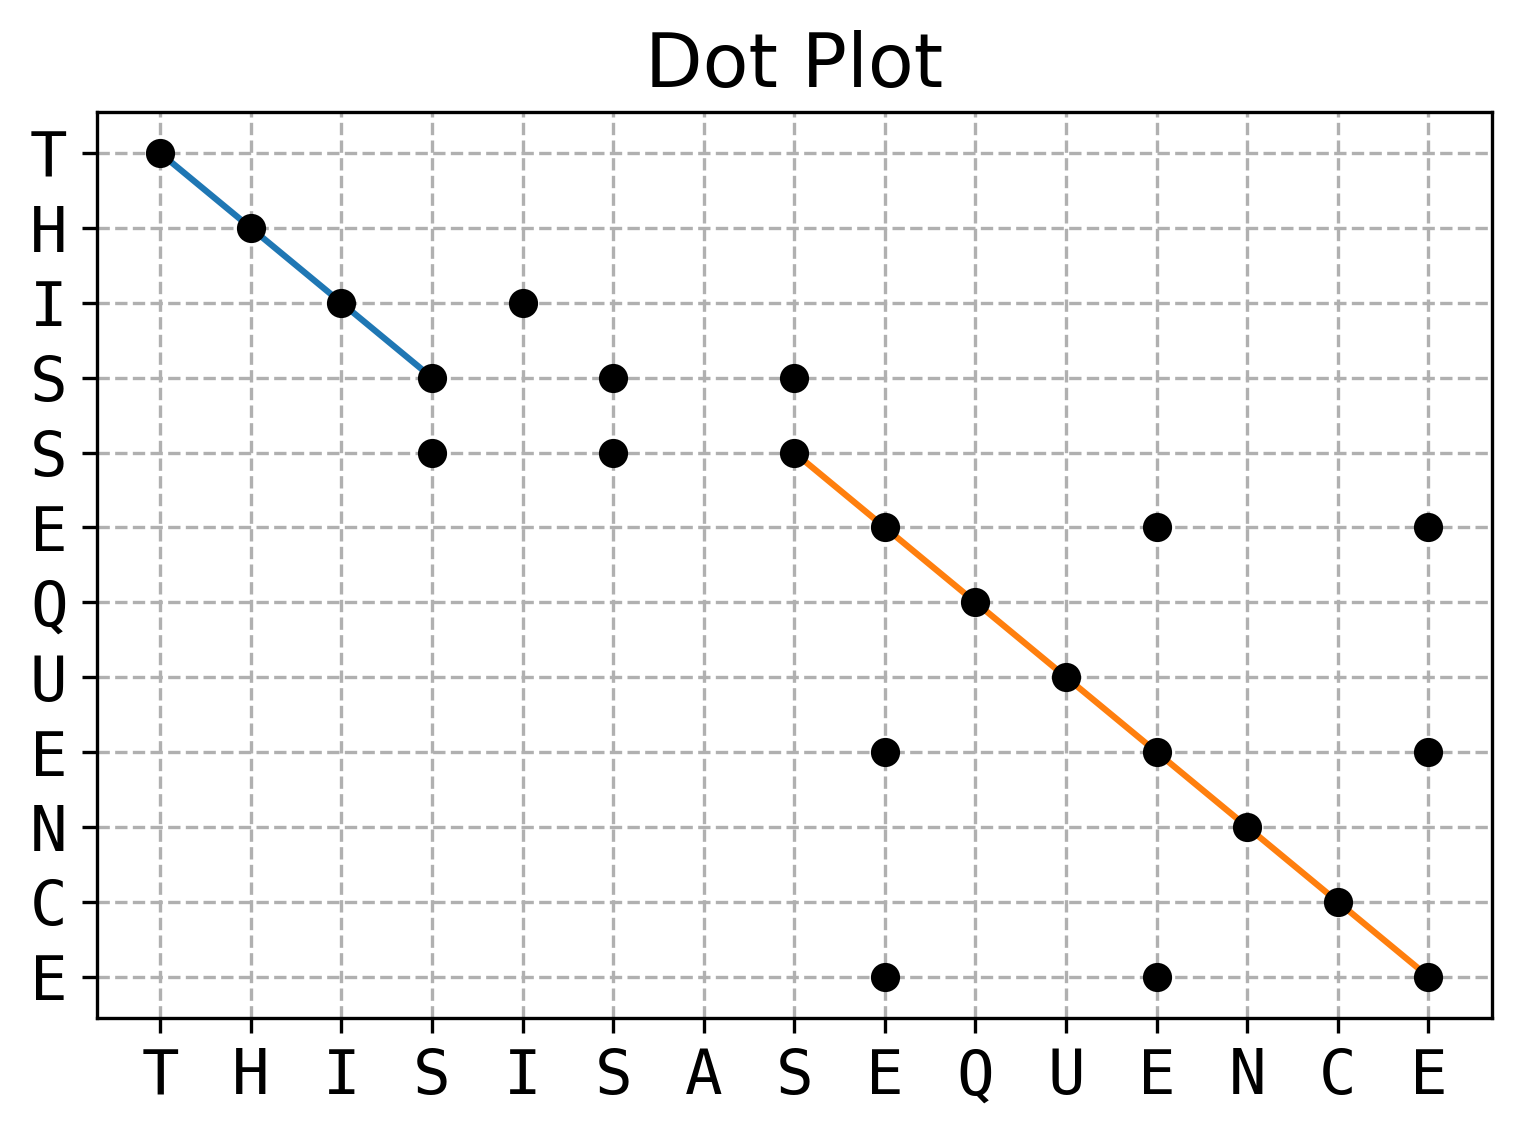

In [10]:
def dot_plot(S, Q=None):
    if Q is None:
        Q = S
    dots = [(i, j) for i, s in enumerate(S) for j, q in enumerate(Q) if s == q]
    return zip(*dots)  # return x & y seperately

S, Q = 'THISISASEQUENCE', 'THISSEQUENCE'  # from Understanding Bioinformatics
x, y = map(np.asarray, dot_plot(S, Q))
plt.plot(np.arange(4), len(Q) - np.arange(4))
plt.plot(np.arange(7, len(S)), 3+len(Q) - np.arange(7, len(S)))
plt.plot(x, len(Q)-y, 'o', color='black')  # reverse y to have top-down direction
plt.xticks(np.arange(len(S)), S, family='monospace')
plt.yticks(len(Q)-np.arange(len(Q)), Q, family='monospace')
plt.grid(ls = '--')
plt.title('Dot Plot')
plt.show()

The dot plot can visualize several important features of the alignment.
The most important feature is the diagonal segments that appear which correspond to local alignments of high similarity. In the example given, `THIS` and `SEQUENCE` are common "features" of the 2 sentences and thus appear as diagonals in the dot-plot. The original `BLAST` software was designed to identify these highly similar diagonals.

We can even align a sequence with itself. Self-aligning dot-plots are obviously symmetric and have a strong main diagonal but they also highlight features like repeats, that appear as parallel diagonals (separated by the number of symbols separating the repeating segments) and palindromes (inversions) that appear as anti-diagonals.

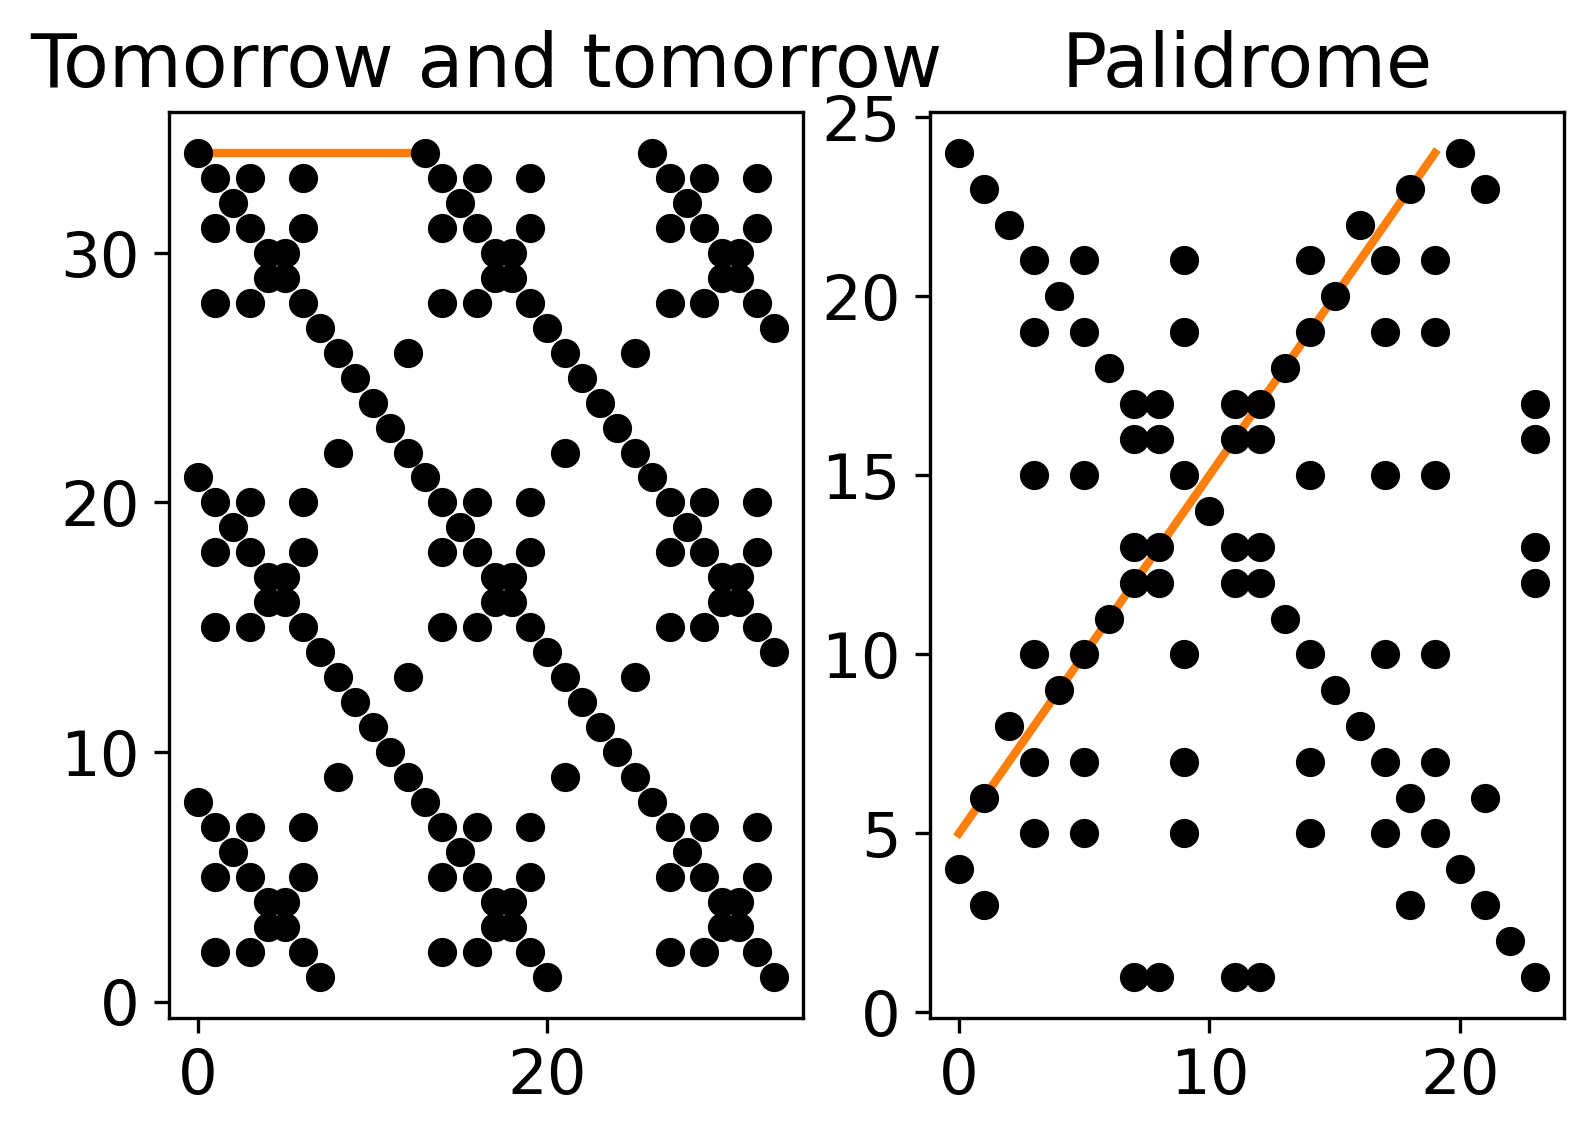

In [11]:
fig, ax = plt.subplots(1, 2)

S = 'tomorrow and tomorrow and tomorrow'
#   '------14------
l = 13
x, y = map(np.asarray, dot_plot(S))
ax[0].plot([0, l], [len(S), len(S)], color='C1', lw=2.)
ax[0].plot(x, len(S)-y, 'o', color='black')
ax[0].set_title('Tomorrow and tomorrow')

S = 'can i see bees in a cave'
#   '---------20----------
l = 20
x, y = map(np.asarray, dot_plot(S))
ax[1].plot(np.arange(l), np.arange(l) + len(S) - l + 1, color='C1', lw=2.)
ax[1].plot(x, len(S)-y, 'o', color='black')
ax[1].set_title('Palidrome')

plt.show()

Below we show a more realistic example, the $\alpha$-chain of haptoglobin which has a repeating sequence starting in positions 10 and 69.

We also rewrite the function as matrix and use the `BLOSUM62` matrix to score the similarity instead of the naive identity we will also drop negative values as we are only interested in positive similarity.

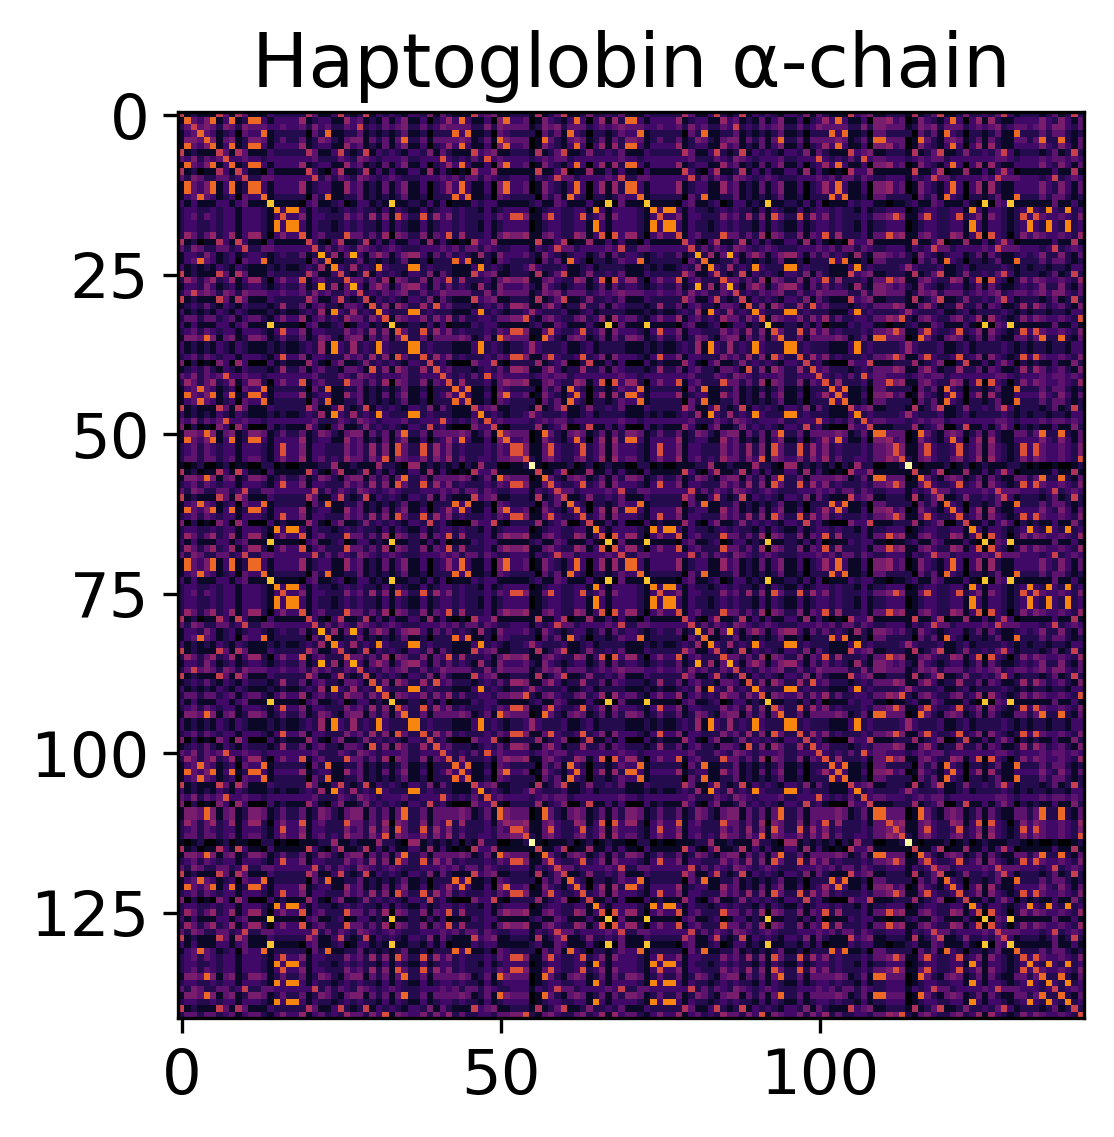

In [12]:
def dot_matrix(X, M, Y=None):
    if Y is None:
        Y = X
    dot = np.zeros((len(X), len(Y)), dtype=int)
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            dot[i, j] = M[x, y]
    return dot

# Example from: https://doi.org/10.1111/j.1432-1033.1970.tb01046.x
# >sp|P00738|19-160
HP_alpha_chain = 'VDSGNDVTDIADDGCPKPPEIAHGYVEHSVRYQCKNYYKLRTEGDGVYTLNDKKQWINKAVGDKLPECEADDGCPKPPEIAHGYVEHSVRYQCKNYYKLRTEGDGVYTLNNEKQWINKAVGDKLPECEAVCGKPKNPANPVQ'
plt.imshow(dot_matrix(HP_alpha_chain, M=BLOSUM62), cmap='inferno')
plt.title('Haptoglobin α-chain')
plt.show()

We can clearly see the replicated sequences as parallel diagonals but the matrix is fairly noisy. To clean it up we are going to use ideas from coding theory, filtering and redundancy.

<!-- TODO: make it more textual and less like a transcription -->

The idea of filtering is simple to understand, there is a cutoff value under which every value zeroed out and the rest are maintained. Filters trade-off noise (variance) for bias based on the assumption that the "signal" (true alignment in our case) is significantly stronger than the noise.

Redundancy is a bit more tricky...
We can think of the process of constructing the dot-matrix as follows. We have a template `Y` and somebody is feeding us a new sequence `X` that hopefully is related to our template and we try to locate (align) it in `Y`. To help us we have a scoring matrix `M` that tells us how likely it is for letter `x` to match to position `j` (through `M(x, y=Y[j])`). However, this information is not enough to unambiguously map it for 2 main reasons. Either noise has corrupted the signal (eg in the form of mutations) or, even if we align a sequence against itself, because our alphabet $\Sigma$ is finite and thus we are "forced" to reuse the same letter at different position of `X` and `Y`. If the alphabet was huge Nature could have used a different letter for every protein and aligning them would have been trivial as each amino-acid would be unique. However, we (and Nature) can expand the alphabet artificially by combining string of letters into "words". In particular, we (but not necessarily Nature) can treat a group of `k` letters as a word (`k-mer`) thus expand our vocabulary exponentially from $\Sigma$ possible letters to $\Sigma^k$ words.

If we assume that every letter has a frequency of appearance in our template $p_a$, for every $a \in \Sigma$, then the amount of *information* we get about its positions is inversely proportional to $p_a$ in particular we say that the letter gives us $\log_2 \frac{1}{p_a}$ *bits of information*. If we then use words instead of letters, the probability of a word appearing in our template is given by $\prod_i^k p_{s_i}$ (if we assume no correlations among the letters) and thus definitely less likely than the probability of a letter ($p \le 1$) and thus more informative. 

The size of `k` trades-off specificity for sensitivity. Larger values gives us extra confidence that the sequence we picked up is correctly located but we are sacrificing our ability to find smaller sequences (Nature is not constrained to use a fixed k) and also increase the risk of not finding the word in our template. We can also see treat `k` as trading off bias for variance. Larger values of `k` makes the words less sensitive to noise (less variance) but at the cost limiting our target group (more bias) to k-mers that may be unique to our template.

Below we implement this word search and also introduce a user-specified threshold.

In [13]:
def iter_words(text, k):
    L = len(text) - k + 1
    for i in range(L):
        yield text[i:i+k]

text = 'MISSISSIPI'
k = 3
for i, word in enumerate(iter_words(text, k)):
    print(' '*i + word)
print(text)

MIS
 ISS
  SSI
   SIS
    ISS
     SSI
      SIP
       IPI
MISSISSIPI


In [14]:
def dot_matrix(X, M, Y=None, k=1, T=0):
    if Y is None:
        Y = X
    dot = np.zeros((len(X), len(Y)), dtype=int)
    for i, x in enumerate(iter_words(X, k)):
        for j, y in enumerate(iter_words(Y, k)):
            dot[i, j] = M(x, y)
    dot[dot < T] = 0
    return dot

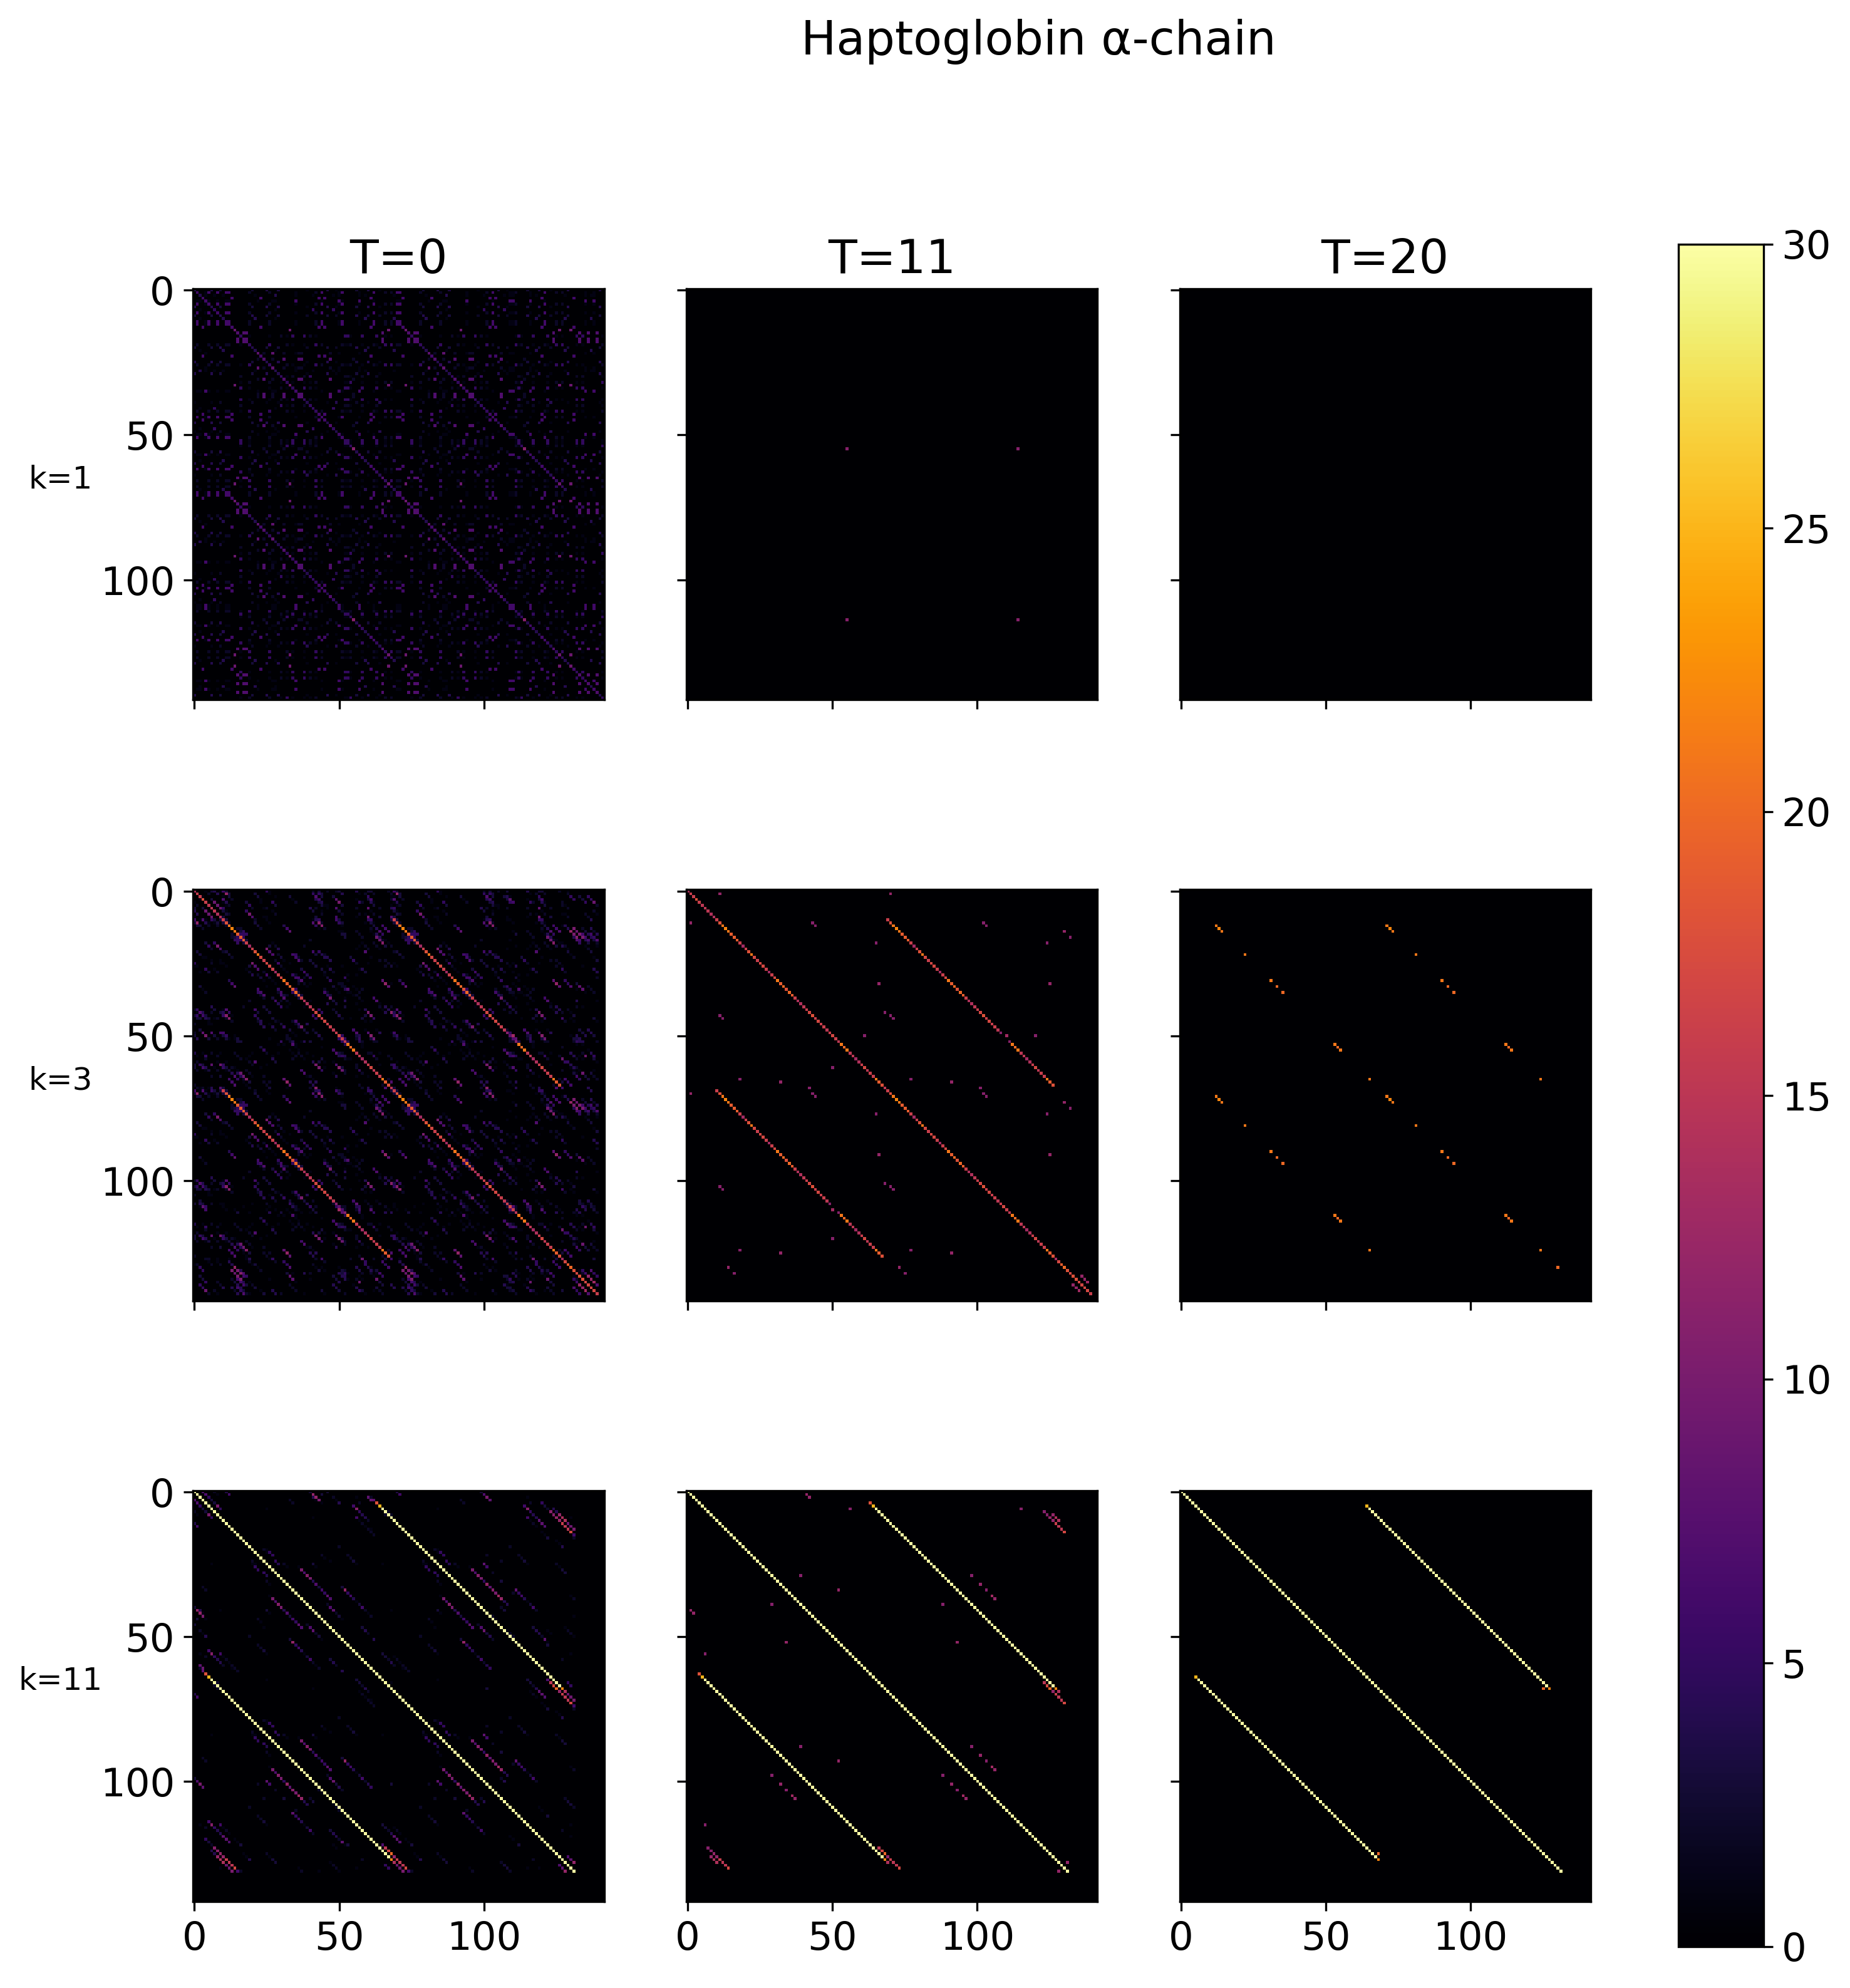

In [15]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 12))
for i, k in enumerate((1, 3, 11)):
    for j, T in enumerate((0, 11, 20)):
        dot = dot_matrix(HP_alpha_chain, M=BLOSUM62, k=k, T=T)
        dot = ax[i, j].imshow(dot, cmap='inferno', vmin=0, vmax=30)
        if j == 0:
            ax[i, j].set_ylabel(f'k={k}', rotation=0, labelpad=15, fontsize=12)
            #ax[i, j].yaxis.set_label_position('right')
        if i == 0:
            ax[i, j].set_title(f'T={T}')
fig.suptitle('Haptoglobin α-chain')
fig.colorbar(dot, ax=ax)
plt.show()

## Ungapped Alignment (Hamming Distance)

### Seed & Extend

With knowledge at hand we are ready to dive into the original version of [BLAST](https://doi.org/10.1016/S0022-2836(05)80360-2) from 1990!

`BLAST90` also looks for these strong diagonal runs, which in its lingo are calls *high-scoring segment pairs* (HSP) on the dot-plot but now the *Subject* sequence (`Y` in previous examples) is huge, either the whole genome (~6G nucleotides) or proteome (6G x 3 reading frames) so generating the whole matrix and finding HSPs by checking all possible alignments is not an option.

However, we can take advantage of the fact the genome/proteome are relatively static and by doing an expensive but one-off (an instance of another famous trade-off between memory and time) *pre-processing* to alleviate the problem by creating an **index** which will allow us to jump directly to interesting regions without checking every pair of aa. Then starting from these "seeds" we expand the alignment in both direction as long as the score "generally increases"

`BLAST90` is based on a series of smart heuristics that speed up the search without sacrificing accuracy or doing so in a controlled way. They key steps of the algorithm are:

0. **Index**: Use a hash table (`dict` in Python) to store for every k-mer the
   coordinates that it appears on the references. Permanently store the index
   for reuse.
1. **Seed**: Break the query sequence in k-mers (same k as for the index) and
   map them to reference via the index. The resulting coordinates are likely
   to be part of an HSP because they score highly in both sequences.
2. **Extend**: the seeds in both directions (independently) along the
   diagonals keeping track of the score of the alignment. 
3. **Xdrop**: Once the score drops below a predefined threshold from the
   highest score recorded for the particular seed, stop the extension and
   return the highest HSP.
4. **E-value**: using the alignment score, together with the scoring matrix and the 
   length of the 2 sequences, calculate the probability that such a score would have 
   arisen by chance given a model of random sampling of amino-acids. 
5. **Thresholding**: Report only alignments that are above a user-defined E-value threshold. 
   Order results by E-value.

![Adapted form Harris, R.S., 2007. Improved pairwise alignment of genomic DNA.](figures/blast90.svg)
Adapted from: https://www.bx.psu.edu/~rsharris/rsharris_phd_thesis_2007.pdf

Below there is a naive implementation (ie focusing on readability and comprehension) that illustrates these steps

In [16]:
# see also: https://github.com/kad-ecoli/ncbi-blast-legacy
class BLAST90:
    def __init__(self, reference, score, k=3, T=13):
        self.score = score  # score matrix
        self.k = k  # length of word
        self.T = T  # Threshold
        self.store_reference(reference)
        self.scaling_const = self.score.calc_K_lambda(self.ref)
        self.index = self.build_index(self.ref)
    
    def store_reference(self, reference):
        '''Concatanate the sequences of all proteins
        
        Sequences are separated by a string of `k` gaps (-).
        That way there can be no seed spanning 2 proteins.
        It also creates a list of "ranges" spanned by each 
        protein in the combined reference. Thus protein[i]
        spans the region of the reference between 
        prot_ranges[i-1]:prot_ranges[i]
        '''
        self.proteins = list(reference.keys())
        self._prot_ranges = []
        self.ref = ''
        sep = self.score.gap_char * self.k  # protein separator
        for prot, seq in reference.items():
            self.ref += seq + sep
            self._prot_ranges.append((len(self.ref), prot))

    def build_index(self, reference):
        '''Returns an index of informative words (k-mers).
        The index is a dictionary that maps words to positions
        in the reference that are similar to it.
        
        Iterate over all k-mers and store the positions where
        they appear in the reference. Then iterate over all
        pairs of words and merge their "hits" if they are similar.
        '''
        hits = {}
        # get positions of words
        for i, word in enumerate(self.iter_words(reference)):
            if self.score(word, word) < self.T:
                # non-informative word, self-similarity == max(score)
                continue
            try:
                hits[word].append(i)
            except KeyError:
                hits[word] = [i]
        
        # merge hits of 2 words if they are similar
        index = hits.copy()
        words = list(index.keys())
        for i, w1 in enumerate(words[:-1]):
            for w2 in words[i+1:]:
                if self.score(w1, w2) >= self.T:
                    index[w1] = self.merge_sorted(index[w1], hits[w2])
                    index[w2] = self.merge_sorted(index[w2], hits[w1])
        return index
    
    def get_protein(self, pos):
        '''Given a position in the combined reference, 
        it returns the protein it belongs to.
        
        `self._prot_ranges` is sorted by construction so we can
        use bisect_left to find quickly the index of the protein. 
        '''
        ix = bisect_left(self._prot_ranges, (pos, ))
        return self._prot_ranges[ix][1]
    
    def search(self, query, Xdrop, Eval_cutoff):
        '''Searches for query in reference and returns all the position is maps.
        
        Args:
            - query: string to look for
            - Xdrop: heuristic to stop expanding the match
            - Eval_cutoff: ignore matches with greater E-value.
        
        Return:
            list with elements of the form (Eval, seed, offset, prot) where:
                + Eval = E-value
                + seed = (i, j) starting position in dot-matrix coordinates
                + offset = (bck, fwd) how far forward and backwards the alignment extends
                + prot = the protein the alignment belongs to
        '''
        hits = []
        scanned = self.diagRanges()  # to avoid double checking a hit
        for i, word in enumerate(self.iter_words(query)):
            for j in self.index.get(word, []):
                seed = (i, j)
                if seed in scanned: 
                    continue
                Eval, offset = self.extend_seed(seed, query, Xdrop)
                scanned.append(seed, offset)
                if Eval < Eval_cutoff:
                    prot = self.get_protein(j)
                    # heappush keeps `hits` "sorted"
                    heappush(hits, (Eval, seed, offset, prot))
        return [heappop(hits) for i in range(len(hits))]
    
    def extend_seed(self, seed, pattern, Xdrop):
        '''Given a starting position (seed) and a pattern it extend the
        alignment in both directions until the score drops below Xdrop.
        '''
        k = self.k
        i, j = seed  # i: query, j: subject
        # extend forward
        query   = self.iter_seq(pattern , i, 1)
        subject = self.iter_seq(self.ref, j, 1)
        score_f, off_f = self.extend_ungapped(query, subject, Xdrop)
        # extend in reverse
        query   = self.iter_seq(pattern , i+k, -1)
        subject = self.iter_seq(self.ref, j+k, -1)
        score_r, off_r = self.extend_ungapped(query, subject, Xdrop)
        # final score = fwd + rev - word (word was added twice)
        score = score_f + score_r - self.score(pattern[i:i+k], self.ref[j:j+k])
        l     =   off_f +   off_r - k  # length of extension
        m = len(pattern) 
        Eval = self.compute_Eval(score, m, l)
        return Eval, (k - off_r, off_f)

    def extend_ungapped(self, pattern, ref, Xdrop):
        '''Extends the pattern along the reference until the score drops 
        Xdrop below the maximum.
        '''
        score = 0  # running score
        max_score, imax = 0, 0
        for i, (p, r) in enumerate(zip(pattern, ref)):
            score += self.score[p, r]
            if score >= max_score:
                # '==' is included because new max is longer
                max_score, imax = score, i
            elif max_score - score > Xdrop:
                break
        return max_score, imax + 1
    
    def compute_Eval(self, score, m, l):
        '''Computes the E-val statistic'''
        K, lam = self.scaling_const
        S = (lam * score - np.log(K)) / np.log(2)
        n = len(self.ref) - l + 1
        m = m - l + 1
        E = m * n * 2**(-S)
        return E
        
    def iter_words(self, text):
        '''Iterate over all k-mers of a text'''
        N = len(text)
        k = self.k
        for i in range(N-k+1):
            yield text[i:i+k]
    
    def iter_seq(self, text, offset=0, step=1):
        '''Iterate over text forward or backward (by step) starting at offset'''
        if step > 0:
            text_range = range(offset, len(text), step)
        else:
            text_range = range(offset-1, -1, step)
        for i in text_range:
            yield text[i]
    
    def iter_seeds(self, query):
        '''Get all the potential seeds for a query'''
        for i, word in enumerate(self.iter_words(query)):
            for j in self.index.get(word, []):
                yield i, j
    
    @staticmethod
    def merge_sorted(X, Y):
        '''
        Given 2 value ascending lists X and Y create a new sorted list Z.
        Concatanating and sorting afterwards would be wasteful since X, Y have order we can exploit.
        Based on actual `merge_sort`
        '''
        Lx, Ly = len(X), len(Y)
        # check if there is something to merge
        if Lx == 0:
            return Y
        if Ly == 0:
            return X
        
        Z = [None] * (Lx + Ly)
        iz, ix, iy = 0, 0, 0
        while True:
            if X[ix] > Y[iy]:
                Z[iz] = Y[iy]
                iy += 1
            else:
                Z[iz] = X[ix]
                ix += 1
            iz += 1
            if ix == Lx: # X is exhausted
                Z[iz:] = Y[iy:]
                break
            elif iy == Ly: # Y is exhausted
                Z[iz:] = X[ix:]
                break
        return Z
    
    # inside BLAST
    class diagRanges:
        '''
        Data structure to keep explored diagonals.
        Seeds may be position close to each other and some extention may cover them.
        Changing the staring point of the HSP does not affect the outcome.
        Extention is bi-directional and only depends on max_score and Xdrop
        '''
        def __init__(self):
            self.ranges = {}
        
        def append(self, coord, offset):
            row, col = coord
            diag = col - row
            interval = range(row+offset[0], row+offset[1])
            try:
                self.ranges[diag].append(interval)
            except KeyError:
                self.ranges[diag] = [interval]
        
        def __contains__(self, coord):
            row, col = coord
            diag = diag = col - row
            for interval in self.ranges.get(diag, []):
                if row in interval or col in interval:
                    return True
            return False
        
def print_blast(aln, query, ref):
    Eval, seed, offset, prot = aln
    i, j = seed
    b, f = offset
    qseq = query[i-b:i+f]
    rseq = str(ref[j-b:j+f])
    mis  = ''.join('|' if r == q else ' ' for q, r in zip(qseq, rseq))
    head = f'Protein: {prot}  E-value: {Eval:.2E}'
    print('\n'.join([head, 
                     '-' * len(head), 
                     'Query: ' + qseq,
                     '       ' + mis,
                     'Sbjct: ' + rseq]))

Let's test that on some Hemoglobins from [UNIPROT](https://www.uniprot.org/):

- Human: [P68871](https://www.uniprot.org/uniprotkb/P68871/entry#sequences)
- Chimpazee: [P68873](https://www.uniprot.org/uniprotkb/P68873/entry#sequences)
- Sheep: [P02075](https://www.uniprot.org/uniprotkb/P02075/entry#sequences)
- Cat: [P07412](https://www.uniprot.org/uniprotkb/P07412/entry#sequences)
- Goldfish: [P02140](https://www.uniprot.org/uniprotkb/P02140/entry#sequences)
- Bloodworm: [P02216](https://www.uniprot.org/uniprotkb/P02216/entry#sequences)

In [17]:
uniprot2en = {'P02075': 'Sheep', 'P07412': 'Cat',  'P68871': 'Human',
              'P68873': 'Chimp', 'P02216': 'Worm', 'P02140': 'Goldfish'}

def parse_uniprot_id(unid):
    # unid example sp|P68871|HBB_HUMAN
    unid = unid.split('|')[1]
    return uniprot2en[unid]

hemoglobins = {parse_uniprot_id(rec.id): rec.seq
               for rec in SeqIO.parse('hemoglobins.fasta', 'fasta')}
hemoglobins

{'Sheep': Seq('MLTAEEKAAVTGFWGKVKVDEVGAEALGRLLVVYPWTQRFFEHFGDLSNADAVM...KYH'),
 'Cat': Seq('GFLTAEEKGLVNGLWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSSADAI...KYH'),
 'Human': Seq('MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDA...KYH'),
 'Chimp': Seq('MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDA...KYH'),
 'Worm': Seq('GLSAAQRQVIAATWKDIAGADNGAGVGKDCLIKFLSAHPQMAAVFGFSGASDPG...LQS'),
 'Goldfish': Seq('VEWTDAERSAIIGLWGKLNPDELGPQALARCLIVYPWTQRYFATFGNLSSPAAI...QYH')}

In [18]:
globin_blast = BLAST90(hemoglobins, BLOSUM62)
query = 'WGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDL'
hits = globin_blast.search(query, Xdrop=20, Eval_cutoff=1)

for hit in hits:
    print_blast(hit, query, globin_blast.ref)
    print('\n')

Protein: Cat  E-value: 6.54E-22
-------------------------------
Query: WGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDL
       ||||||||||||||||||||||||||||||||||
Sbjct: WGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDL


Protein: Human  E-value: 6.54E-22
---------------------------------
Query: WGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDL
       ||||||||||||||||||||||||||||||||||
Sbjct: WGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDL


Protein: Chimp  E-value: 6.54E-22
---------------------------------
Query: WGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDL
       ||||||||||||||||||||||||||||||||||
Sbjct: WGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDL


Protein: Sheep  E-value: 1.05E-19
---------------------------------
Query: WGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDL
       |||| ||||| |||||||||||||||||| ||||
Sbjct: WGKVKVDEVGAEALGRLLVVYPWTQRFFEHFGDL


Protein: Goldfish  E-value: 3.62E-15
------------------------------------
Query: WGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDL
       ||| | || |  || | | ||||||| |  || |
Sbjct: WGKLNPDELGPQALARCLIVYPWTQRYFATFGNL




#### Index

![](figures/seed_hashing.svg) 
Adapted from: https://doi.org/10.1109/JPROC.2015.2455551

Creating the index is no trivial task. *Seed design* is an [active area of research](https://doi.org/10.3389/fgene.2020.00572) and tries to balance *sensitivity*, ie increase the probability that a strong diagonal is selected, with *specificity*, ie decrease the chances that
a weak diagonal is selected. 

Here we adopted a rather naive approach where we used Python's build-in `dict` to map strings of length $k$ to lists of integers. The only non trivial choice we made was to allow for non-exact matches. This choice had the effect of increasing the pool of seeds and thus the *sensitivity* of our alignment. Some other degrees of freedom that we had but did not exploit are:

1. Define our own *hash-function*. The space of possible kmers is fixed so we can be smart with our design.
2. Pick non-contiguous k-mers ([spaced seeds](https://doi.org/10.1093/bioinformatics/18.3.440))

We also allowed the user to define $k$. Larger $k$ make it less likely that we are going to find an exact match in the reference and thus increase the risk of false-negative. Smaller $k$ pick too many seeds and makes it harder to find the optimal alignment.

Below we plot the probability of finding an exact match as a function of $k$ and the length of the genome (assuming a random genome).

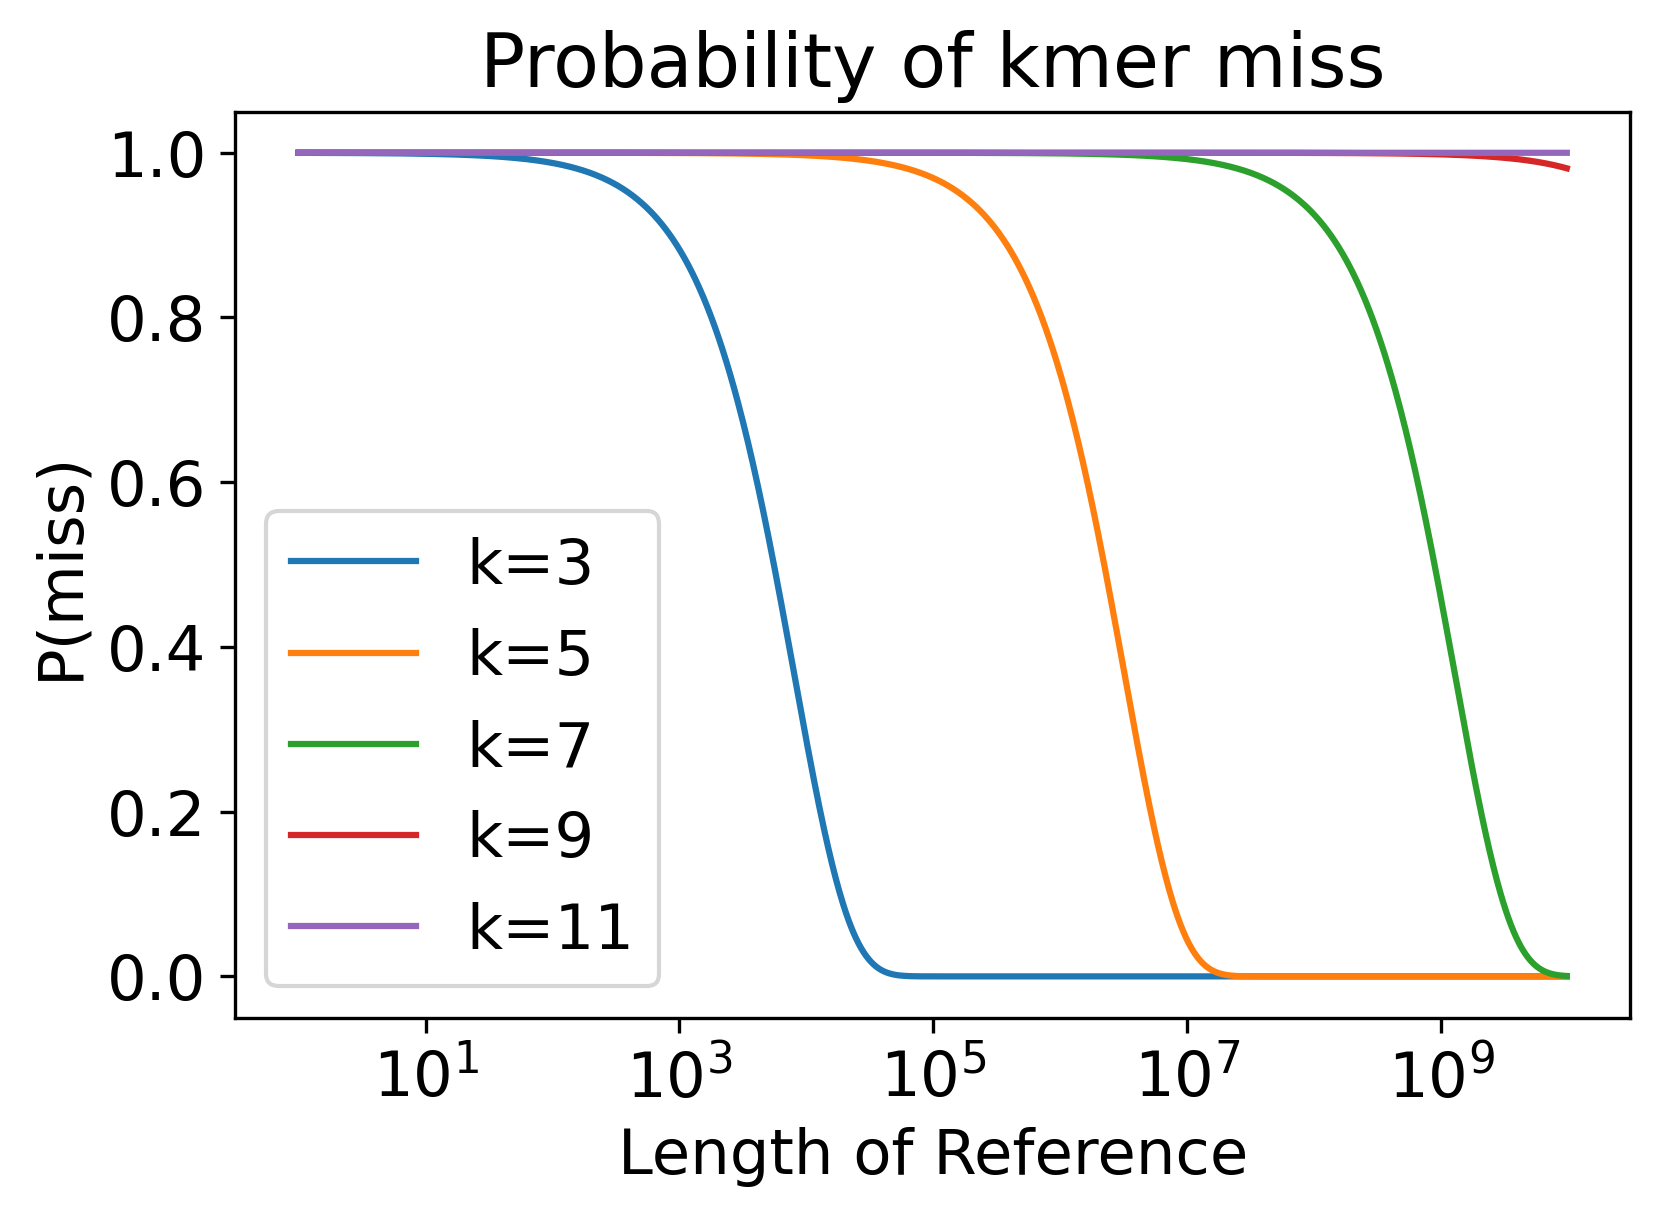

In [19]:
# what's the probably of a word not hashing? (Infinite monkeys theorem)
N = 10**np.arange(0, 10, 0.01)  # 10^10 ~ proteome size 6 (reading frame) * 6e9 letter (3.2 x 2)
Sigma = 20  # amino-acids
for k in (3, 5, 7, 9, 11):
    plt.plot(N, (1-1/Sigma**k)**N, label=f'k={k}')
plt.xscale('log')
plt.xlabel('Length of Reference')
plt.ylabel('P(miss)')
plt.title('Probability of kmer miss')
plt.legend()
plt.show()
#10^k is where the curve begins (N overpowers k)

The functional form of this relationship came from the following reasoning:

- The probability of match for a specific pair of positions is $\frac{1}{|\Sigma|}$
  (both are picked at random and the 1st is free)
- Thus for a k-mer the probability of exact match is $\frac{1}{|\Sigma|^k}$ 
  (k times the probability of a single position)
- Conversely the probability of non-match is  $1-\frac{1}{|\Sigma|^k}$
- For a reference genome of length N (for the human genome: $N \approx 6 \times 10^9$ 
  and for the proteom we can roughly multiply by 3 for the 3 reading frames) 
  there are $N-k$ k-mers so the probability that none of them matches a given seed is: 

$$P(\text{no-match}) = \left(1-\frac{1}{|\Sigma|^k}\right)^{(N-k)}$$

So we see that we are virtually guaranteed to find a match for small values of k and in fact we are going to find multiple of them (see later). The genome is not random thought so these probabilities are optimistic. Repeats region will lower the effective N for example.

#### Xdrop

As we extend the alignment outwards from the seed, and assuming that we have indeed found a common "feature" of the 2 sequences, we expect the score to trend upwards. Since we are interesting in *local* alignment, we want to report the maximum score for this region. This however, raises the following issue: how can we distinguish between a "random" drop vs a "systematic" drop. We do not want to stop expand if we encounter a random mutations but we do want to stop once we are out of the common feature.

X-drop is a heuristic introduced to address this issue. The motivation is two-fold:

1. **Efficiency**: by stopping the extension early we spend less time at a seed and we increase
   the probability of reporting random alignments (more chances that we pass the threshold)
2. **Resolution**: if 2 "valid" local alignment (in the sense that individually the score highly)    are close to each other then there is a risk of linking them and considering them as a single
   alignment. Stopping early makes it less likely that we are going to tolerate this "linker"
   sequences.


Thus, if tuned properly, [X-drop can increased the efficiency of our algorithm without compromising its accuracy](https://pubmed.ncbi.nlm.nih.gov/10890397/)

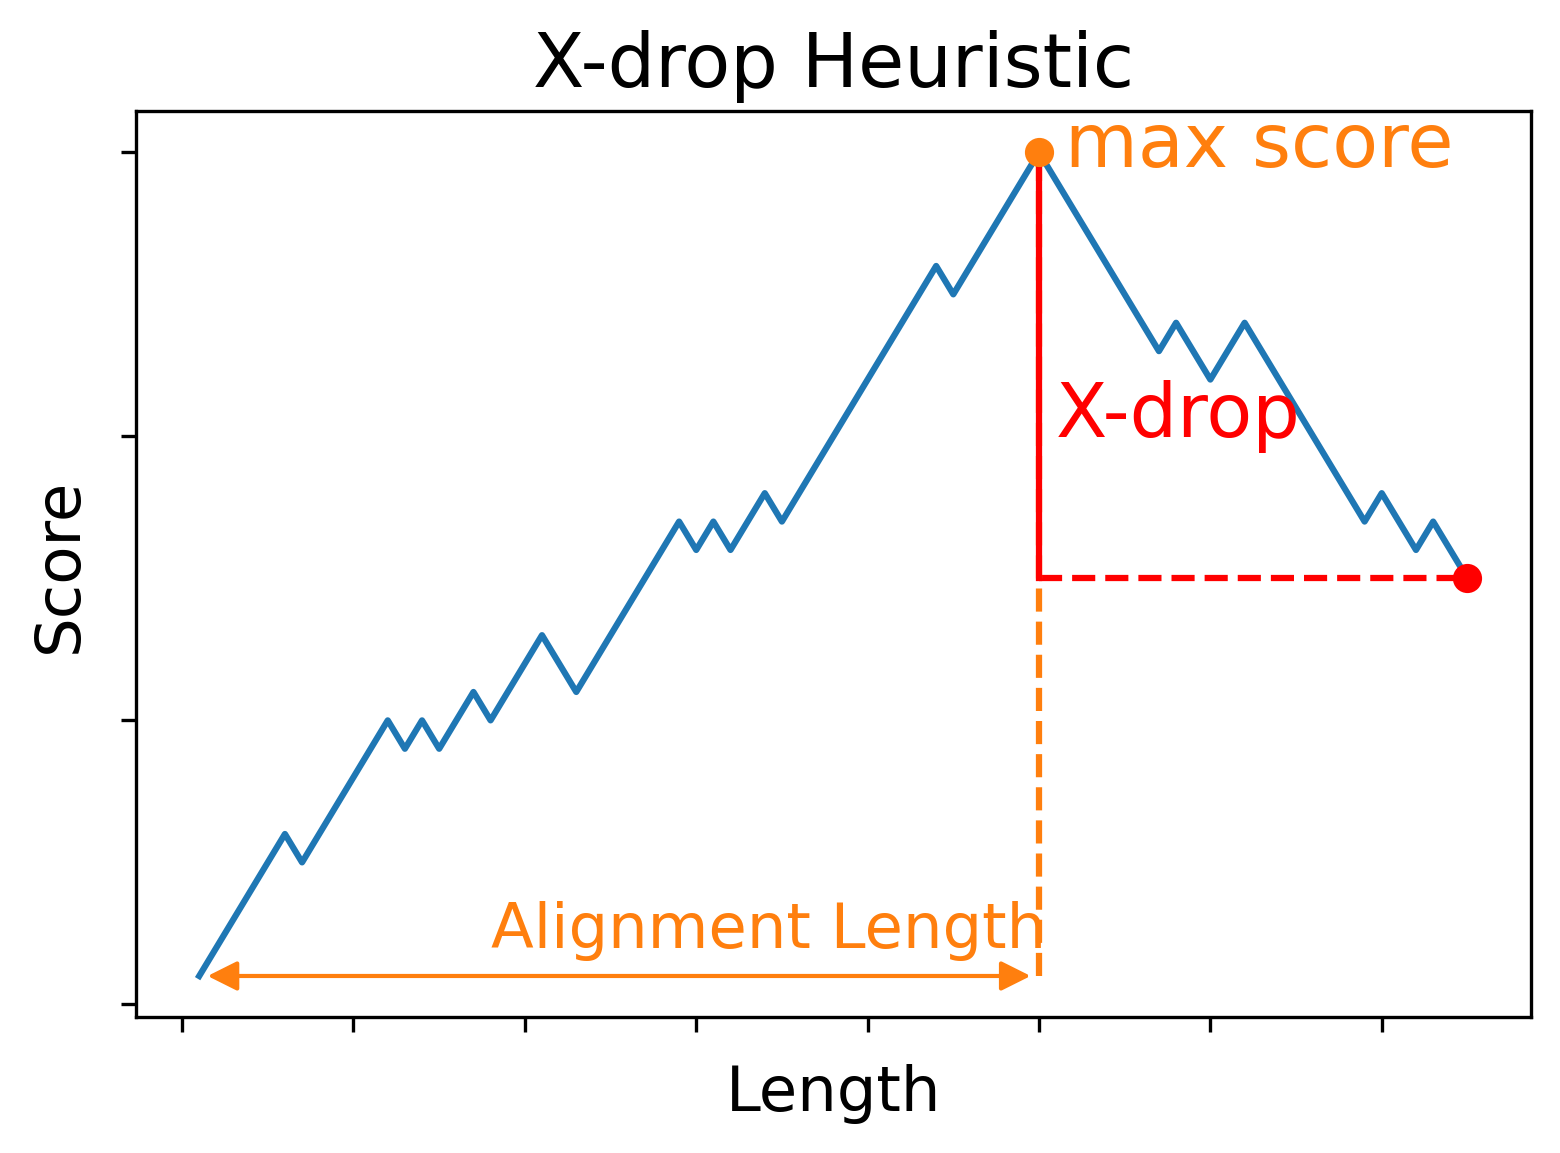

In [20]:
scores = np.asarray(50*[1] + 25*[-1])  # 50 matches and 25 misses
mutations = np.array([ 6, 12, 14, 17, 21, 22, 29, 31, 34, 44, 57, 60, 61, 69, 72])  # rng.uniform(size=75) > .75
scores[mutations] *= -1
scores = np.cumsum(scores)


plt.plot(1+np.arange(len(scores)), scores)
plt.plot(75, scores[74], 'ro')
plt.plot([50, 75], [scores[74], scores[74]], 'r--')
plt.plot([50, 50], [1, scores[49]], '--', color='C1')
plt.plot([50, 50], [scores[49], scores[74]], 'r-')
plt.plot(50, scores[49], 'o', color='C1')
plt.annotate('X-drop', (51, 20), color='red', fontsize='large')
plt.annotate('max score', (51.5, scores[49]-.5), color='C1', fontsize='large')
#plt.arrow(1, 1, 49, 0, head_width=1, color='C1')
plt.annotate('', xy=(1,1), xytext=(50,1), arrowprops={'arrowstyle': '<|-|>', 'color': 'C1'})
plt.annotate('Alignment Length', xy=(18, 2), color='C1')
plt.title('X-drop Heuristic')
plt.xlabel('Length')
plt.ylabel('Score')
plt.xticks(ticks=np.arange(0, 80, 10), labels=[])
plt.yticks(ticks=np.arange(0, 40, 10), labels=[])
#plt.tick_params(labelcolor='#FFFFFF00')
plt.show()

### Karlin-Altschul Statistic

Numbers without scales are meaningless. A scale gives us a sense of magnitude: "high" vs "low". In our case we have alignment scores but we don't know how "significant" they are. A way to define such a scale is to come up with a *null model*, ie a random process that generates such scores without any underlying structure. This process would give rise to a *null distribution* that will play the role of scale.

The question of scale we have is:

> How likely is to find a random local alignment of score $S$ or higher for a query of length $m$?

The question as formed already distinguishes between interesting and uninteresting structures. The score $S$ is our target metric, the quantity we want to scale. The length of the query $m$ is considered "uninteresting" that is why it is incorporated into the framework of the question. So the question is framed in a way that *controls* for sequence length but not for sequence content.

We will start however with a "simpler" question (and then we are going to cheat and assume our way to the former):

> How many random local alignments of score $S$ or higher do we expect to recover for a query of length $m$?

The answer to this latter question is the **E-value** the main statistic scoring local ungapped alignments.

How does a random alignment look like? 

We can imagine that we have a BLAST aligner initiated and we get fed random sequences to align. It aligns them and report back the scores it calculated. So our goal is to figure out how the distribution of these scores look like.

We start by defining what is known and what is unknown (thus "random") in our process. To initiate the BLAST aligner (the `__init__` method), we requested the `reference` and the `score` function so these are known objects. We also received implicitly the alphabet $\Sigma$. What is unknown is the sequences we get fed, so we have to image a random process for them. A simple process one can imagine is that *given* the length of a sequence the characters are drawn uniformly and independently from the alphabet. Such a process would look something like this

In [21]:
def random_sequencer(m, alphabet, p=None):
    if p is not None:
        p = np.array(p)
        assert np.all(p >= 0)
        p = p / sum(p)
    rng = np.random.default_rng()
    while True:
        yield ''.join(rng.choice(alphabet, m, replace=True, p=p))
        
def random_poisson_sequencer(M, alphabet, p=None):
    rng = np.random.default_rng()
    while True:
        m = rng.poisson(M)
        yield ''.join(rng.choice(alphabet, m, replace=True, p=p))

amino_freq = get_amino_freq()  # dictionary {A: freq_A, ...}
aminos, amino_p = zip(*amino_freq.items())

sequence_generator = random_sequencer(10, aminos, amino_p)
for i in range(10):
    s = next(sequence_generator)
    print(s)


DGTTALNSYY
REEVQAGPSC
LDFLAIVAFL
QVIKKAPVIR
DLDIQNVISA
AADIFSLEKD
MLEEQSLAAS
LLYALEMEII
TASAYVQNEL
VRILIIRRDQ


In [22]:
pois_sequence_generator = random_poisson_sequencer(10, aminos, amino_p)
for i in range(10):
    s = next(pois_sequence_generator)
    print(s)

LTSLEARIIA
CSMIRQELA
PNAQNLRGT
AGDVKDVGNLA
PLLVIVHQV
LDVVFIV
ILLSKYQVKRE
LDIVVNATNVISI
ALPVTIGVNIPSFL
VVEGLLLREQTCE


We want to estimate how many high scoring alignment we are expected to get for a random sequence $E = E(Y \mid y)$. Alignment are computed in 2 main steps:

1. Seeding
2. Extension

Seeding gives us starting points so we expect the more seeds we have the more likely we are to get a high scoring alignment. The number of seeds is proportional to the total search space ($mn$ where $m$ is the length of query and $n$ the length of reference). Thus we expect 

$$E \sim mn$$

Below we show with a simulation that this intuition is correct for a random alignment model.

In [23]:
N = 1000
sequence_generator = iter(random_sequencer(N, aminos, amino_p))
ref = {'random': next(sequence_generator)}
blast = BLAST90(ref, BLOSUM62)
q = next(sequence_generator)

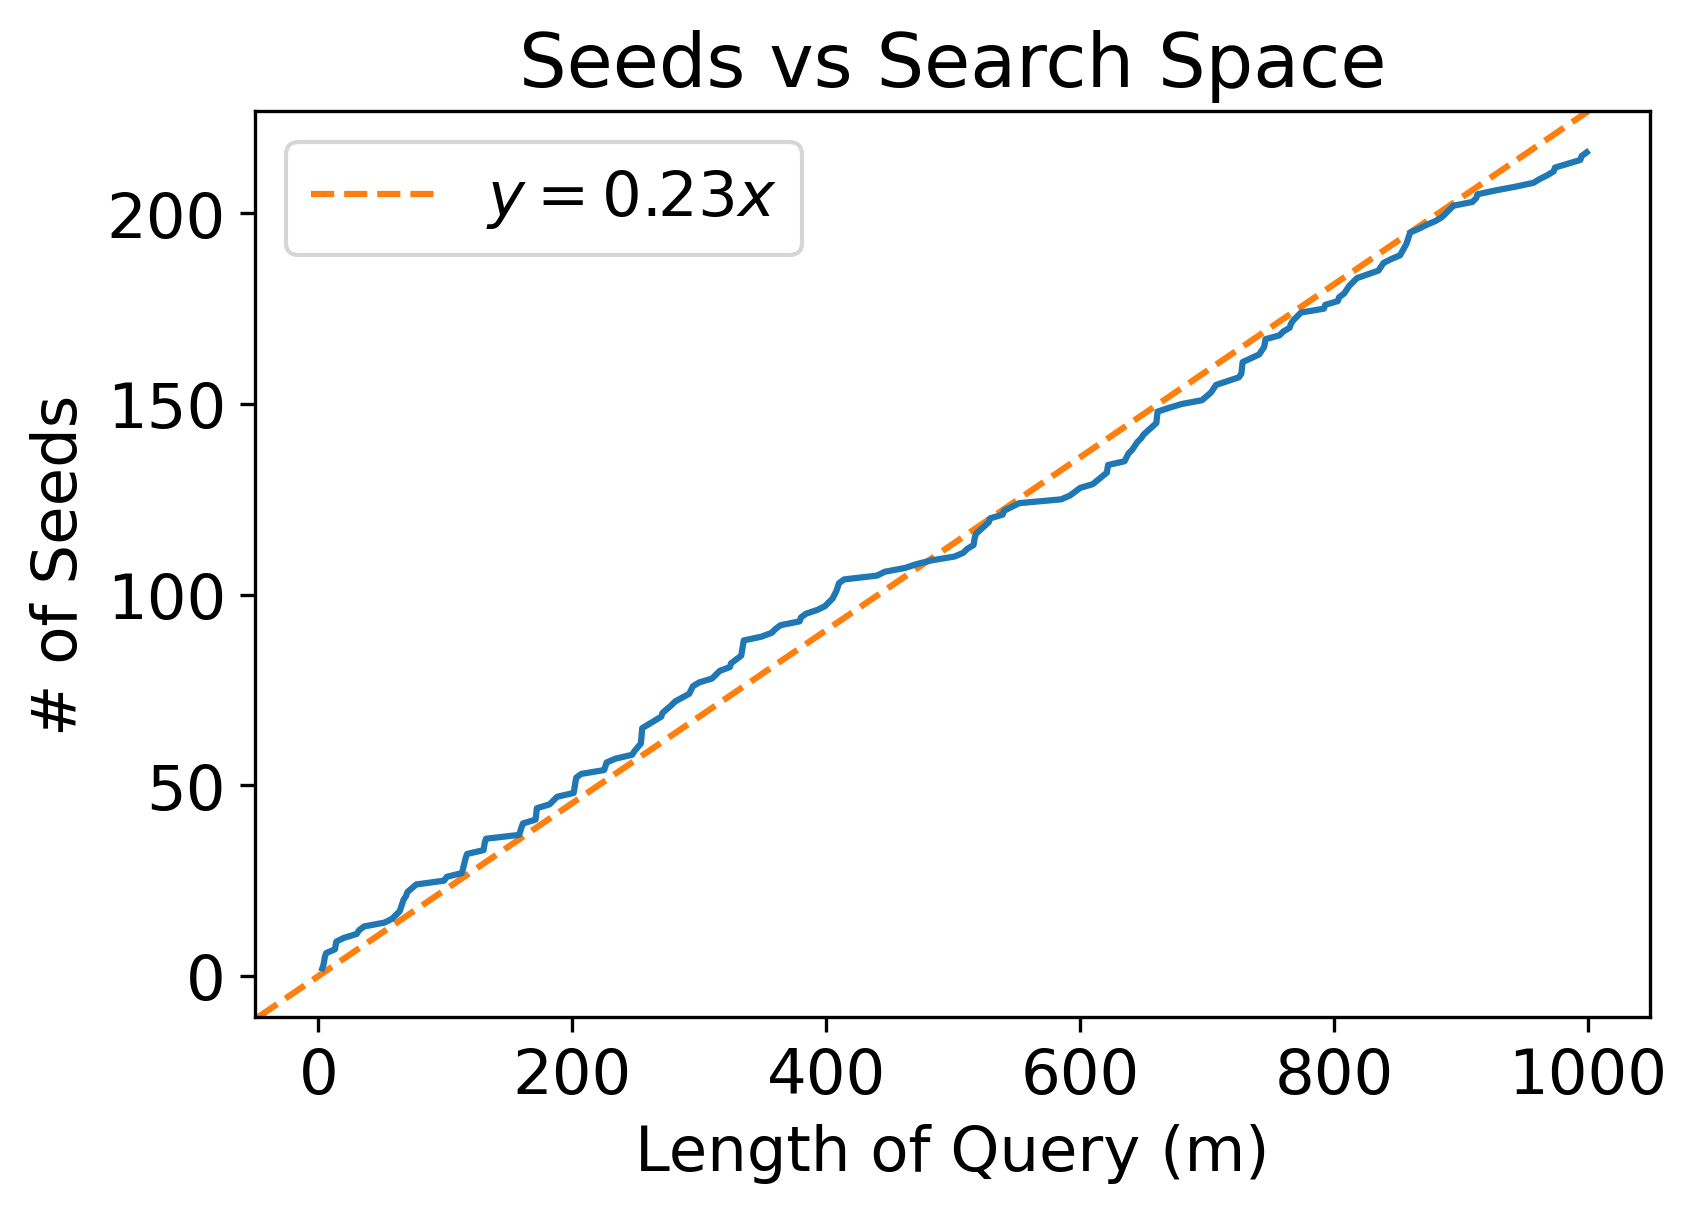

In [24]:
seeds = sorted(s for s in blast.iter_seeds(q))
seeds = np.array([(m, len(list(g))) for m, g in groupby(seeds, lambda x: x[0])])
x, y = seeds[:,0], np.cumsum(seeds[:, 1])
x += blast.k  # each position needs k residues to match
m = np.median(y/x)
plt.axline(xy1=(0, 0), slope=m, ls='--', color='C1', label=f'$y = {m:.2f}x$')
plt.plot(x, y)
plt.xlabel('Length of Query (m)')
plt.ylabel('# of Seeds')
plt.title('Seeds vs Search Space')
plt.legend()
plt.show()

Seeds are extended based on their alignment score, so the other quantity that affects how many sequences we recover is the sequence score. Intuitively, we expect a negative relationship between the score and the number of recovered sequences, ie it is harder to find high scoring sequences. 

We have already addressed the effect of multiple seeds, so for this part of the analysis we can focus on how scores are calculated for a given starting position. As we extend the sequence we expect the global alignment score to fluctuate up and down, but mostly down since the sequences are random and most matches produce a negative score. We define 2 types of points in this random trajectory:

- *ladders*: the series of local mimina that are lower than any previously reached local minima.
- *peaks*: the highest score between 2 ladder points.

In this setting, a local un-gapped alignment is the segment from a ladder to peak.

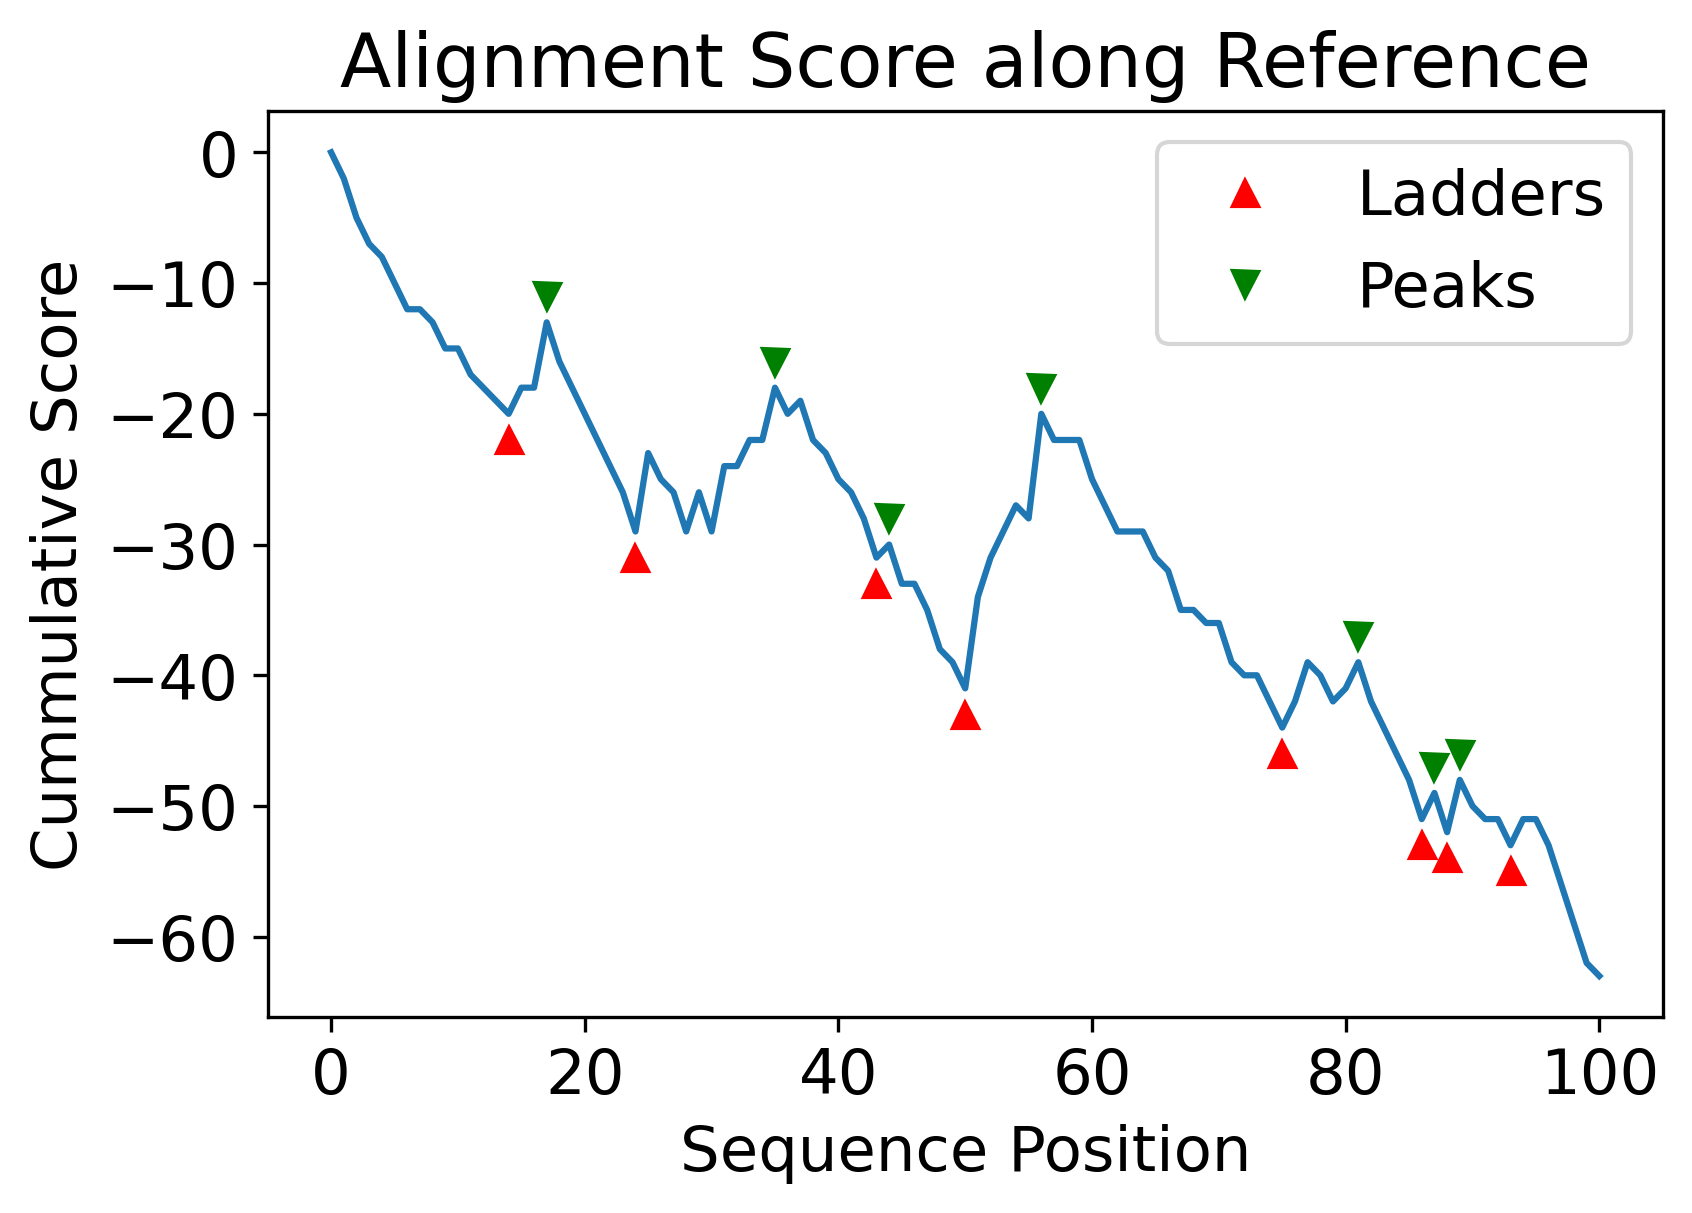

In [25]:
N = 100
sequence_generator = iter(random_sequencer(N, aminos, amino_p))

ref = next(sequence_generator)
q = next(sequence_generator)
X = np.array(BLOSUM62.trace(ref, q))
ladders, peaks = get_ladders_and_peaks(X)

plt.plot(np.arange(len(X)), X, '-')
#for l, p in zip(ladders, peaks): plt.plot(np.arange(l, p+1), X[l:p+1], color='C1')
plt.plot(ladders, X[ladders]-2., "^", color='red', label='Ladders')
plt.plot(peaks, X[peaks]+2., "v", color='green', label='Peaks')
plt.xlabel('Sequence Position')
plt.ylabel('Cummulative Score')
plt.title('Alignment Score along Reference')
plt.legend()
plt.show()

So if we want to simulate the score distribution for a random alignment we have to measure the heights between ladder and peaks along this random walk. Below we simulate this distribution `N` times to get a distribution of scores which looks like an exponential one, so we expect the relationship to be of the form:

$$E \sim e^{-\lambda s}$$

In [26]:
N = 1000
score_freq = {}
for _ in range(N):
    ref = next(sequence_generator)
    q = next(sequence_generator)
    X = np.array(BLOSUM62.trace(ref, q))
    ladders, peaks = get_ladders_and_peaks(X)
    scores = [X[p] - X[l] for l, p in zip(ladders, peaks)]
    for s in scores:
        score_freq[s] = score_freq.get(s, 0) + 1

[]

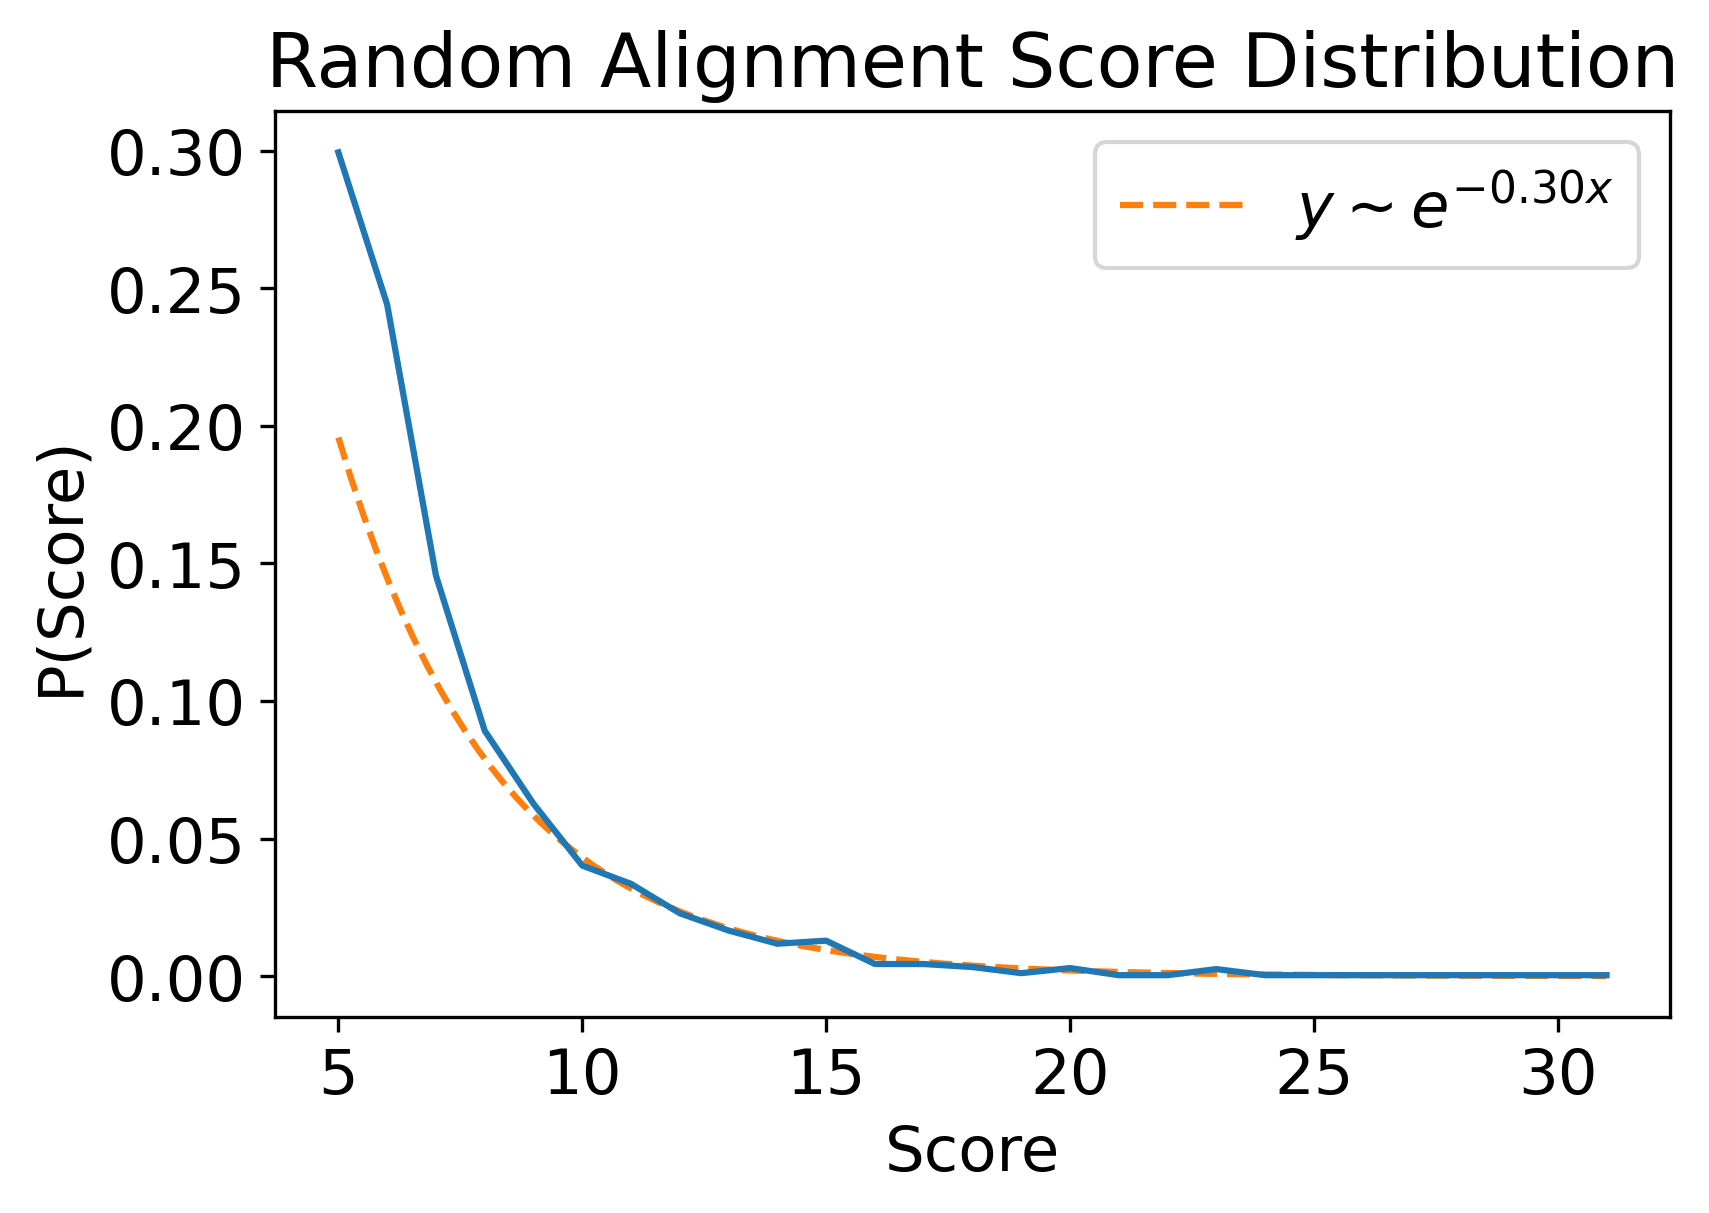

In [27]:
scores, freqs = zip(*sorted(score_freq.items()))
scores, freqs = np.array(scores), np.array(freqs)
scores, freqs = scores[scores > 4], freqs[scores > 4]   # we primarily care for high scores
freqs = freqs/freqs.sum()
m, b = np.polyfit(scores, np.log(freqs), deg=1)

#m = np.median(np.log(freqs)/scores)
x = np.linspace(scores[0], scores[-1], 101)
y = np.exp(m*x + b)
plt.plot(x, y, '--', color='C1', label=f'$y \sim e^{{{m:.2f}x}}$')
plt.plot(scores, freqs)
plt.xlabel('Score')
plt.ylabel('P(Score)')
plt.title('Random Alignment Score Distribution')
plt.legend()
plt.plot()

Building on these 2 intuition we can sketch a theory (for details see appendix):

- The expected number of alignment for a given score $S$ and query length $m$ is: 
  $E = Kmne^{\lambda S}$ for some, $K$, and $\lambda$ and $n$ the length of the reference.
- Given that we are dealing with counts and we only know the mean $E$ of the distribution;
  the distribution that "maximizes the entropy", ie makes the fewest added assumptions, is 
  the Poisson: $N(S) \sim \text{Poisson}(E)$
- Thus, finally, the probability that we observe one or more alignment with a given score is:
  $P(N(S) \ge 1) = 1 - e^E$
- For small value of $E$, less than 0.001 for example, the two values are practically the same.


BLAST uses a normalized version of the score to calculate the E-value:

$$
\begin{align}
  S' &= \frac{\lambda S - \log K}{\log 2}\\
  E &= mn 2^{-S'}
\end{align}
$$

## Gapped Alignment (Levenstein Distance)

Online alignment game: https://teacheng.illinois.edu/SequenceAlignment/

In this section, we are going to devise an algorithm to efficiently compute the optimal gapped alignment between two sequences. Efficiency is of vital importance here since exploring all possible alignments is not feasible even for very small sequences even with the most powerful computers as it scales with $\binom{m+n}{m}$ which is bad.

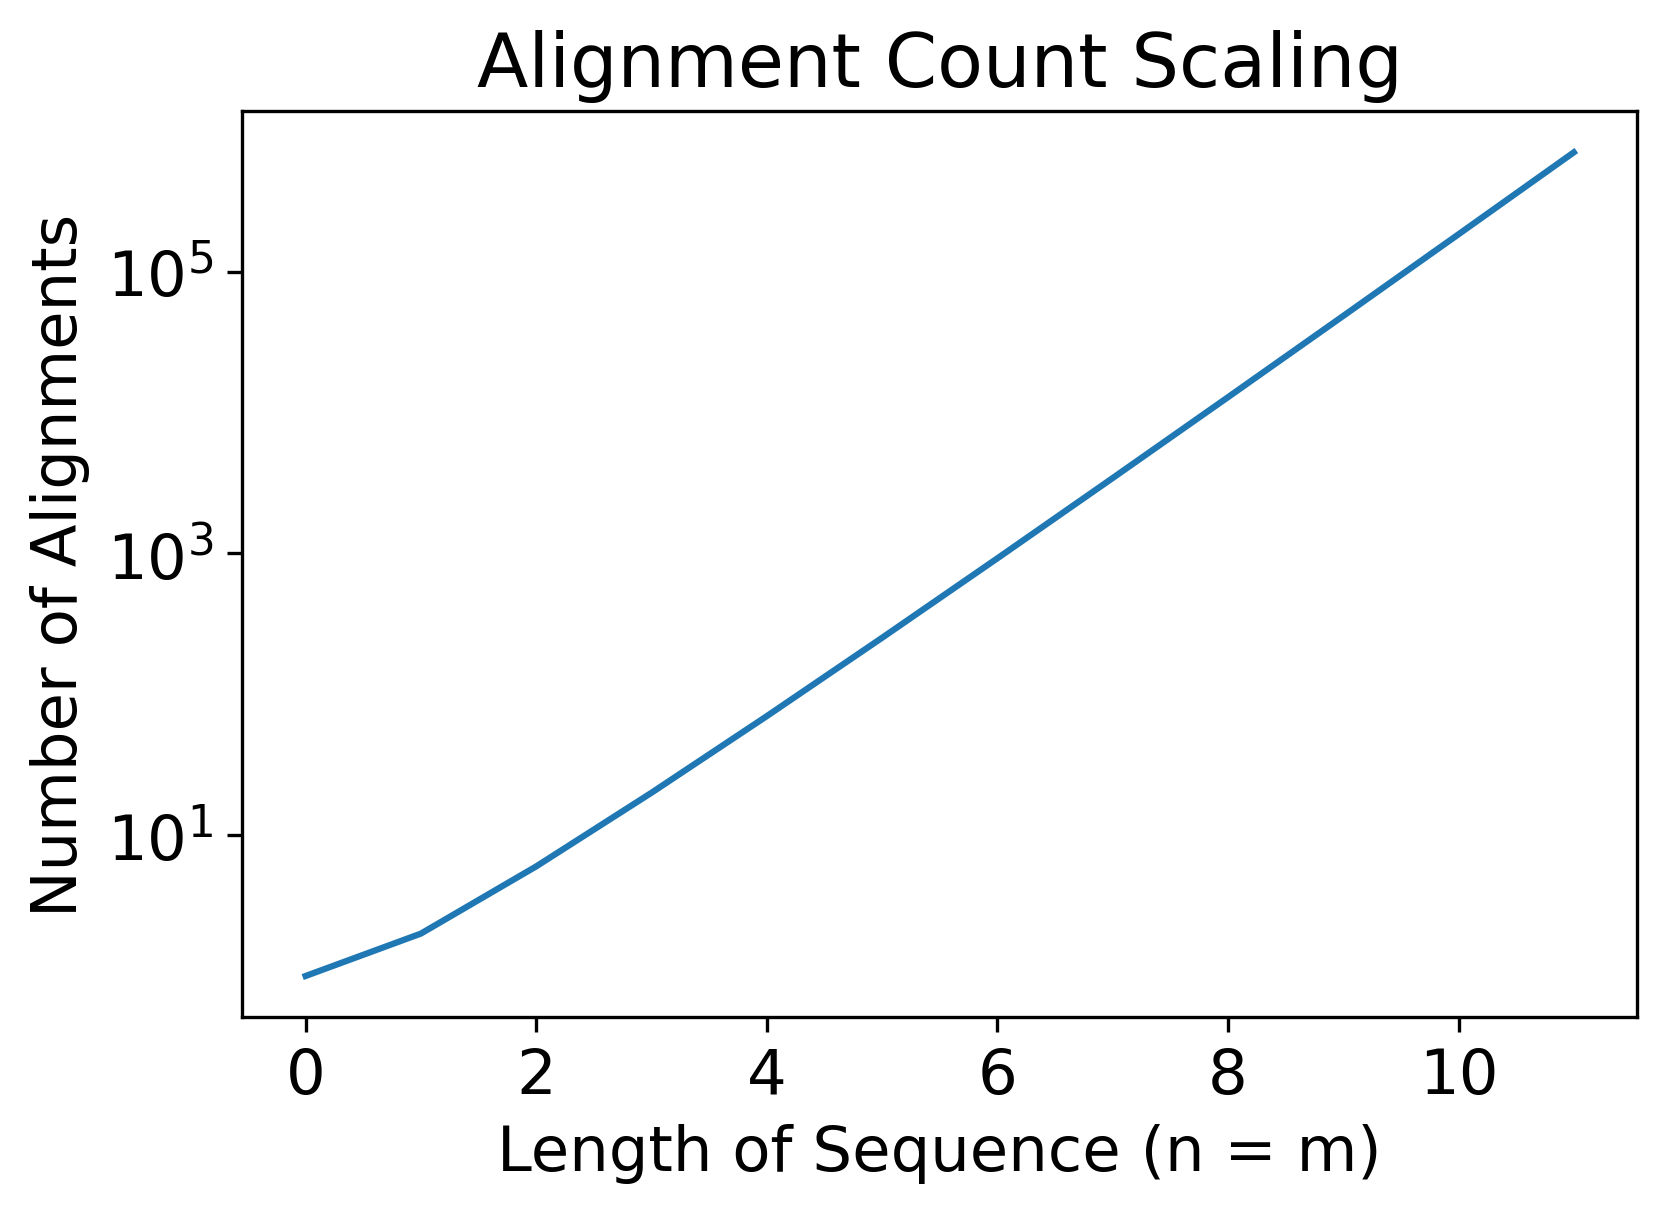

In [28]:
plt.plot([comb(2*n,n) for n in range(12)])
plt.title('Alignment Count Scaling')
plt.xlabel('Length of Sequence (n = m)')
plt.ylabel('Number of Alignments')
plt.yscale('log',base=10)
plt.show()

Also the type of alignment we are interested in may vary with application. We would like to be more lenient in aligning homologue proteins than mapping reads to their genome of origin. Examples
[here](https://training.galaxyproject.org/training-material/topics/sequence-analysis/tutorials/mapping/slides.html#12)

To solve this problem we are going to use one of the classic optimization/programming techniques: Dynamic Programming

### Dynamic Programming


From Wikipedia

> Dynamic programming is a method for solving a complex problem 
by breaking it down into a collection of simpler subproblems, 
solving each of those subproblems just once, and storing their solutions. 
The next time the same subproblem occurs, instead of recomputing its solution, 
one simply looks up the previously computed solution, 
thereby saving computation time at the expense of a (hopefully) modest expenditure in storage space.

Mathematically Dynamical Programming is a form of induction. 

We will start by solving a simpler problem to get an intuition of how the technique works and then address the gapped alignment problem.

#### Optimal Subsequence

**Problem Statement**: Given a finite arithmetic sequence of positive integers, 
find the sub-sequence with the maximum sum without selecting 2 adjacent elements.

As an example, we will solve the problem for the following list: `A = [5, 2, 8, 6, 3, 6, 7, 9]`

If we follow the definition: 

> Dynamic programming is a method for solving a complex problem 
by breaking it down into a collection of simpler subproblems, 

We need to understand what "simpler" means in this problem.
The most natural measure of complexity is the size of the input.
Here we have a sequence of 8 numbers which we are not sure how to solve but
we are very confident that we could find the solution to sequences of length 0, 1 or even 2.
So now the question becomes: 

*How can me construct a solution to bigger problems given the solution to the small ones?*

To answer this, we need one key observation about the optimal sub-sequence.
We need to understand how the solution changes as the problem get smaller.
So if we peel-off the last element of our sequence (here 9) how does the optimal solution change?

Let's denote the original sequence $A_8$ because it has all 8 elements and its optimal sub-sequence $S_8$.
Then there are only 2 possibilities (think why!):

1. $a_8 \notin S_8 \Rightarrow S_8 = S_7$
2. $a_8 \in S_8 \Rightarrow S_8 = S_6 + a_8$

So if someone gave us the answers $S_6$ and $S_7$ we could easily find the solution to $S_8$ as:

$$S_8 = \max(S_7, S_6 + a_8)$$

But $S_6$ and $S_7$ are the solution to $A_6$ and $A_7$ 2 "new" sequences!
So we can apply our logic again and again until we reach $A_1$ and $A_2$ where the answer is easy.

So in general we can write for any sequence of $A_n$ of $n$ letters with elements $a_n$:

$$
S_i = 
\begin{cases}
    \max(S_{i-1}, S_{i-i} + a_i) & i > 1 \\ 
    a_1 & i = 1 \\ 
    0 & i = 0 
\end{cases}
$$

and the sum of the optimal sub-sequence would be $S_n$.

Below is the code for such a function and the original example

In [29]:
def optimal_subseq(A):
    if len(A) == 0:
        return 0
    elif len(A) == 1:
        return A[0]
    S = [0] * (len(A) + 2)  # stores all previous solution S[-2] = S[-1] = 0
    for i, a in enumerate(A):
        S[i] = max(S[i-1], S[i-2] + a)
    return S[:len(A)]

A = np.array([5, 2, 8, 6, 3, 4, 7, 9])
S = optimal_subseq(A)
S[7]  # 7 because python is 0-based

26

Below is all the solution for every subsequence of `A`

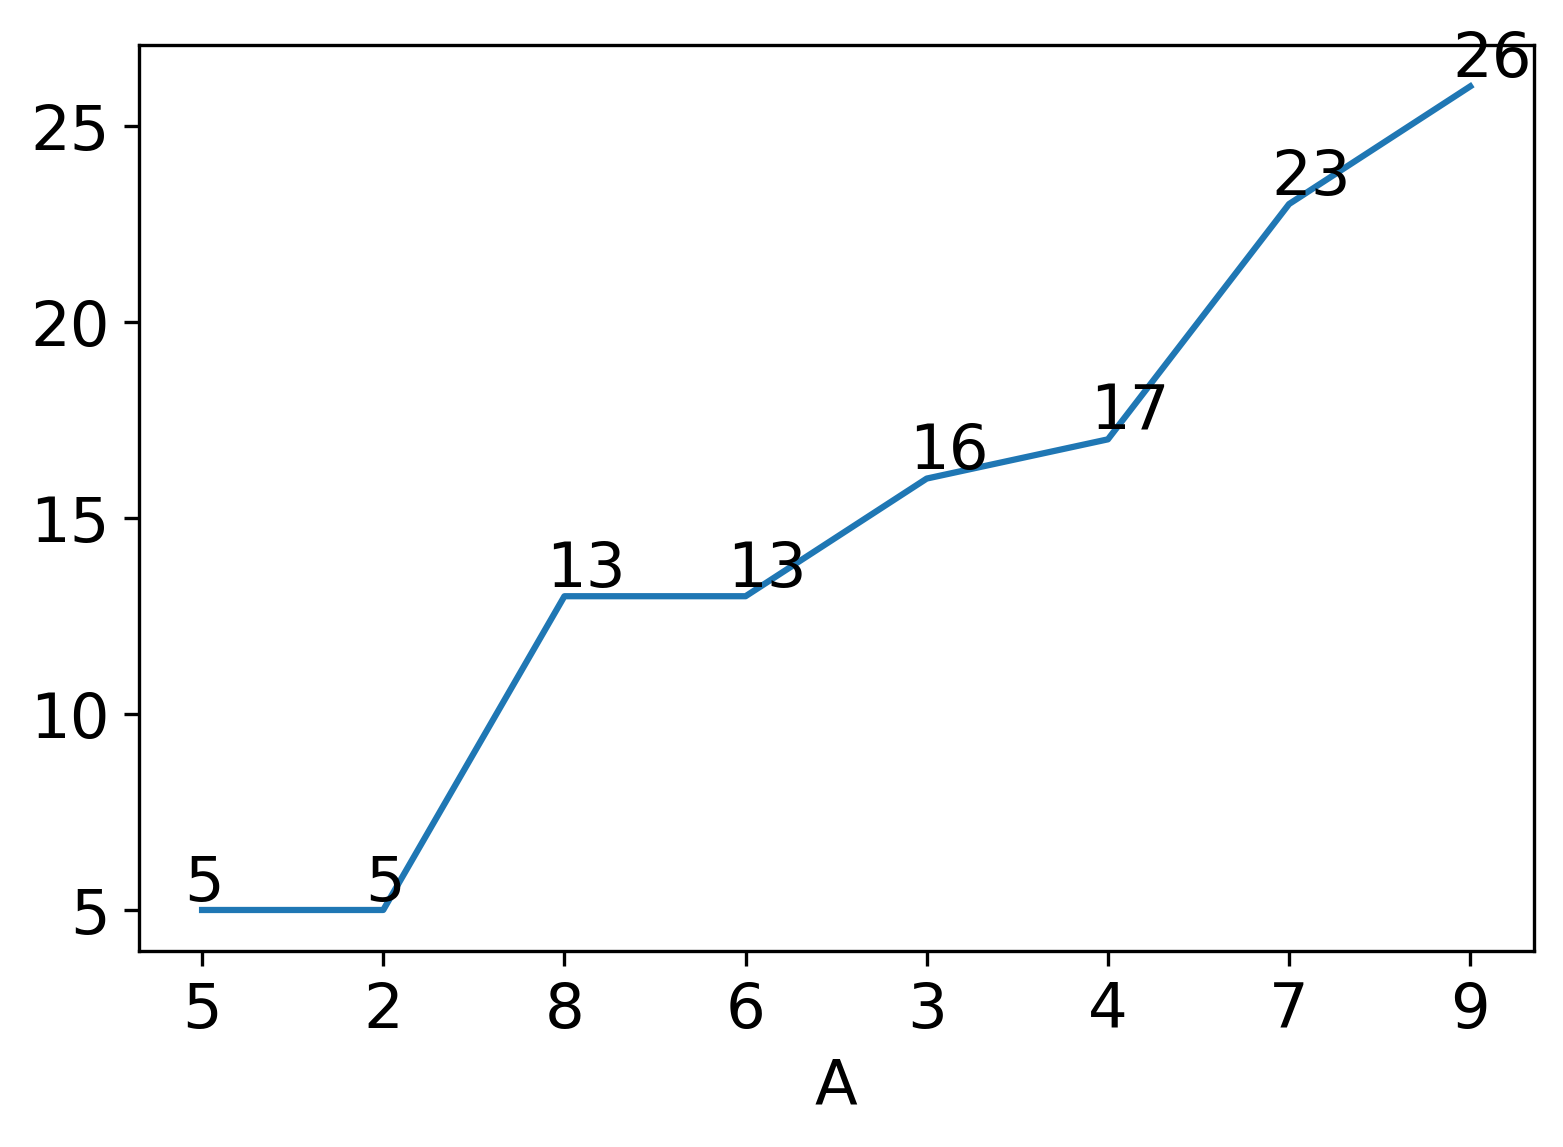

In [30]:
plt.plot(np.arange(len(S)), S)
for i, s in enumerate(S):
    plt.annotate(str(s), (i-.1, s+.25))
plt.xlabel('A')
plt.xticks(ticks = np.arange(len(A)), labels = map(str, A))
plt.show()

As you may have notice, `S` only contains the sums of the optimal sub-sequences, 
not the sub-sequences themselves. If we are interested in them we can reconstruct them.
One solution is to rewrite the function and keep track of our movement.
But if that isn't possible (say you use someone else's code) then you can easily reconstruct afterwards by checking if the current optimal value was reach by adding or skipping the corresponding element in `A`.

Below is the code to do so and we apply it to the `S` we computed before

In [31]:
def reconstruct_seq(S):
    idx = []
    n = len(S) - 1  # we build from the end!
    while n > 0:
        if S[n] == S[n-1]:
            n -= 1
        else:
            idx.append(n)
            n -= 2
    if n == 0:
        idx.append(0)
    return idx[::-1]

ia = reconstruct_seq(S)
print(f'index: {ia}\n list: {list(A[ia])}')


index: [0, 2, 5, 7]
 list: [5, 8, 4, 9]


#### Alignment Problem Structure

We want to expand this approach now to address the optimal alignment problem.
So we have to

1. Recognize the “size” of the problem
2. Imagine how we could construct the optimal solution from smaller ones.
3. Apply the same scheme to the smaller problems until we reach a tractable problem.
4. Store the solutions of the simpler problems and use them to solve more complex one in order.

<!-- Size of problem is 2D -->
Formalizing the *size* of the problem is not as easy as before. In the optimal subsequence problem we had 1 list that we could start shortening/expanding but here we have 2 sequences. Intuitively then the problem "lives" in 2D and we have to imaging of an plane rather than a line. However, if we shift our attention from the given strings to the final, optimally aligned, strings the problem simplifies greatly. In the optimal alignment, we would have 2 new strings of *equal length* composed from letters from the initial strings plus gaps.
So the situation would look like this:

$$
\begin{aligned}
    \hat{X} &= \hat{x}_1\hat{x}_2 \dots \hat{x}_k & \hat{x} &\in \{x_1,\dots,x_m, \_\}\\
    \hat{Y} &= \hat{y}_1\hat{y}_2 \dots \hat{y}_k & \hat{y} &\in \{y_1,\dots,y_n, \_\} \\
\end{aligned}
$$

and we could calculate the alignment score by applying the gain function element-wise.

Thus we have a concrete size to work with, namely $k$ the length of the final alignment.

Now all we have to do is focus on the sub-problem structure and derive how we can construct the optimal solution from them.

As before, the key is to focus on the last elements, namely $(\hat{x}_k, \hat{y}_k)$.
There are 3 possible alignment for these elements:

$$
\begin{aligned}
    \hat{x}_k &= x_m & \hat{y}_k &= y_n \\
    \hat{x}_k &= x_m & \hat{y}_k &= \_ \\
    \hat{x}_k &= \_  & \hat{y}_k &= y_n 
\end{aligned}
$$

And for each case we have a new pair of strings to align $(X', Y')$ which as a pair are **smaller**! These are for each situation:

$$
\begin{aligned}
    X' &= x_1 \dots x_{m-1} & Y' &= y_1 \dots y_{n-1} \\
    X' &= x_1 \dots x_{m-1} & Y' &= Y \\
    X' &= X                 & Y' &= y_1 \dots y_{n-1} 
\end{aligned}
$$

So now if someone handed us the solutions for each of these pairs $S_{X',Y'}, S_{X',Y}, S_{X,Y'}$,
we could construct the solution to the original pair $S_{X,Y}$ by merely comparing all the possibilities and choosing the best:

$$ 
S_{X,Y} = \max
\begin{cases} 
    S_{X',Y'} &+& G(x_m, y_n) \\ 
    S_{X',Y} &+& G(x_m, \_) \\ 
    S_{X,Y'} &+& G(\_,y_n) 
\end{cases} 
$$

We can then run the induction engine and calculate the score for all subsequences until either of the 2 original sequences is exhausted. Aligning an empty string is trivial as we can only use gaps, ie all the letters must be inserted/deleted!

### Path Graph

There is another way to conceptualize the structure of the problem that highlights its 2D nature and builds upon the intuitions we derived from the dot-plots. In particular, we can formalize this idea as a search over a 2D lattice.

We saw in the dot-plot that features of high similarity manifest as diagonal lines (`THIS` and `SENTENCE` in our initial example). For the un-gapped alignment we were willing to pay the price of small mismatches between 2 consecutive diagonals in order to link them (up to a point as defined by Xdrop). Here we would like to link non-consecutive diagonals by moving vertically/horizontally on this plane. Moving vertically/horizontally is equivalent to using letter only in one of the two sequences or inserting gaps in the other. This idea leads to the introduction of *path graphs*.

An example of a path graph for sequences `ACGC` and `GACTAC` is shown below:

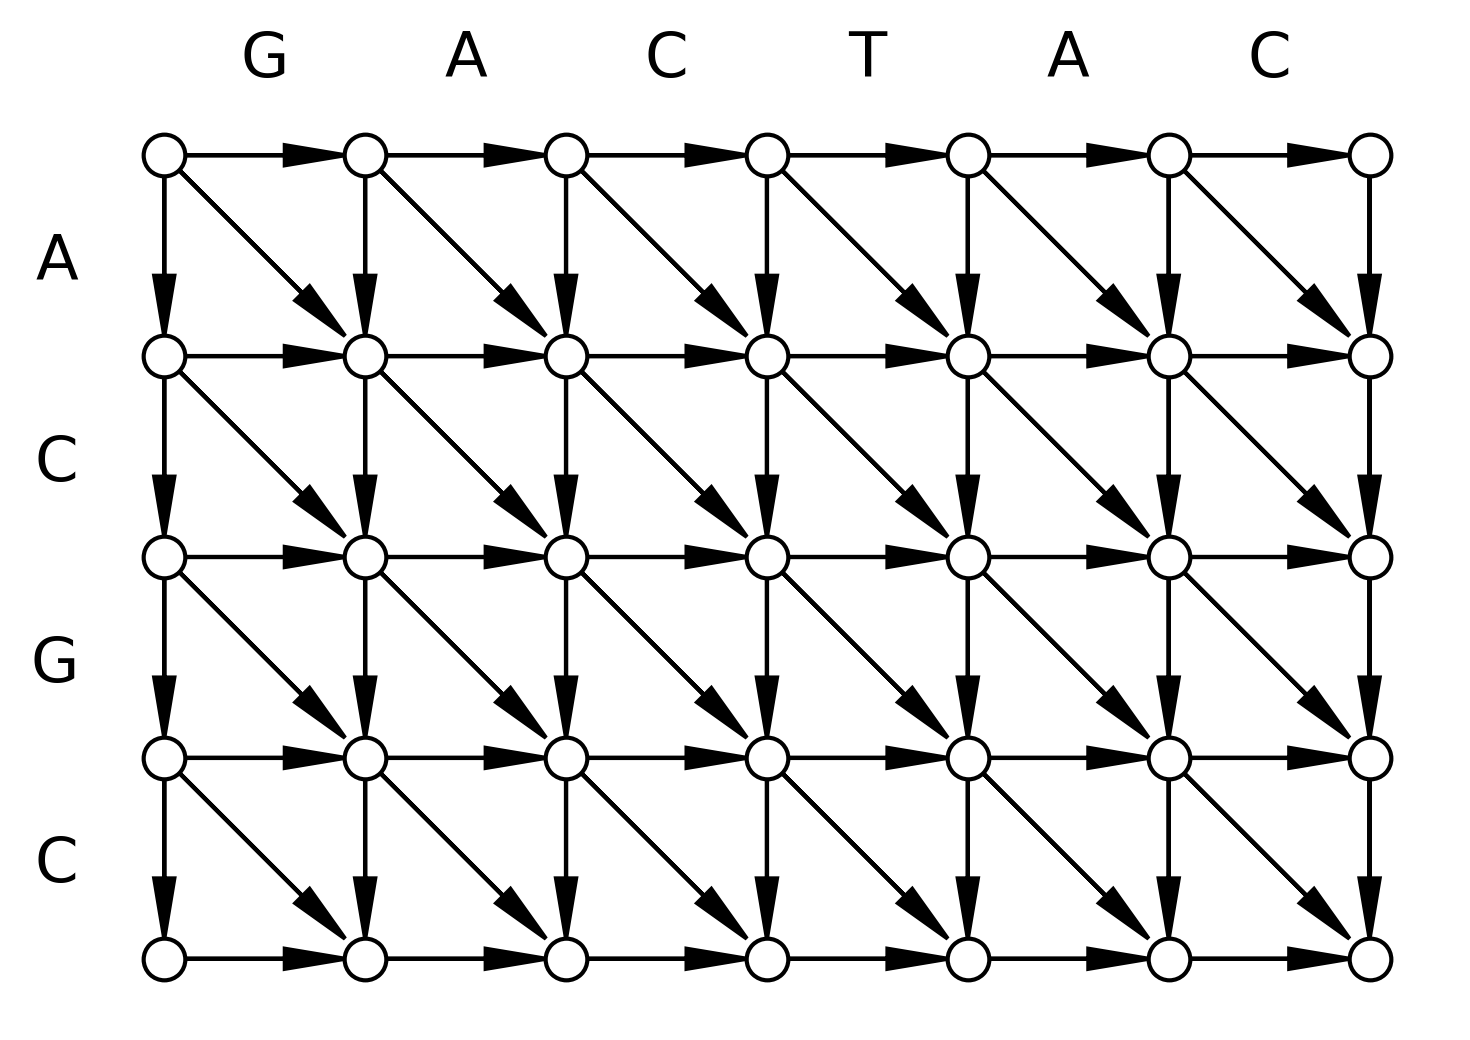

In [32]:
S1, S2 = 'ACGC', 'GACTAC'
fig, ax = plt.subplots()
plot_path_graph(ax, S1, S2)
plt.show()

**Definition**: A path graph of 2 sequences, a *query* $Q$ of length $m$ and *reference* $R$ of length $n$ is a directed network of $(m+1) \times (n+1)$ nodes arranged on a grid. 

- Nodes are indexed by $(i, j) \in [0, m] \times [0, n]$
- Each node correspond to an alignment between subsequences of $Q$ and $R$. So node $(i, j)$ corresponds to an alignment between $Q'=q_1 q_2 \dots q_i$ and $R'=r_1 r_2 \dots r_j$
- Edges are oriented from top to bottom and left to right linking nodes whose either index differ by one ($i \to i+1$ or $j \to j+1$). 
- Each edge correspond to a possible letter matching:
    + Horizontal edges correspond to deletions as they "consume" letter from the reference sequence and not the query
    + Vertical edges correspond to insertions as they "consume" letter from the query sequence and not the reference
    + Diagonal edges correspond to substitutions (possibly trivial ones) as they "consume" letter from both sequences.
- As a result, each edge can be associated with a weight (cost/gain)


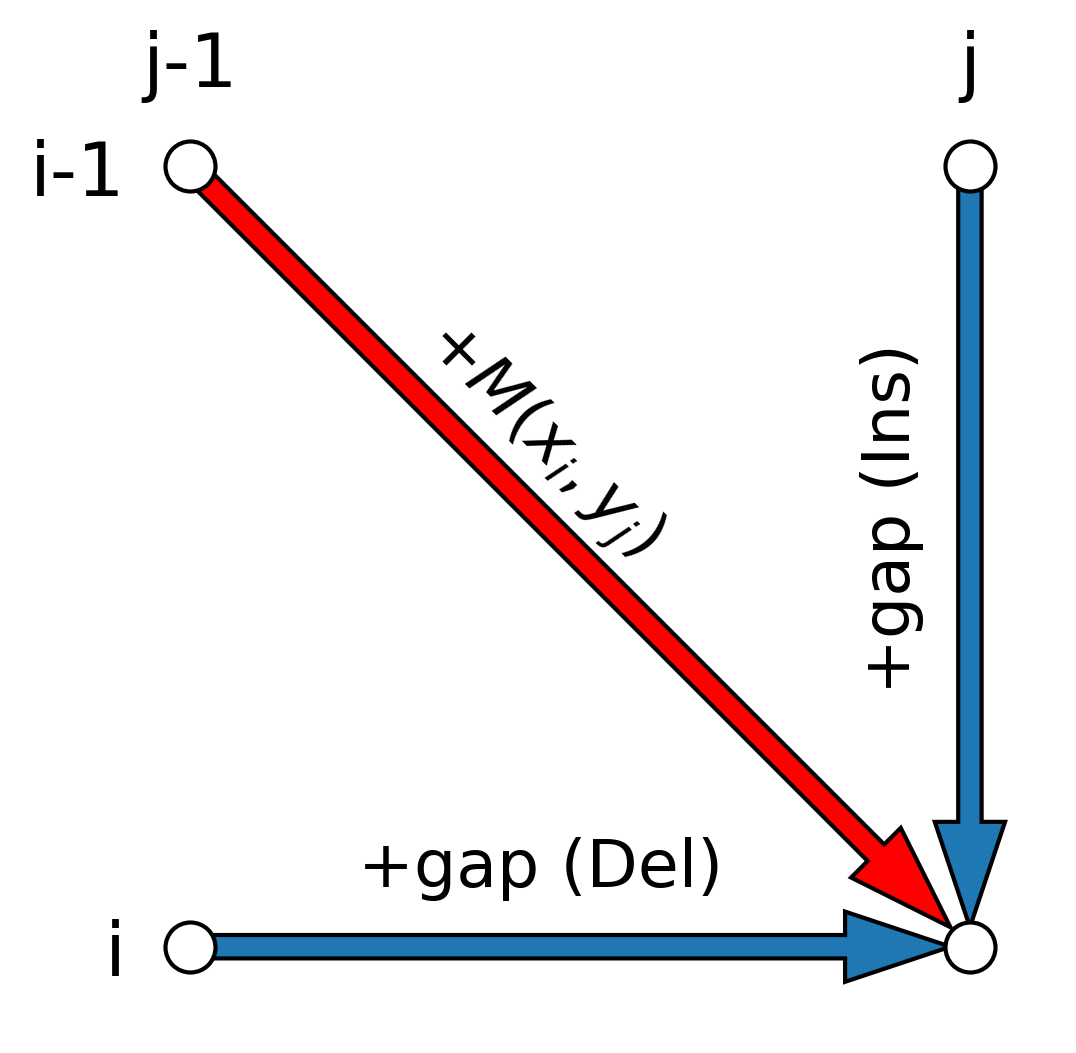

In [33]:
fig, ax = plt.subplots()
ax.plot([0, 0, 1, 1], [0, 1, 0, 1], 'o', markerfacecolor='white', markeredgecolor='black', markersize=12)

arrow_pad = .025
ax.arrow(0, 1, 1-arrow_pad, arrow_pad-1, width = .03, length_includes_head=True, facecolor='red')
ax.arrow(0, 0, 1-arrow_pad, 0, width = .03, length_includes_head=True)
ax.arrow(1, 1, 0, arrow_pad-1, width = .03, length_includes_head=True)

ax.text(.45, .1, '+gap (Del)', ha='center', va='center', fontsize=16)
ax.text(.9, .55, '+gap (Ins)', ha='center', va='center', fontsize=16, rotation=90)
ax.text(.45, .65, '$+M(x_i,y_j)$', ha='center', va='center', fontsize=16, rotation=-45)


#ax.text(1.1, 0, '$S_{ij}$', ha='center', va='center', fontsize=16)
ax.set_xticks(ticks=[0, 1], labels=['j-1', 'j'], fontsize=18)
ax.set_yticks(ticks=[0, 1], labels=['i', 'i-1'], fontsize=18)    
ax.axes.set_aspect('equal')
ax.tick_params(length=0, labelbottom=False, labeltop=True)
ax.set_frame_on(False)
plt.show()

- Each *path* of the graph corresponds to a local gapped alignment. The score and the position of the alignment is defined by the start and end nodes of the path.

Under this formulation, the problem of finding the optimal alignment reduces to finding the highest scoring path between 2 nodes of the graph and we can thus use one of the many path finding algorithms to solve it.

- For the global alignment we want a path starting at $(0,0)$ and ending at $(m,n)$
- For local alignments we want paths with maximum difference between end and start nodes. 

The dynamical programming we sketched above reduces to finding the highest scoring ("longest") scoring path between $(0, 0)$ and $(m,n)$ and we can do so by inductively increases the length of the query.

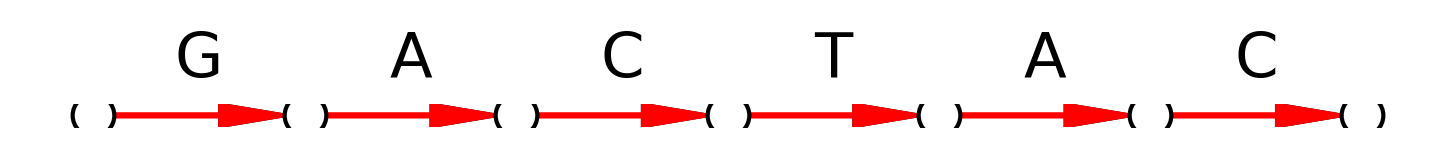

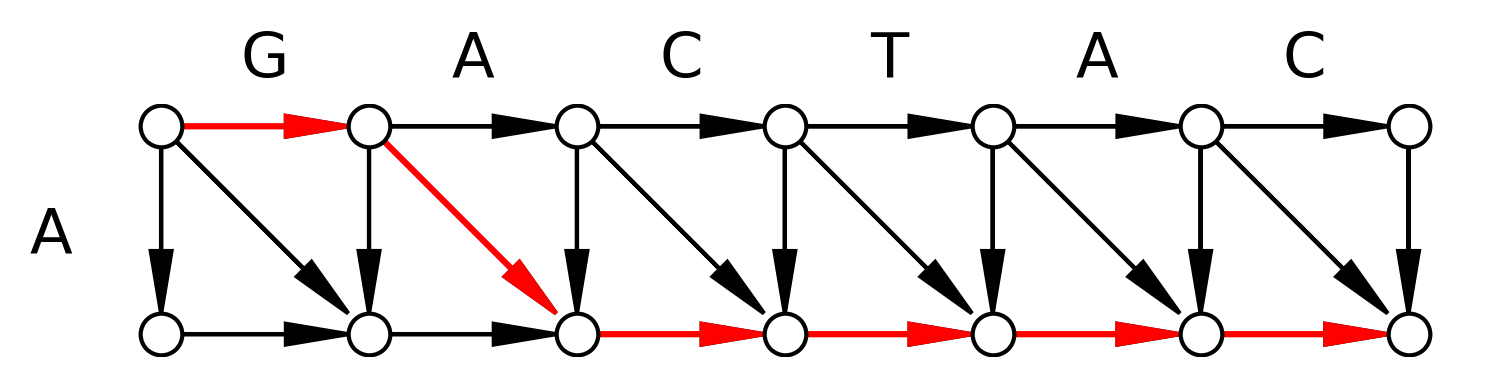

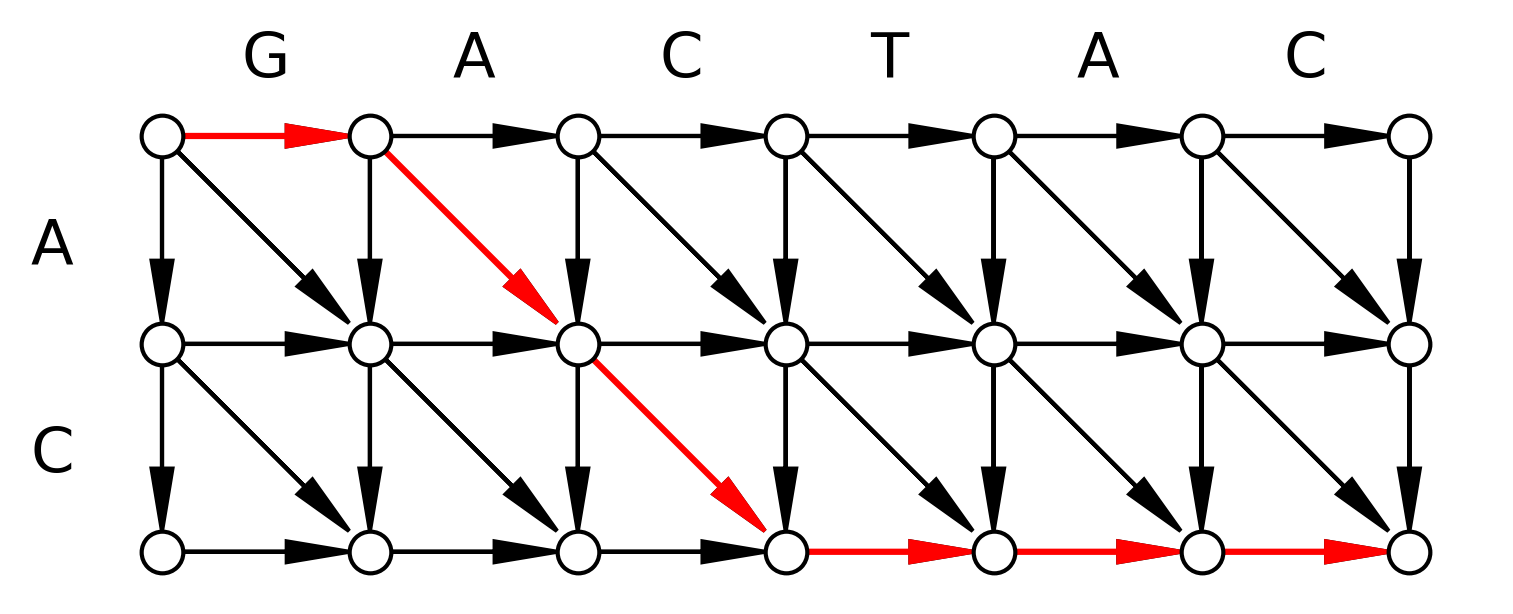

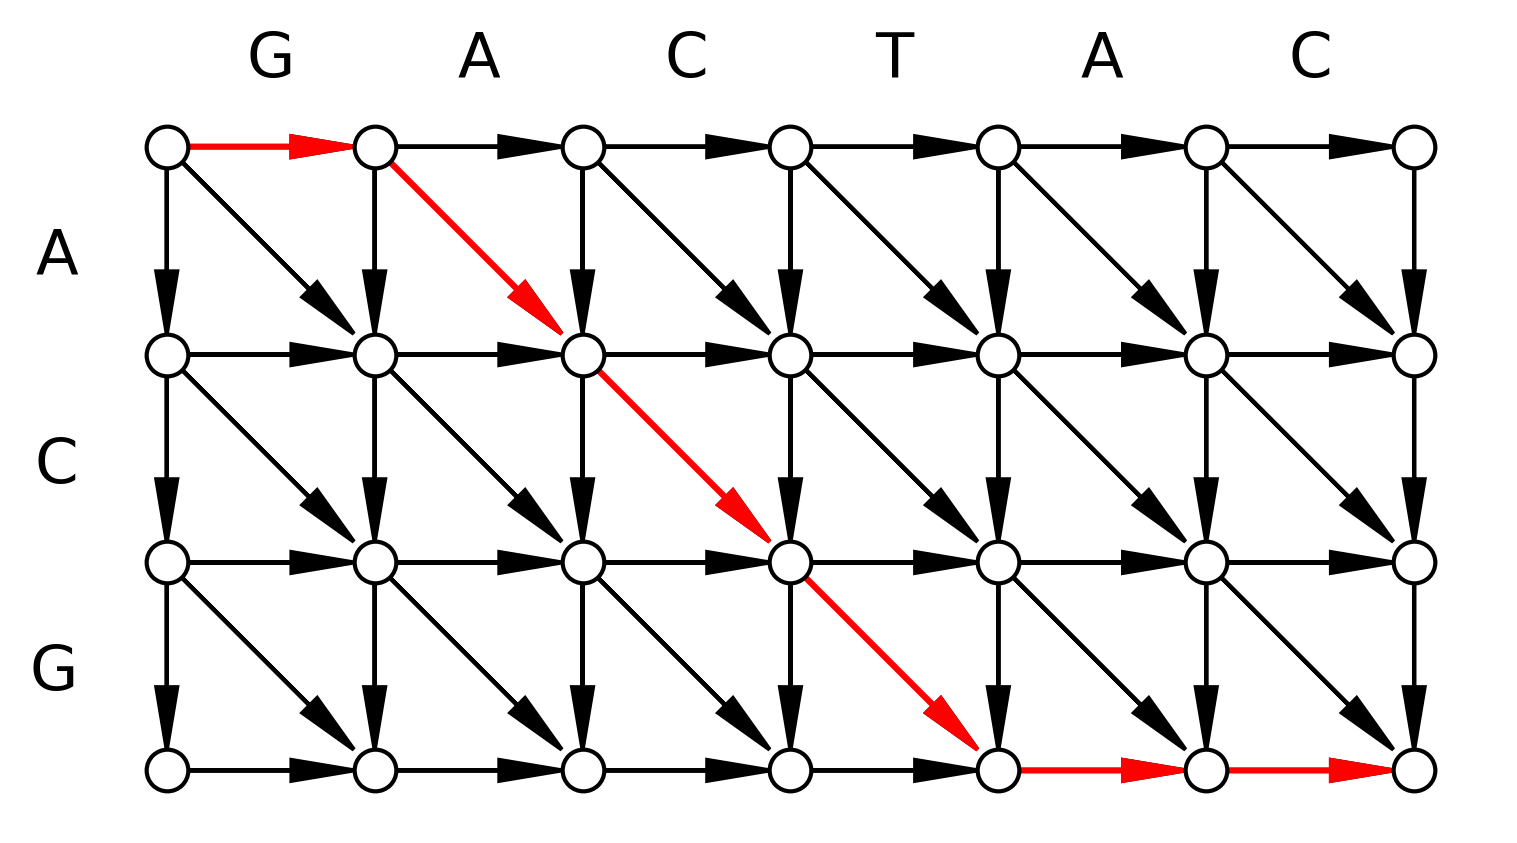

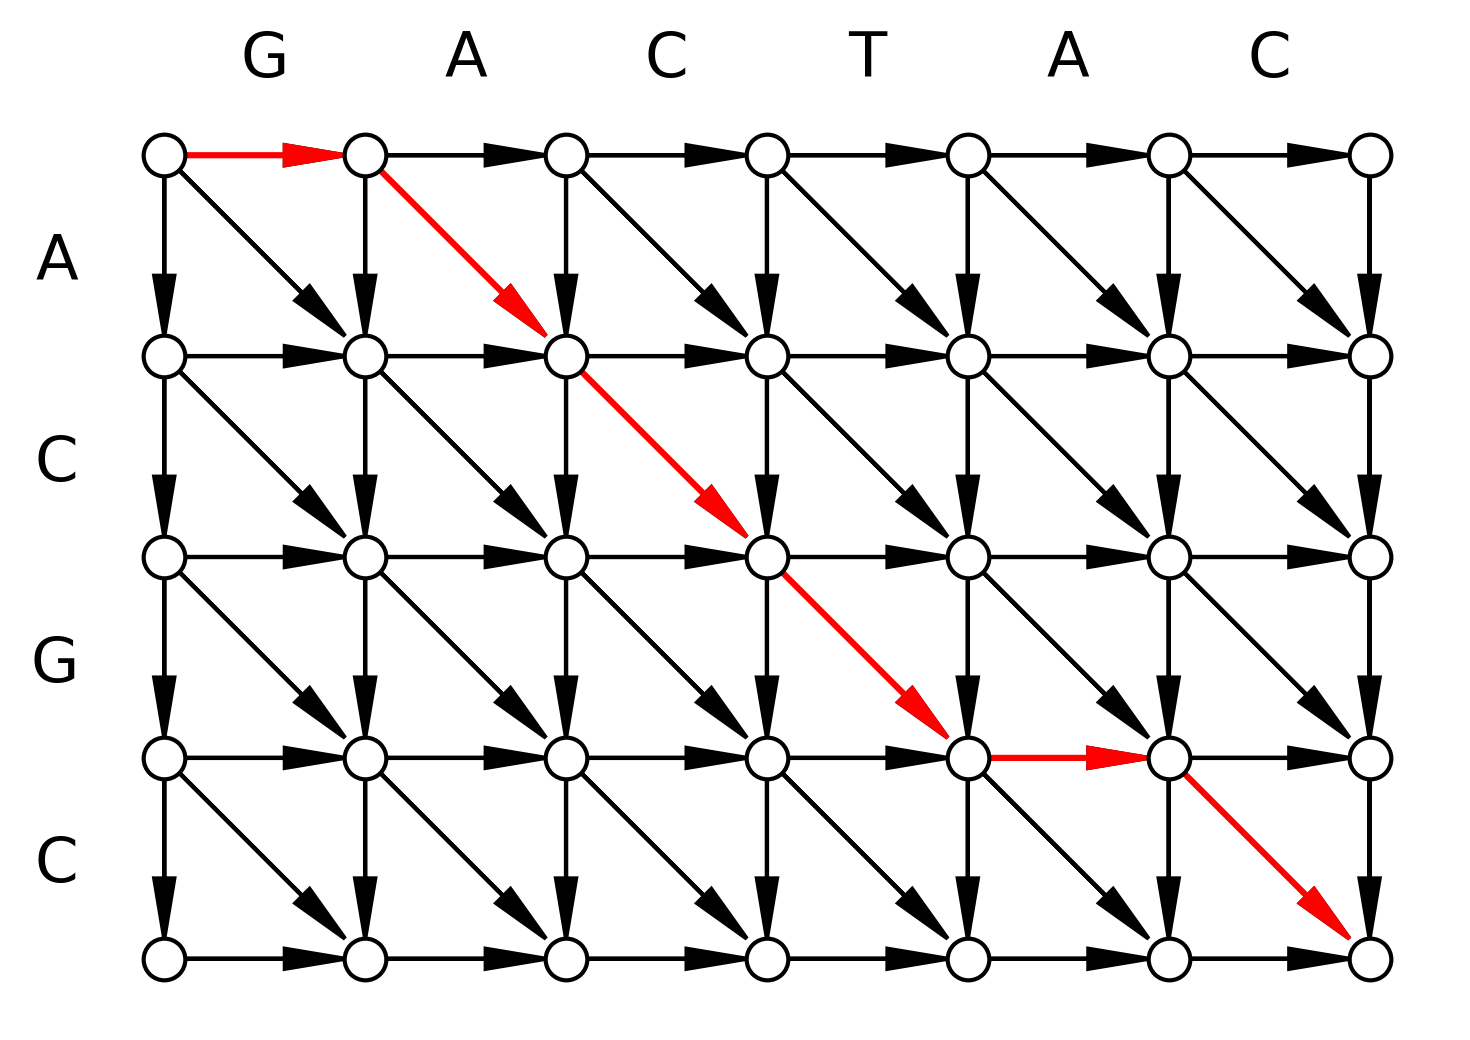

In [34]:
S1, S2 = 'ACGC', 'GACTAC'
CIGAR = 'DMMMDM'  # optimal alignment
Midx =  [0,2,3,4,6]  # length of CIGAR consumed by each prefix of S1

for m in range(len(S1)+1): 
    M = Midx[m]
    cigar = CIGAR[:M] + 'D' * (len(S2)-M)
    #input(f'Align "{S1[:m]}" with "{S2}"')
    fig, ax = plt.subplots()
    plot_path_graph(ax, S1[:m], S2)
    plot_graph_alignment(ax, S1[:m], S2, cigar)
    plt.show()

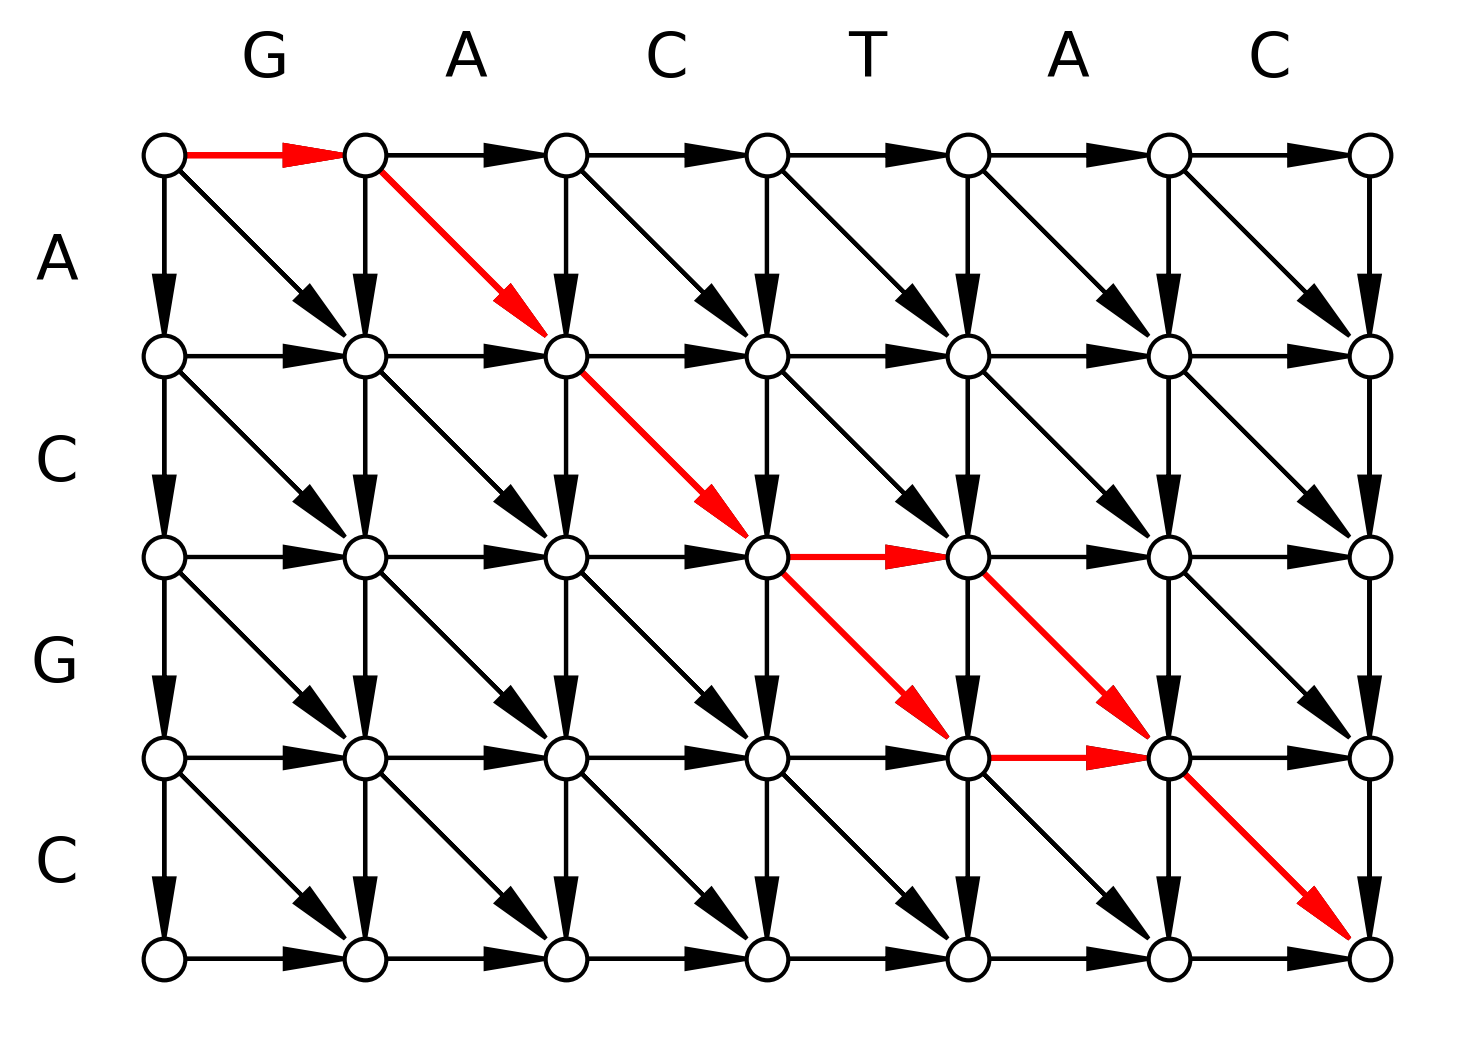

In [35]:
fig, ax = plt.subplots()
plot_path_graph(ax, S1, S2)
#plot_graph_alignment(ax, S1, S2, 'MDMIDDM')
plot_graph_alignment(ax, S1, S2, 'DMMMDM')
plot_graph_alignment(ax, S1, S2, 'DMMDMM')
# -ACG-C        -AC-GC
# GACTAC        GACTAC
plt.show()

### Needleman-Wunsch Algorithm

The [Needleman-Wunsch (NW) algorithm](https://doi.org/10.1016%2F0022-2836%2870%2990057-4) is a simple implementation of the dynamic programming solution we described. It solves the problem of **global alignment** problem.

Below we implement this algorithm in 2 ways. First, as a simple implementation of the ideas we described. Second, with some added bookkeeping variables to keep track of the path we traversed.
Given the alignment score matrix `S`, and the scoring matrix `s` we can always reconstruct the path on demand.

In [36]:
def NeedlemanWunsch(x, y, M):
    """
    Computes pairwise global alignment using dynamic programming.
    
    Arguments:
    x, y:
        sequences to align
    M: 
        scoring matrix
    
    Returns:
        Alignment score matrix.
    """
    # Initialization
    m, n = len(x) + 1, len(y) + 1
    S = np.zeros((m, n), dtype=int)
    # Base case of aligning with empty String
    for j in range(1, n):
        S[0, j] = S[0, j-1] + M('_', y[j-1])
    for i in range(1, m):
        S[i, 0] = S[i-1, 0] + M(x[i-1], '_')
    # Main Recursion
    for i in range(1, m):
        for j in range(1, n):
            S[i, j] = max(S[i-1, j-1] + M(x[i-1], y[j-1]), # diagonal
                          S[i-1, j  ] + M(x[i-1],   '_' ), # vertical
                          S[i  , j-1] + M(  '_' , y[j-1])) # horizontal
    return S

In theory we can reconstruct the alignment from the matrix `S`, we just have to start at last position and "travel back" checking each time if subtracting the corresponding edge cost matches the value of `S` at the value we land. But for ease of computation we are going to just store the predecessor for each cell in a separate variable `P`.

In [37]:
def NeedlemanWunsch(x, y, M):
    """
    Computes pairwise global alignment using dynamic programming.
    
    Arguments:
    x, y:
        sequences to align
    M: 
        scoring matrix
    
    Returns:
        S: Alignment score matrix
        P: Predecessor matrix
            - 0: start of alignment
            - 1: diagonal
            - 2: insertion
            - 3: deletion
    """
    # Initialize Variables
    m, n = len(x) + 1, len(y) + 1
    S = np.zeros((m, n), dtype=int)  # cost matrix
    P = np.zeros((m, n), dtype=int)  # predecesor matrix
    
    # Initialize 1st column/row
    for i in range(1, m):
        S[i, 0] = S[i-1, 0] + M(x[i-1], '_')
    P[1:, 0] = 2
    
    for j in range(1, n):
        S[0, j] = S[0, j-1] + M('_', y[j-1])
    P[0, 1:] = 3
    
    # Main Recursion
    for i in range(1, m):
        for j in range(1, n):
            scores = (S[i-1, j-1] + M(x[i-1], y[j-1]), # match
                      S[i-1,  j ] + M(x[i-1],   '_' ), # insertion
                      S[ i , j-1] + M(  '_' , y[j-1])) # deletion
            
            imax = np.argmax(scores)
            S[i, j] = scores[imax]
            P[i, j] = imax + 1
            
    return S, P

In [38]:
def SimpleCost(x, y):
    if x != y:
        return -1
    return 0

X, Y = "THISLINE", "ISALIGNED"
S, P = NeedlemanWunsch(X, Y, SimpleCost)

We can reconstruct the alignment from the path traversed along the graph

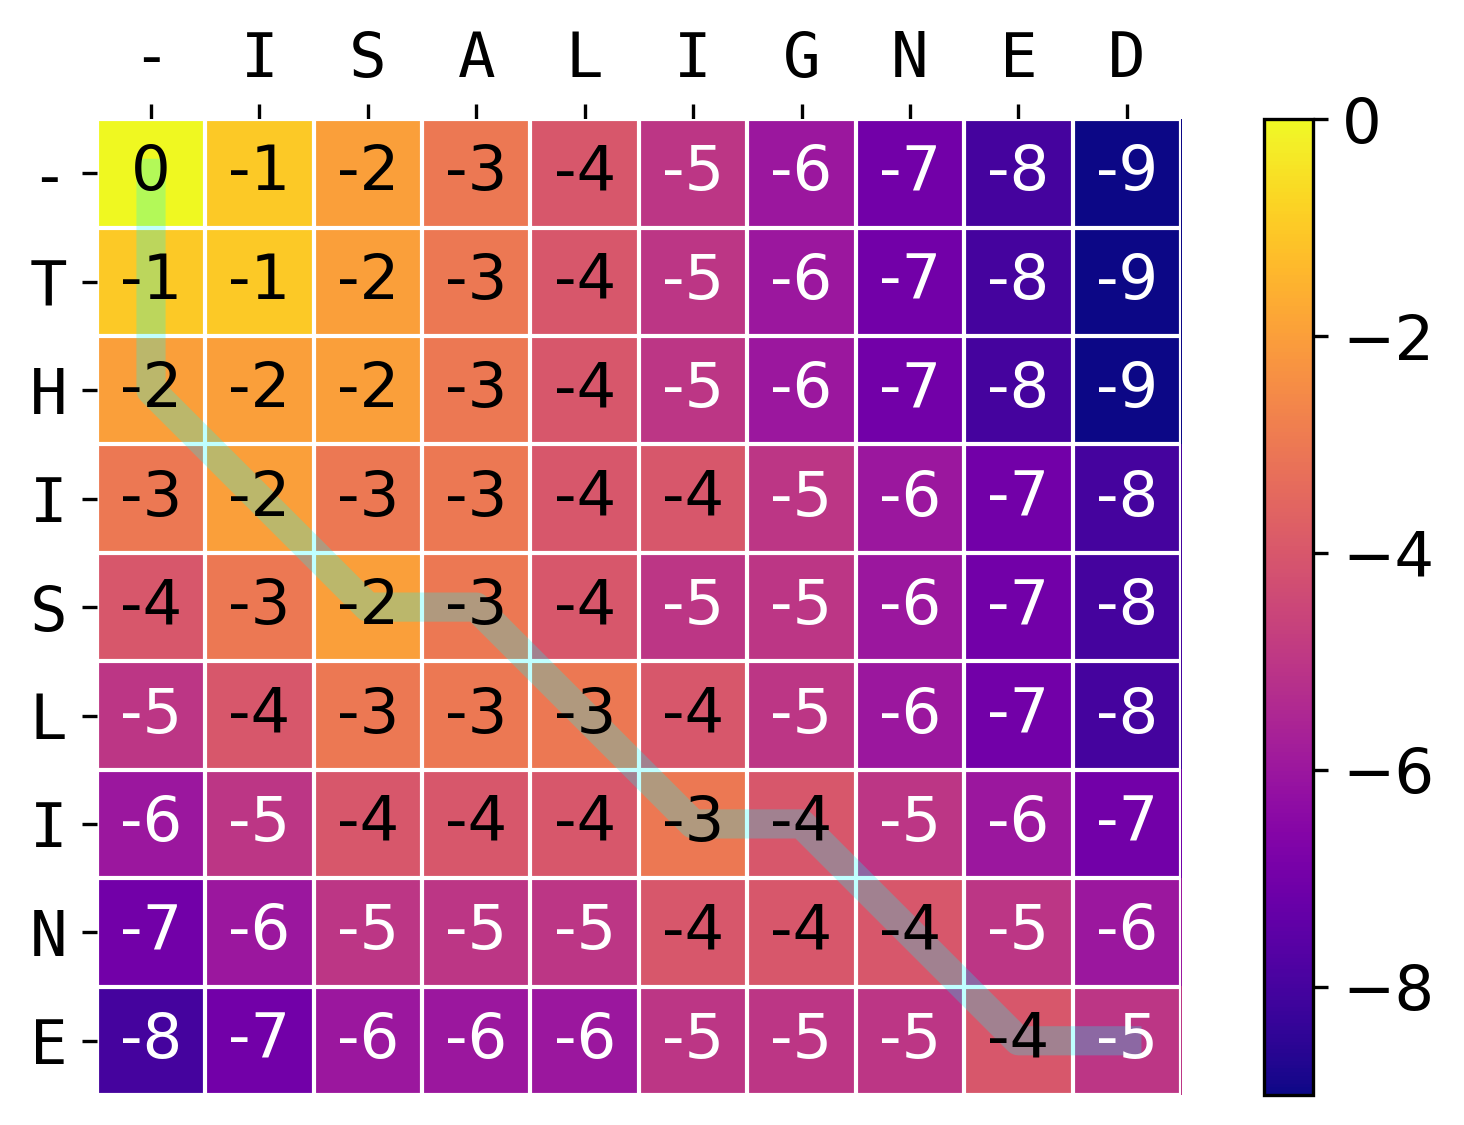

In [39]:
fig, ax = plt.subplots()
plot_alignment(ax, S, X, Y, P)
fig.tight_layout()
plt.show()

### Semi-global Algorithm

Global alignment is not suitable for finding "patterns" in a large reference as it tends to stretch the small pattern in order to find stretches that match. If we want to simulate `grep` we want an alignment that keeps the query text intact and pads it with gaps at the beginning and the end. A typical application for this is finding adapters in a read sequences like 
[Cutadapt](https://cutadapt.readthedocs.io/en/stable/algorithms.html#adapter-alignment-algorithm). 
To achieve that we modify the algorithm to perform *semi-global* alignment.

In semi-global or "cost-free-ends" alignment gaps at the end and the beginning of the alignment are not penalized. This way the resulting score is only due to the overlap region.
To achieve this 2 modification are required:

1. Initialize the first row and column with zeros. 
2. Start the trace-back from the maximum value of the last column or row. 
   This way gaps at the end are not counted.

The first modification allows the aligner to move along the 1st row or column without any cost, padding the beginning of the alignment with gaps. The second modification effectively zeroes-out the cost of gaps at the end of the alignment, by skipping the steps to last cell which can only happen along the last column/row.

Below is an algorithm that implements this idea.

In [40]:
def NeedlemanWunsch(x, y, M, algorithm="global"):
    """
    Computes pairwise global alignment using dynamic programming.
    
    Arguments:
    x, y:
        sequences to align
    M: 
        scoring matrix
    algorithm:
        either global or semib
    Returns:
        S: Alignment score matrix
        P: Predecessor matrix
            - 0: start of alignment
            - 1: diagonal
            - 2: insertion
            - 3: deletion
    """
    # Initialize Variables
    m, n = len(x) + 1, len(y) + 1
    S = np.zeros((m, n), dtype=int)  # cost matrix
    P = np.zeros((m, n), dtype=int)  # predecesor matrix
    
    # Initialize 1st column/row
    if algorithm == 'global':
        for i in range(1, m):
            S[i, 0] = S[i-1, 0] + M(x[i-1], '_')
        P[1:, 0] = 2
        for j in range(1, n):
            S[0, j] = S[0, j-1] + M('_', y[j-1])
        P[0, 1:] = 3
    elif algorithm == 'semi':
        pass
    else:
        raise ValueError(f'Unknown algorithm specified: {algorithm}')
    
    # Main Recursion
    for i in range(1, m):
        for j in range(1, n):
            scores = (S[i-1, j-1] + M(x[i-1], y[j-1]), # match
                      S[i-1,  j ] + M(x[i-1],   '_' ), # insertion
                      S[ i , j-1] + M(  '_' , y[j-1])) # deletion
            
            imax = np.argmax(scores)
            S[i, j] = scores[imax]
            P[i, j] = imax + 1
            
    return S, P

In [41]:
# TODO: compare semi to global
X, Y = 'AGCTTC', 'AGTCAGTGCGTGC'
NW_res = {'global': NeedlemanWunsch(X, Y, SimpleCost, algorithm="global"),
          'semi': NeedlemanWunsch(X, Y, SimpleCost, algorithm="semi")}

In [42]:
S, P = NW_res['global']
print_alignment(X, Y, P)

AGTCAGTGCGTGC
|| |  |   | |
AG-C--T---T-C


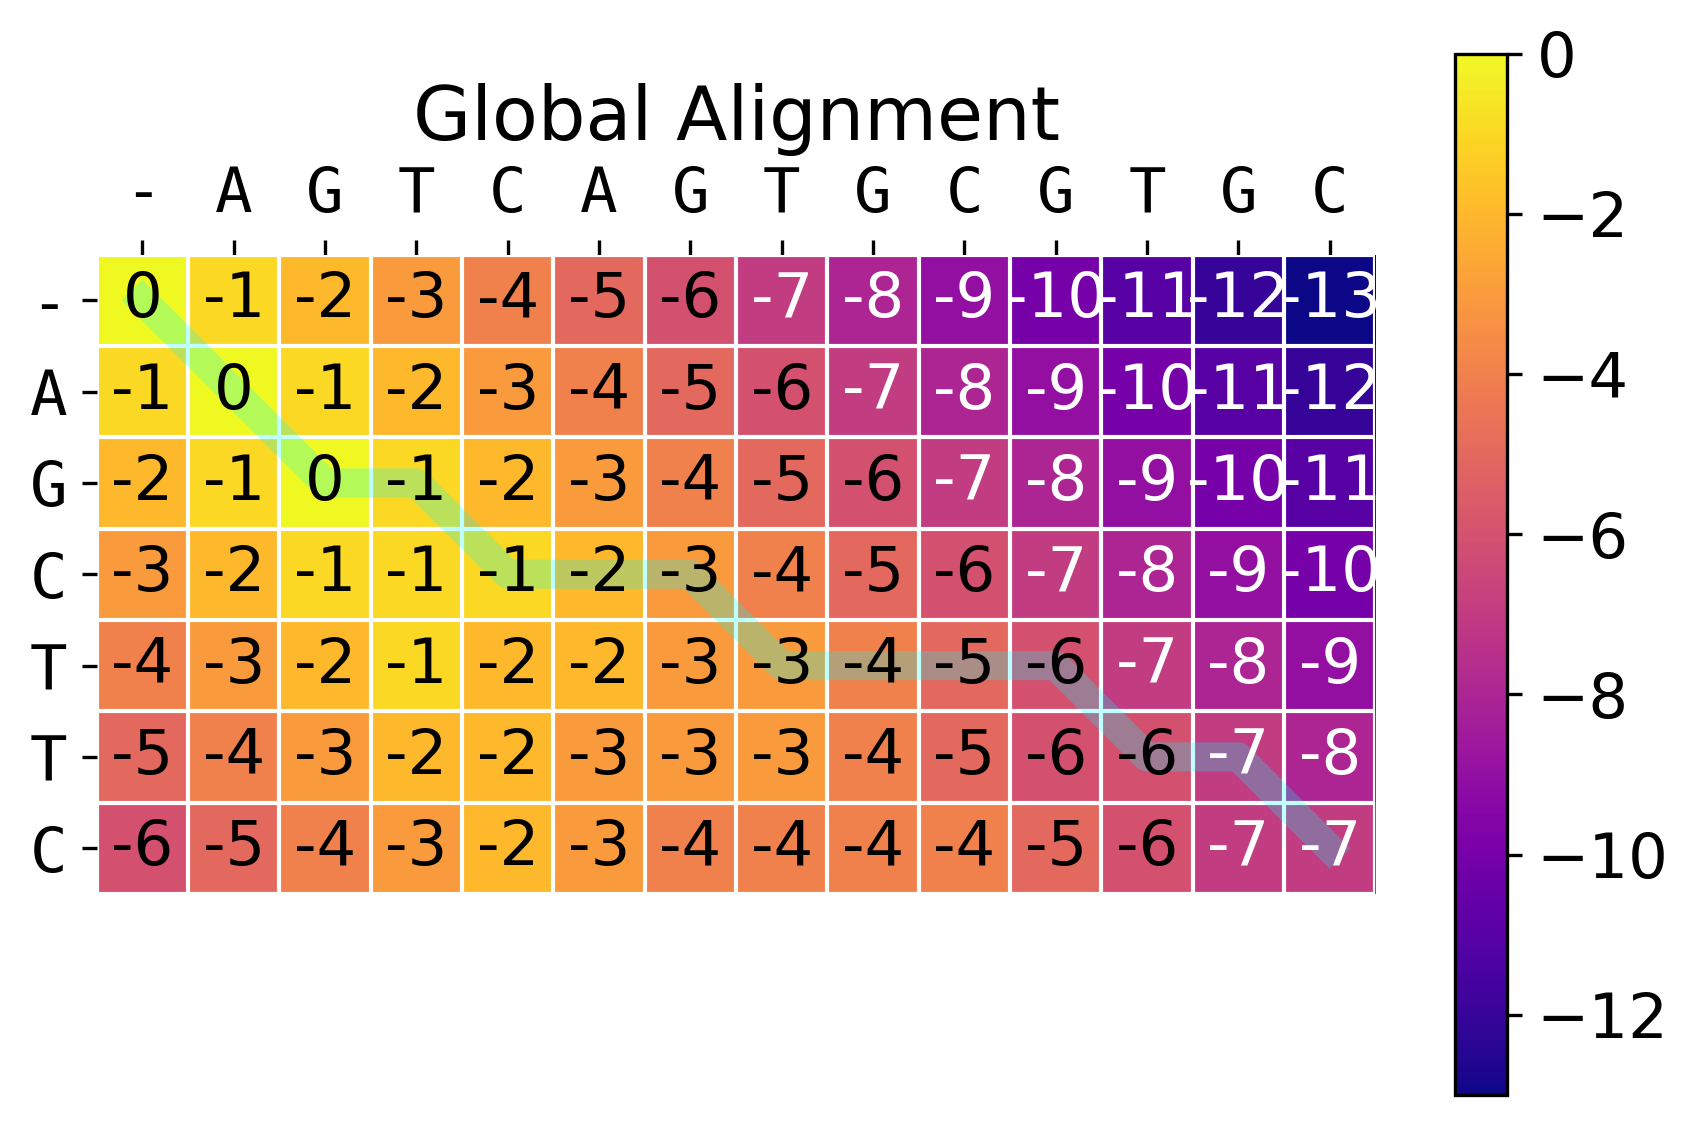

In [43]:
fig, ax = plt.subplots()
plot_alignment(ax, S, X, Y, P)
ax.set_title('Global Alignment')
fig.tight_layout()
plt.show()

In [44]:
S, P = NW_res['semi']
print_alignment(X, Y, P)

CG-TGC
 | | |
AGCTTC


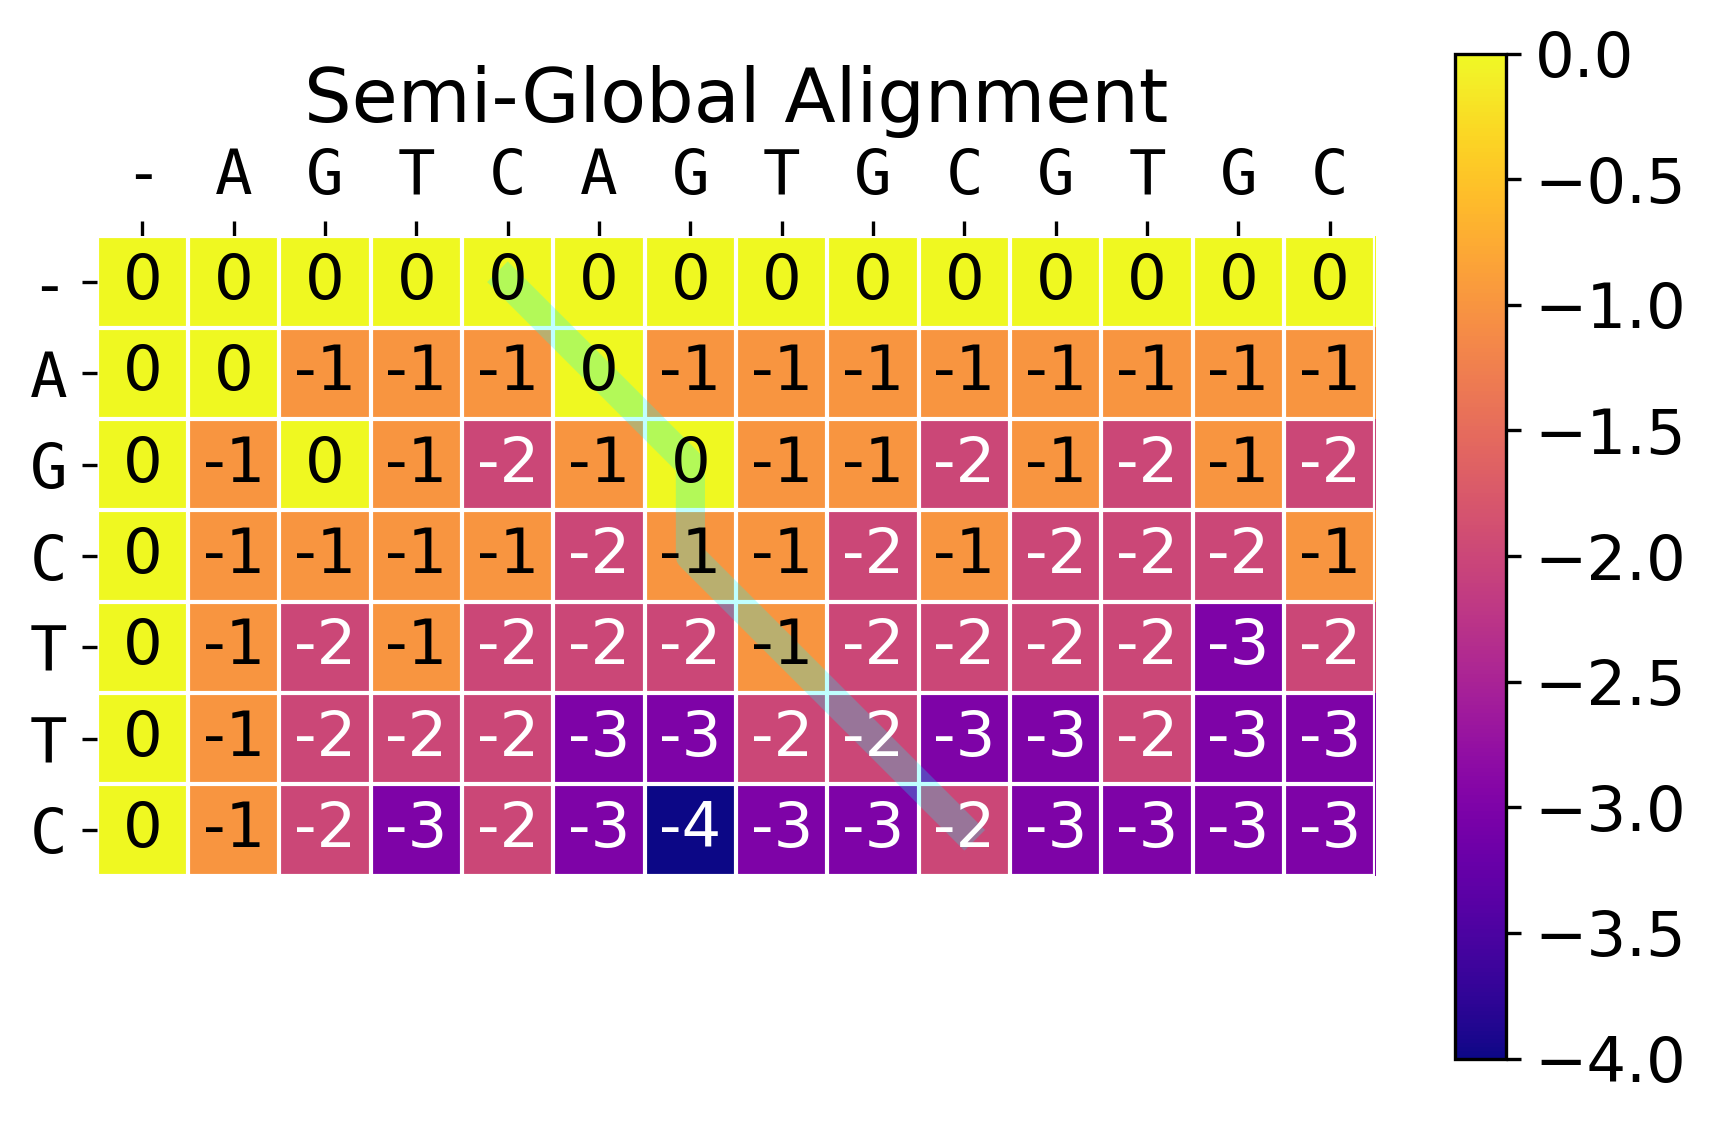

In [45]:
fig, ax = plt.subplots()
plot_alignment(ax, S, X, Y, P, best=(6, 9))
ax.set_title('Semi-Global Alignment')
fig.tight_layout()
plt.show()

### Smith-Waterman Algorithm

<p style="text-align:center;"><img src="figures/alignment_types.svg" width="600" height="600"></p>

Often we do not know in advance the functional features and instead just want to find regions of high similarity between 2 sequences that we can then characterize. This is the task of local alignment. [Smith and Waterman](https://pubmed.ncbi.nlm.nih.gov/7265238/) suggested the following 2 changes to alignment algorithm to address this problem.

1. Negative cell should be set to zero
2. Backtracking should start at the highest value of the scoring matrix `S` regardless of position and stop when a 0 is encountered.

Surprisingly, these simple changes suffice to achieve our goal.
The first modification frees up the start position, since every time the alignment turns negative it resets acting as a potential "ladder" point. The second modification frees up the end position, since the alignment is not forced to exhaust any of the two sequences. 

Unlikely the previous examples, local alignment is not a distance metric since we do not care about any of the 2 strings in particular just subsequences. As a result, we have to use a gain matrix this time that has some positive scores.

In [46]:
def SmithWaterman(x, y, M):
    # Initialize Variables
    m, n = len(x) + 1, len(y) + 1
    S = np.zeros((m, n), dtype=int)  # cost matrix
    P = np.zeros((m, n), dtype=int)  # predecesor matrix
    
    # Main Recursion
    for i in range(1, m):
        for j in range(1, n):
            scores = (0,                               # restart
                      S[i-1, j-1] + M(x[i-1], y[j-1]), # match
                      S[i-1,  j ] + M(x[i-1],   '_' ), # insertion
                      S[ i , j-1] + M(  '_' , y[j-1])) # deletion
            imax = np.argmax(scores)
            S[i, j] = scores[imax]
            P[i, j] = imax
    
    return S, P

Putting all the methods together we have the following method

In [47]:
def align(x, y, M, algorithm="global"):
    """ Calculate global alignment value of sequences x and y using
        dynamic programming.  Return global alignment value. """
    # Initialize Variables
    m, n = len(x) + 1, len(y) + 1
    S = np.zeros((m, n), dtype=int)  # cost matrix
    P = np.zeros((m, n), dtype=int)  # predecesor matrix
    
    if algorithm == 'global':
        # Initialize 1st column/row
        for i in range(1, m):
            S[i, 0] = S[i-1, 0] + M[x[i-1], '-']
        P[1:, 0] = 2

        for j in range(1, n):
            S[0, j] = S[0, j-1] + M['-', y[j-1]]
        P[0, 1:] = 3
        lb = -2**32  # it will never be picked
    elif algorithm == 'semi':
        lb = -2**32  # it will never be picked
    elif algorithm == "local":
        lb = 0
    else:
        raise ValueError(f'Unknown algorithm specified: {algorithm}')
    
    # Main Recursion
    for i in range(1, m):
        for j in range(1, n):
            scores = (lb,                              # restart
                      S[i-1, j-1] + M[x[i-1], y[j-1]], # match
                      S[i-1,  j ] + M[x[i-1],   '-' ], # insertion
                      S[ i , j-1] + M[  '-' , y[j-1]]) # deletion
            
            imax = np.argmax(scores)
            S[i, j] = scores[imax]
            P[i, j] = imax
            
    return S, P

In [48]:
# from: Biological Sequence Analysis - Durbin et al
X, Y = 'PAWHEAE', 'HEAGAWGHEE'
res = {'global': align(X, Y, BLOSUM62, algorithm="global"),
       'local': align(X, Y, BLOSUM62, algorithm="local")}

In [49]:
S, P = res['global']
print_alignment(X, Y, P)

HEAGAWGHE-E
    || || |
--P-AW-HEAE


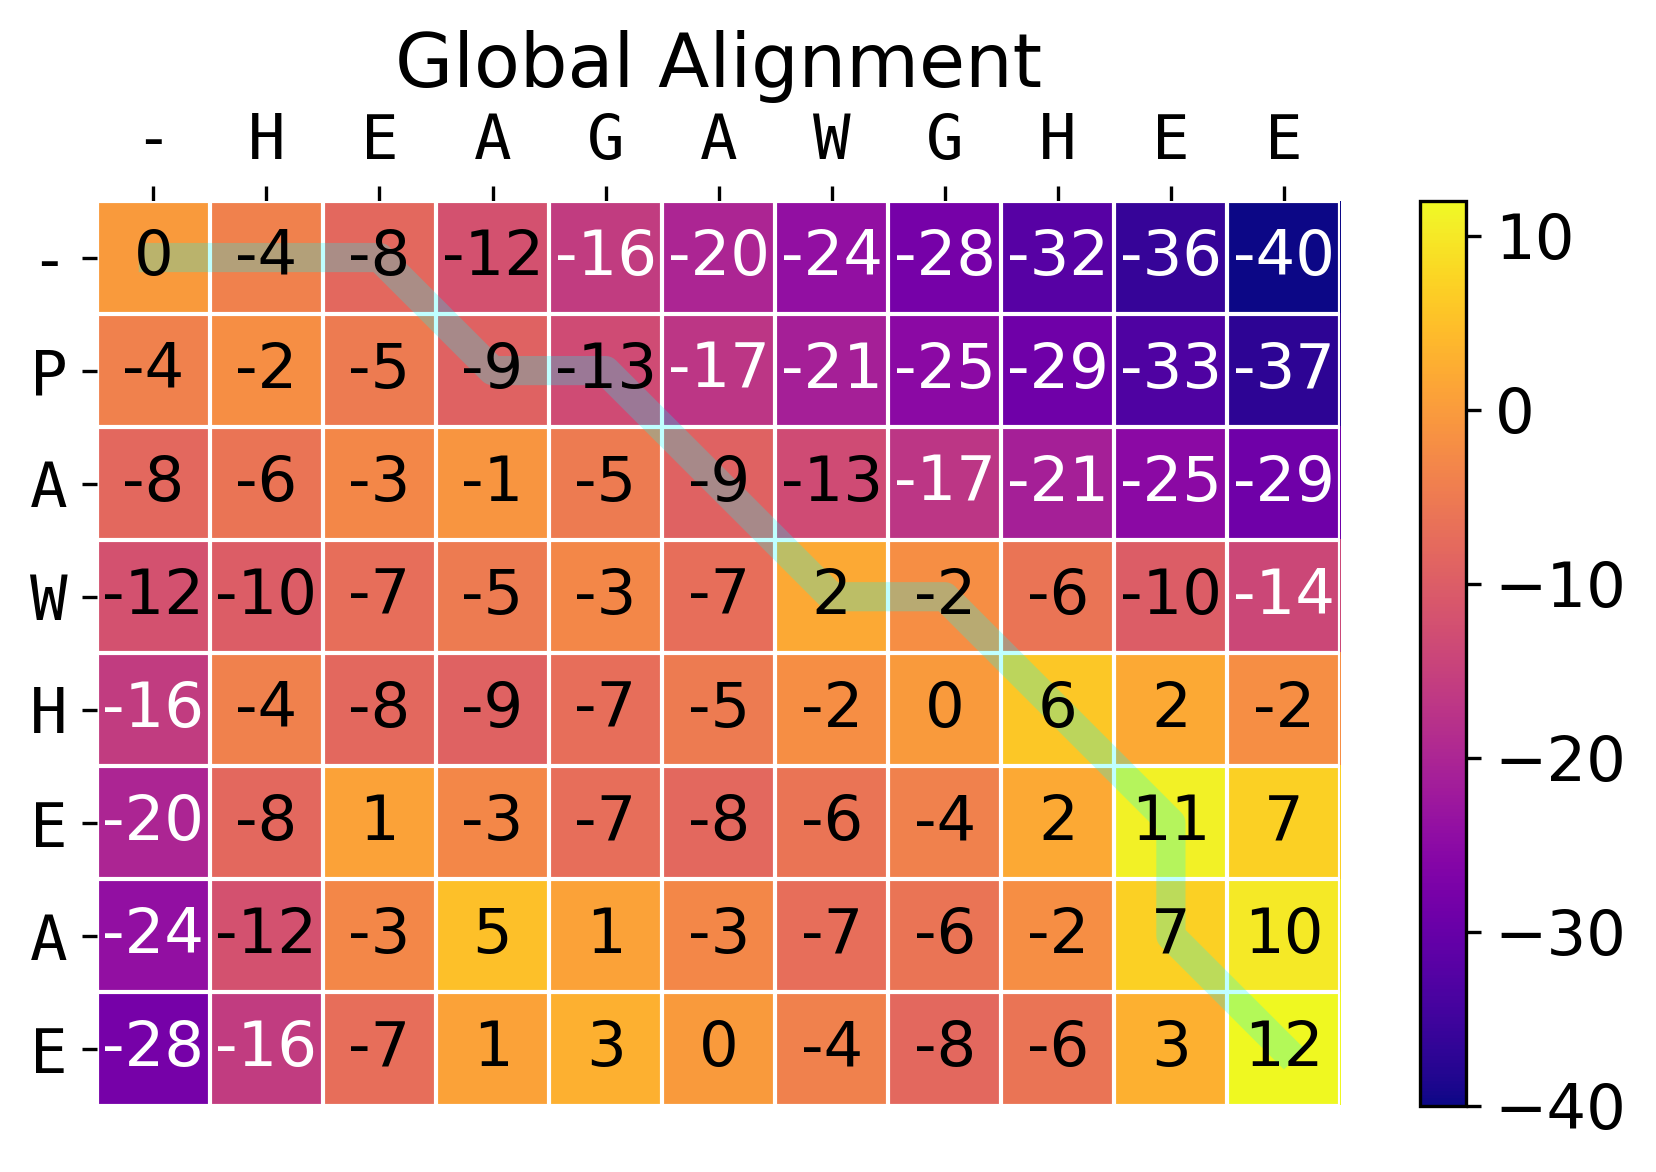

In [50]:
fig, ax = plt.subplots()
plot_alignment(ax, S, X, Y, P, pathcolor='cyan')
ax.set_title('Global Alignment')
fig.tight_layout()
plt.show()

In [51]:
S, P = res['local']
best = S.argmax()
print_alignment(X, Y, P, best)

AWGHE-E
|| || |
AW-HEAE


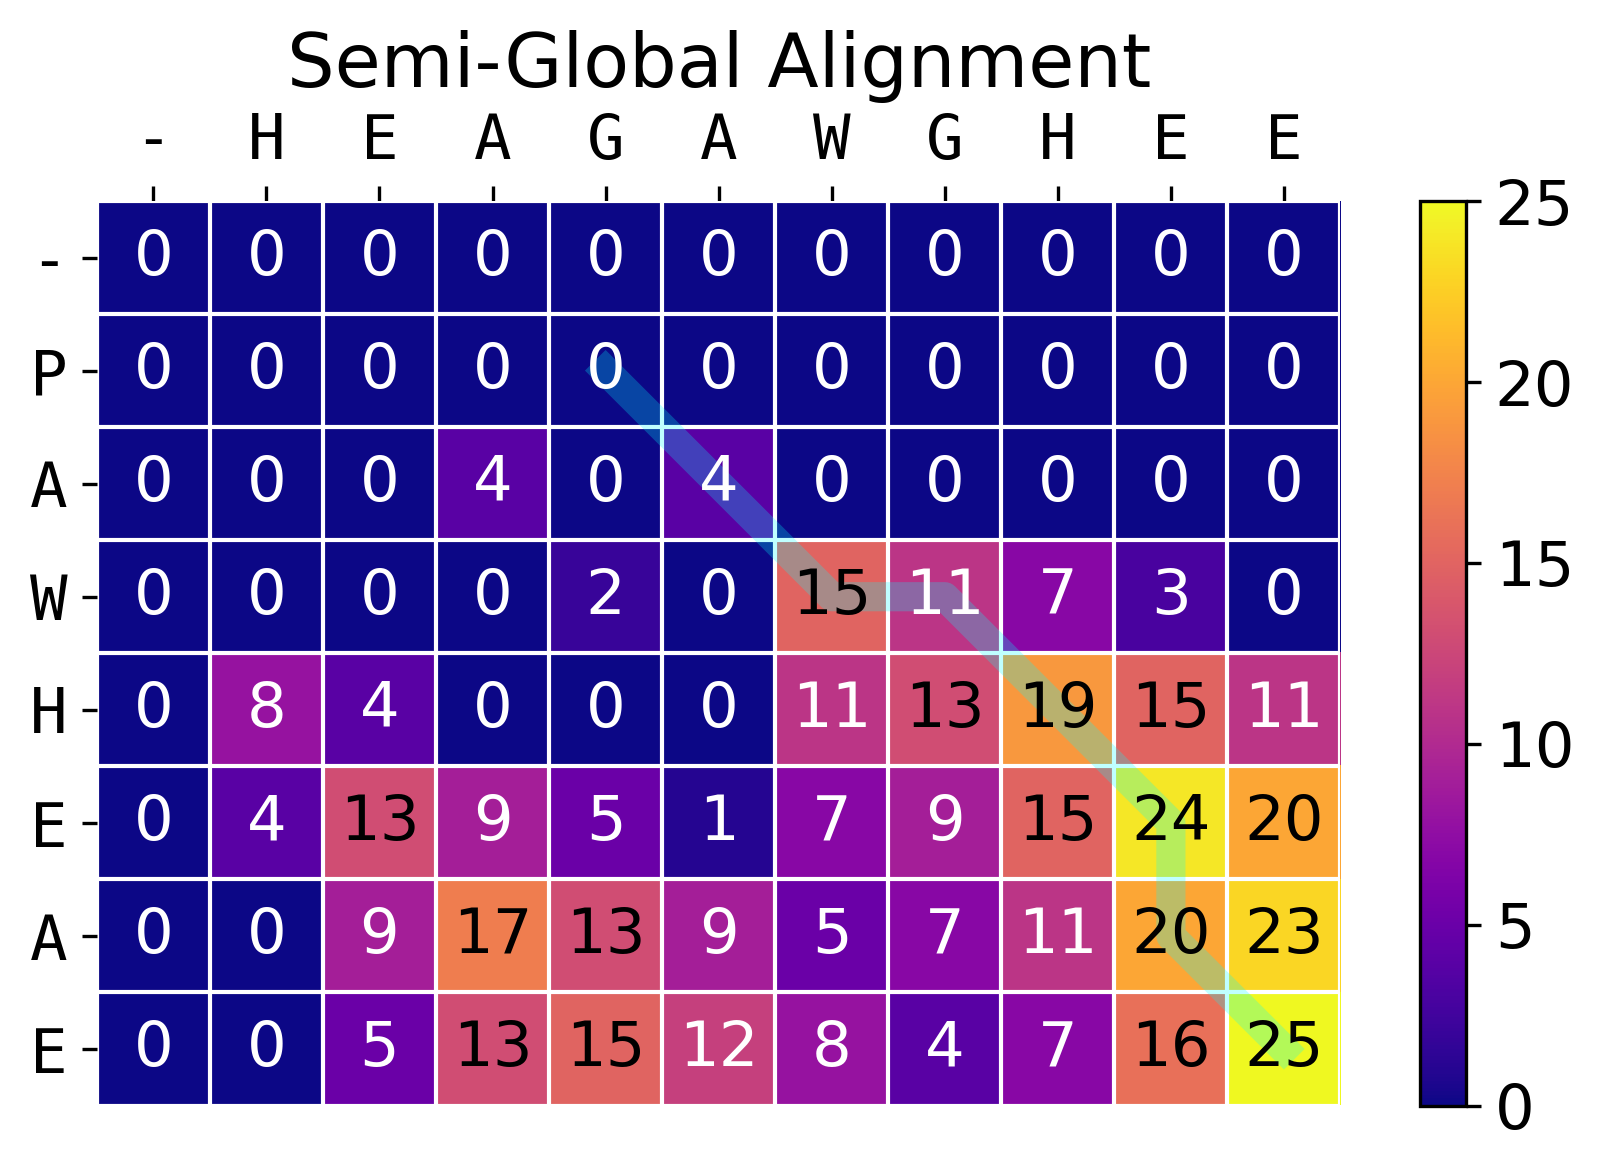

In [52]:
fig, ax = plt.subplots()
plot_alignment(ax, S, X, Y, P, best=best, pathcolor='cyan')
ax.set_title('Semi-Global Alignment')
fig.tight_layout()
plt.show()

### Generalized Gap Score

So far we were implicitly considering a linear gap penalty function, ie every gap costs the same to the alignment score. This means that there is no difference between *opening* a gap and *extending* an existing gap. Biologically this is not a realistic assumption, we expect gap generating events to be relatively rare but once they occur they can cause a range of gaps. 

So we would like to differentiate between gap opening cost (which we expect to be higher) and gap extending cost (which we expect to be lower). To achieve the desired behavior and penalize spurious gaps, we have to use a penalty that is a *convex* function of gap length. A typical convex function is the $\log$ that increases steeply for small values of $x$ but then slows down for larger values. 

However, using a convex function requires us to keep track of where the gap was opened in order to compute it and thus our algorithm looses its *locality*, ie we cannot just do a single comparison to decide whether to introduce a gap but we have to compute all possible lengths, which may have a significant effect in performance. 

A compromise between a convex and the linear cost function is to simply differentiate between gap opening and gap extending cost which only requires us to perform 2 comparisons, 1 for opening a gap and 1 for extending. This results in an **affine** cost function, ie linear function plus intercept (a strictly linear function cannot "move" the origin but when speaking loosely people do not differentiate the 2).

$$ G(\text{gap}) = C_{\text{open}} + C l_{\text{gap}}$$

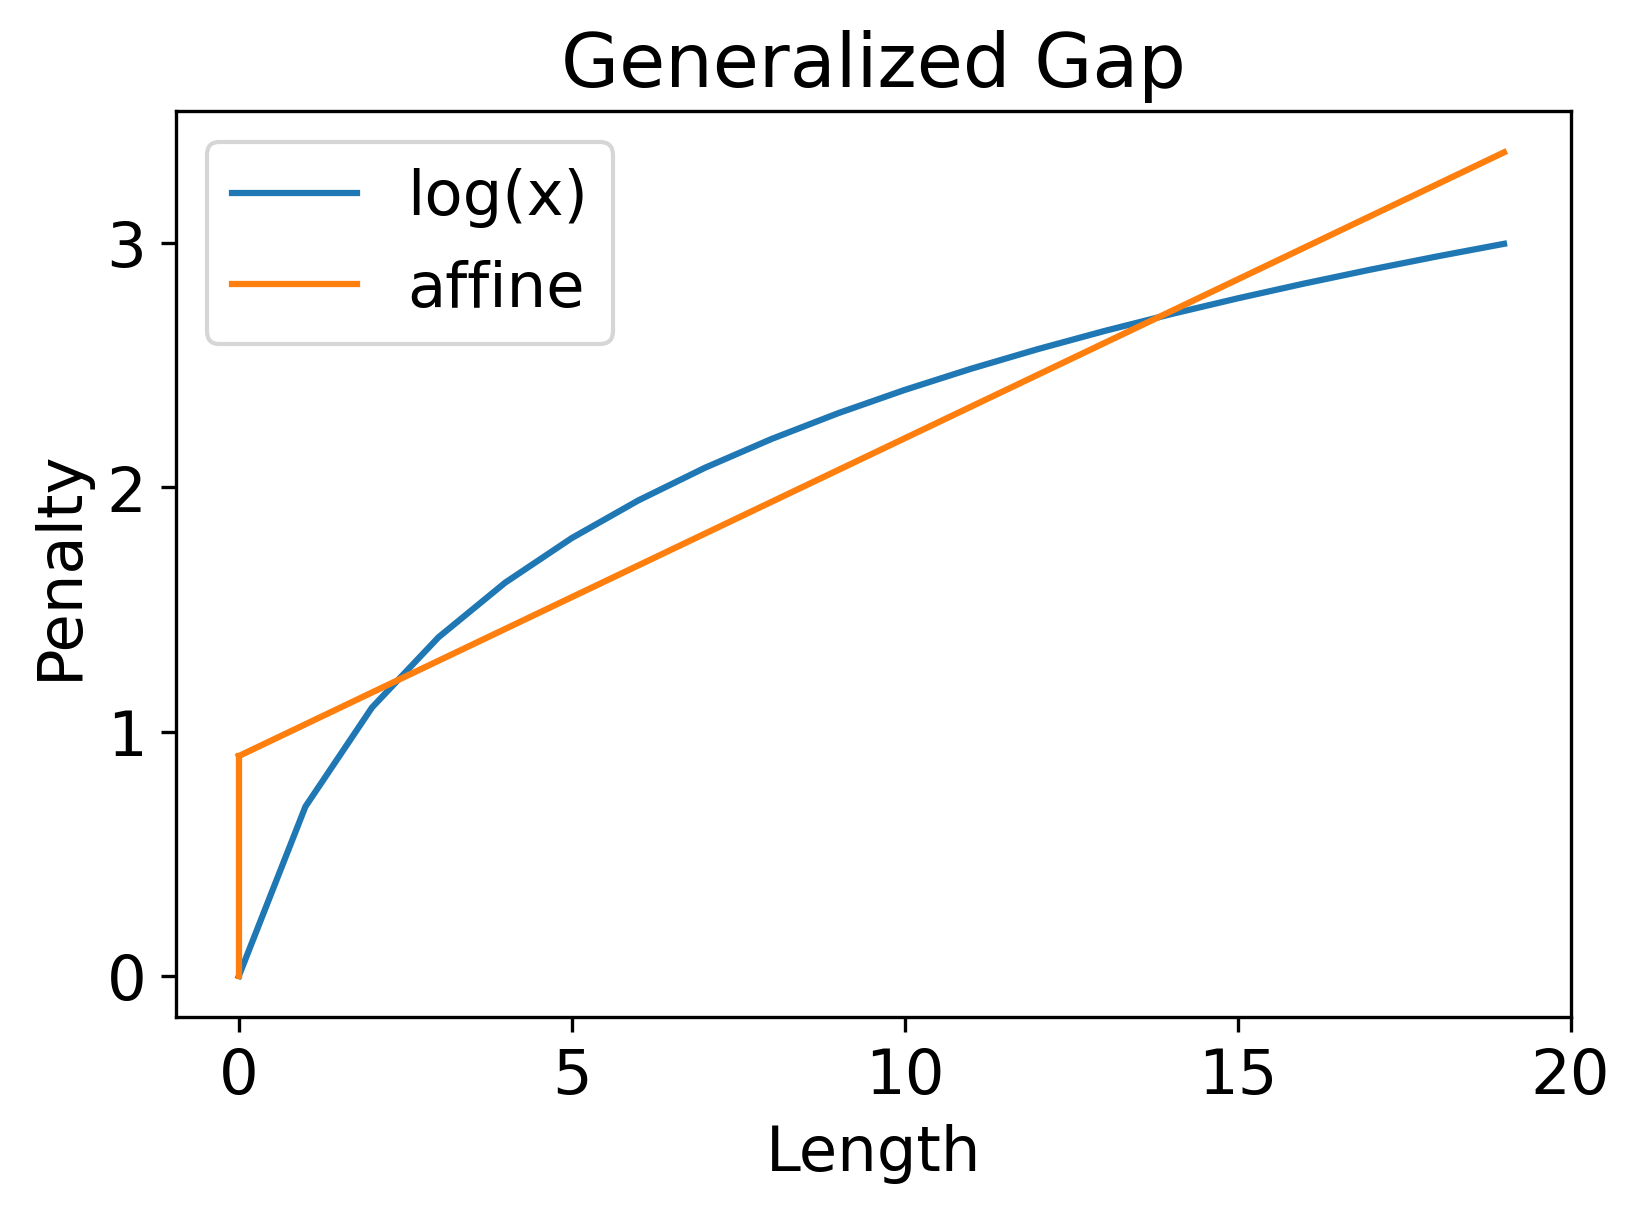

In [53]:
x = 1 + np.arange(20)
plt.plot(x-1, np.log(x), color='C0', label='log(x)')
plt.plot(x-1, 0.77 + .13*x, color='C1', label='affine')
plt.plot([0, 0], [0, .9], color='C1')
plt.ylabel('Penalty')
plt.xlabel('Length')
plt.title('Generalized Gap')
plt.xticks([0, 5, 10, 15, 20])
plt.yticks(np.arange(4))
plt.legend()
plt.show()

In [54]:
def SmithWaterman(x, y, M, gapOpen, gapExtend):
    m, n = len(x) + 1, len(y) + 1
    S = np.zeros((m, n), dtype=int)  # score matrix
    D = np.zeros((m, n), dtype=int)  # deletion matrix
    I = np.zeros((m, n), dtype=int)  # insertion matrix
    P = np.zeros((m, n), dtype=int)  # predecesor matrix
    
    for i in range(1, m):
        for j in range(1, n):
            D[i, j] = max(S[i, j-1] - gapOpen,   # open a deletion gap
                          D[i, j-1] - gapExtend) # extend opened deletion gap
            I[i, j] = max(S[i-1, j] - gapOpen,   # open a insertion gap
                          D[i-1, j] - gapExtend) # extend opened insertion gap
            scores  = (0,
                       S[i-1, j-1] + M[x[i-1], y[j-1]],
                       I[i, j],
                       D[i, j])
            imax = np.argmax(scores)
            S[i, j] = scores[imax]
            P[i, j] = imax
    return S, P

In [55]:
# from: Biological Sequence Analysis - Durbin et al
X, Y = 'PAWHEAE', 'HEAGAWGHEE'
res = {'linear': SmithWaterman(X, Y, BLOSUM62, gapOpen=4, gapExtend=4),  # open == extend
       'affine': SmithWaterman(X, Y, BLOSUM62, gapOpen=8, gapExtend=4)}

In [56]:
S, P = res['linear']
best = S.argmax()
print_alignment(X, Y, P, best)

AWGHE-E
|| || |
AW-HEAE


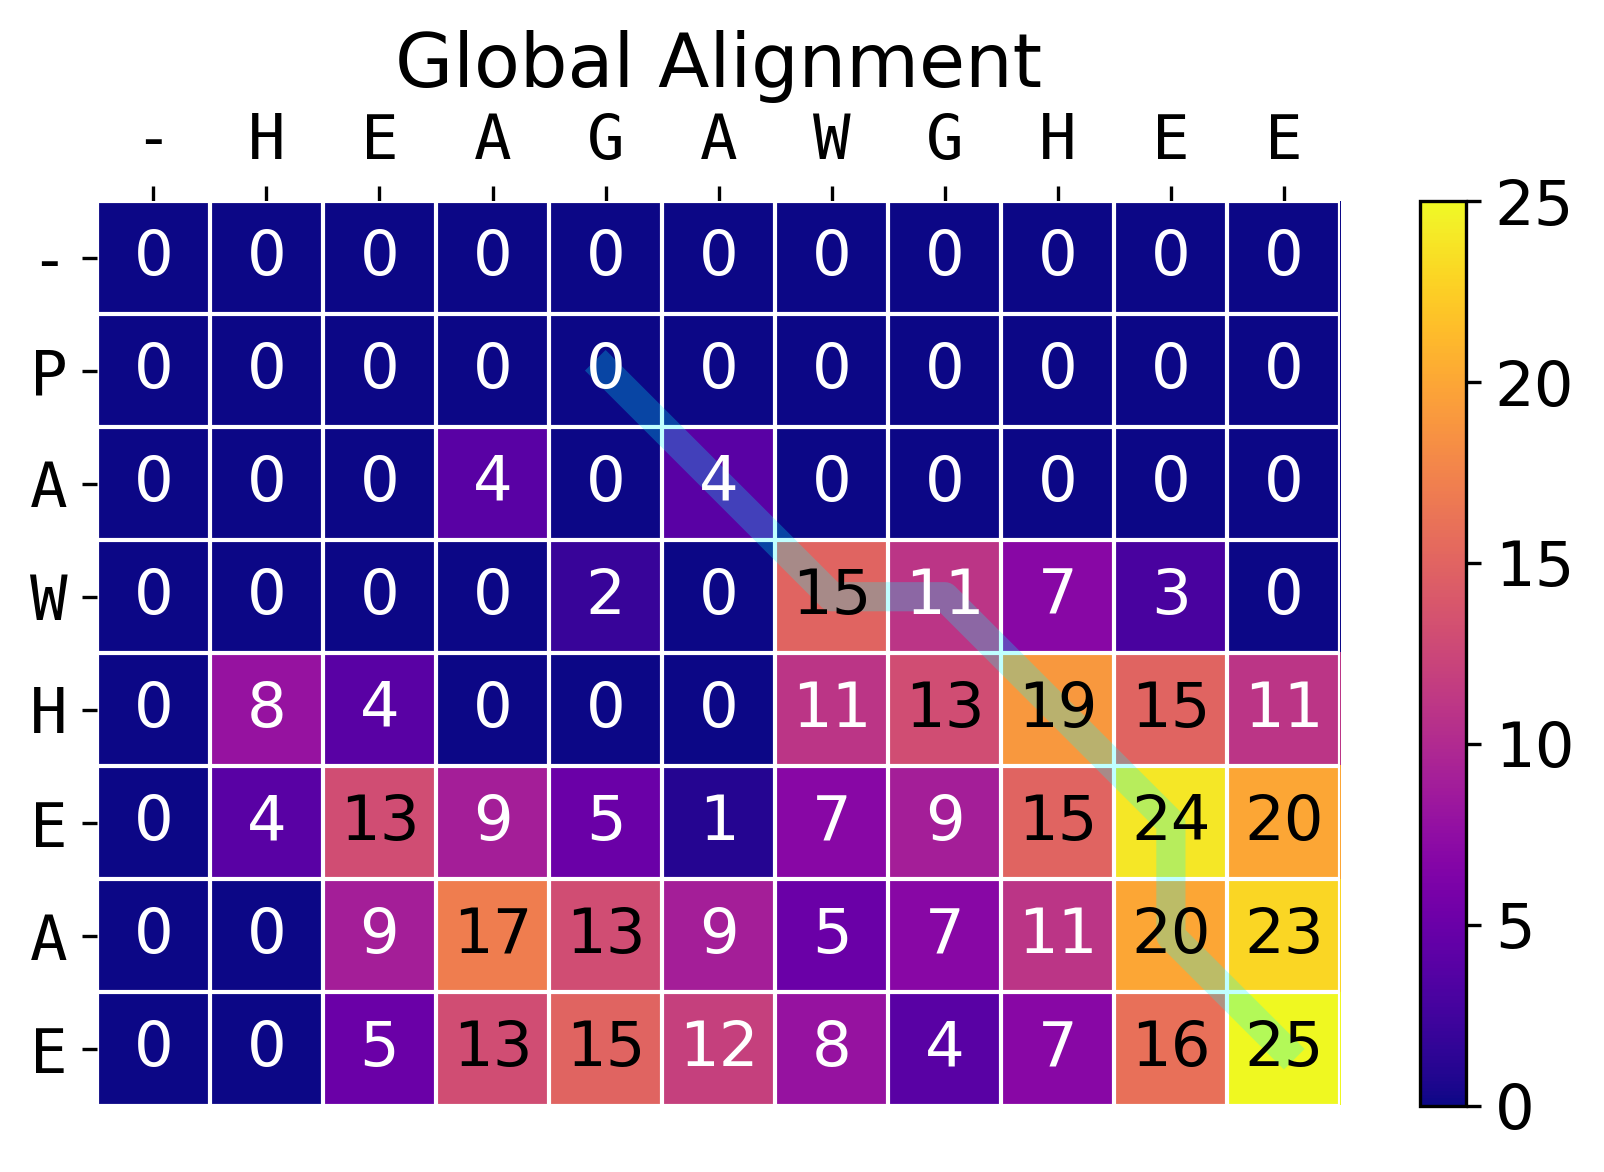

In [57]:
fig, ax = plt.subplots()
plot_alignment(ax, S, X, Y, P, best=best, pathcolor='cyan')
ax.set_title('Global Alignment')
fig.tight_layout()
plt.show()

In [58]:
S, P = res['affine']
best = S.argmax()
print_alignment(X, Y, P, best)

AWGHE
|| ||
AW-HE


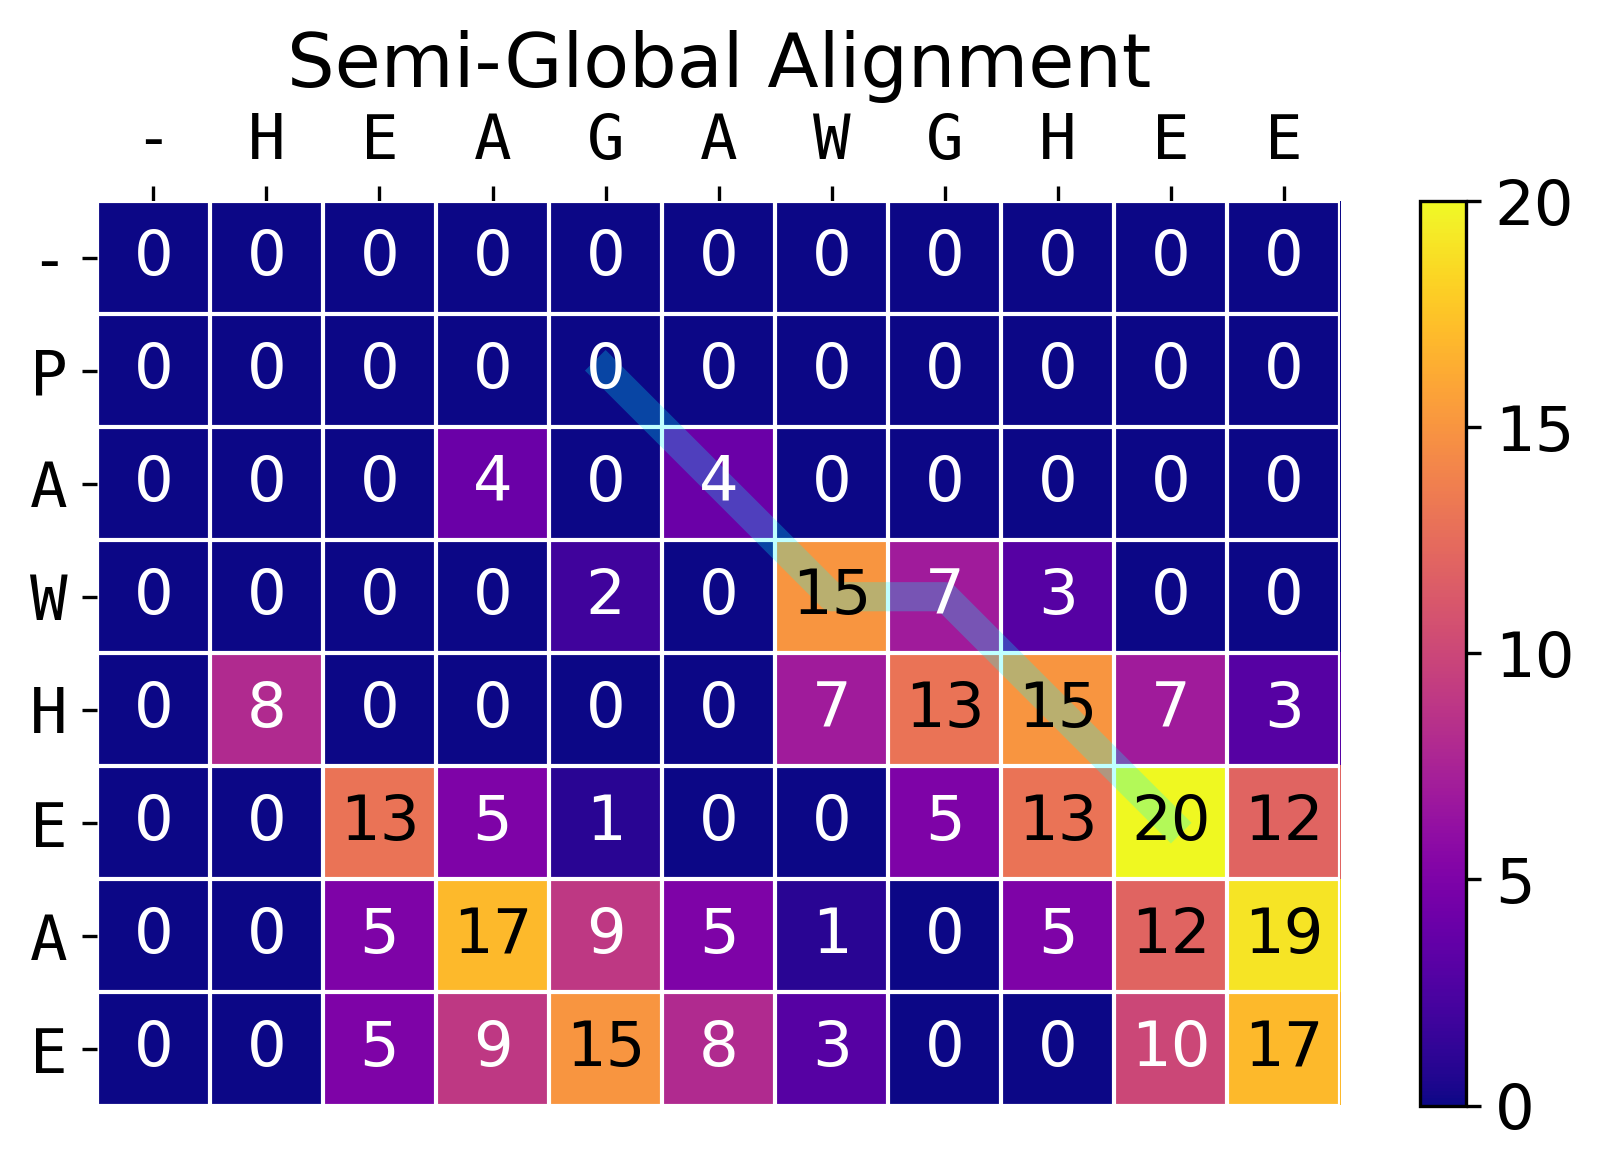

In [59]:
fig, ax = plt.subplots()
plot_alignment(ax, S, X, Y, P, best=best, pathcolor='cyan')
ax.set_title('Semi-Global Alignment')
fig.tight_layout()
plt.show()

## BLAST

The [updated BLAST](https://doi.org/10.1093/nar/25.17.3389) algorithm is again a *seed & extend* like the original we described. It introduced 3 major updates:

1. It uses the Smith-Waterman algorithm instead of original un-gapped alignment extension
2. It uses a different scheme to find seeds
3. It introduced the option of repeated search that refine the results by updating the scoring matrix.

![](figures/blast2.svg)

### Two Hit Method

To find candidate seeds for extension the new algorithm requires 2 word (k-mer) hits instead of one. The 2 hits have to be along the same diagonal (so no gaps between them just substitutions) and within a pre-specified distance of each other (`A=40`). To compensate for the loss of sensitivity by this stricter criterion, the algorithm lowers the threshold for calling a hit (by default from 13 to 11).

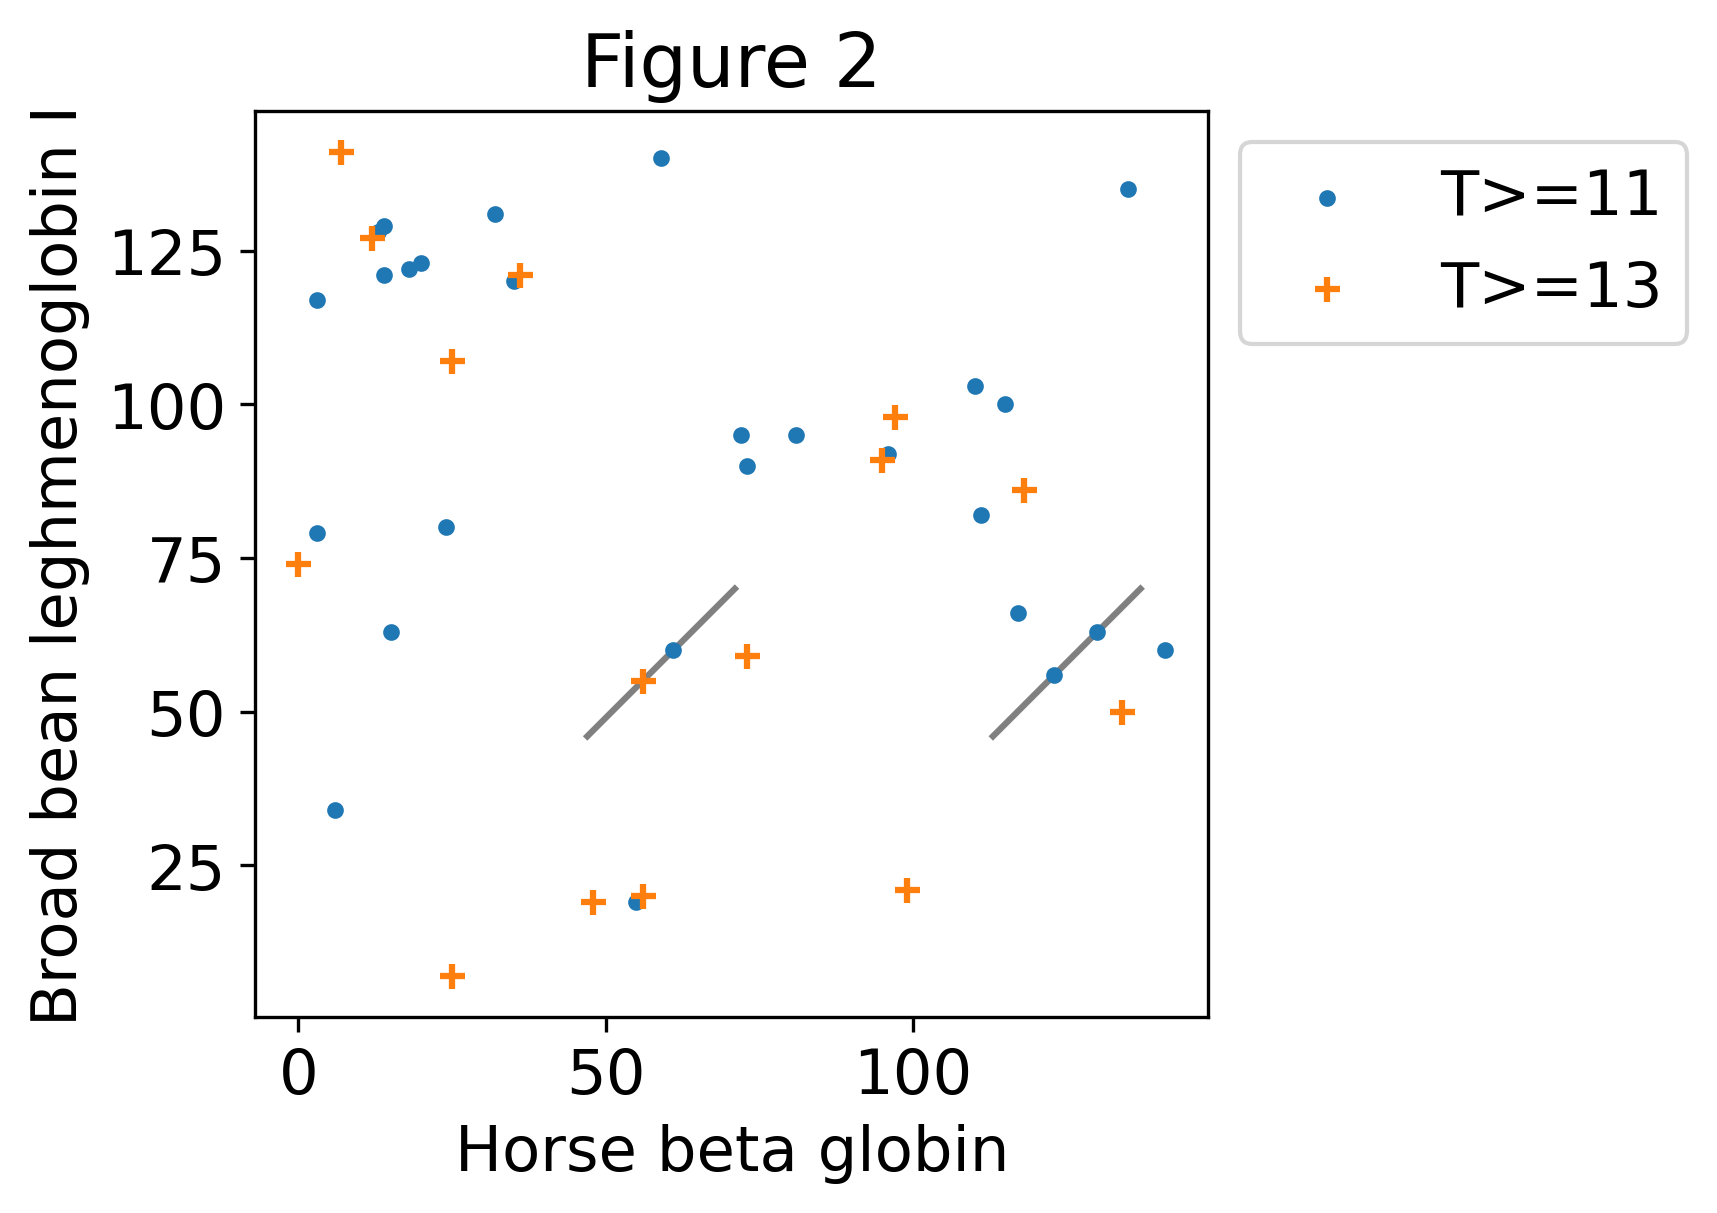

In [60]:
horse_hbb    = 'VQLSGEEKAAVLALWDKVNEEEVGGEALGRLLVVYPWTQRFFDSFGDLSNPGAVMGNPKVKAHGKKVLHSFGEGVHHLDNLKGTFAALSELHCDKLHVDPENFRLLGNVLVVVLARHFGKDFTPELQASYQKVVAGVANALAHKYH'
soybean_hbb  = 'MGFTEKQEALVNSSSQLFKQNPSNYSVLFYTIILQKAPTAKAMFSFLKDSAGVVDSPKLGAHAEKVFGMVRDSAVQLRATGEVVLDGKDGSIHIQKGVLDPHFVVVKEALLKTIKEASGDKWSEELSAAWEVAYDGLATAIKAA'

y = np.array([56, 60]) + np.array([-1, 1]) * 10  # diag = -1
plt.plot(y+1, y, color='gray', zorder=1)
x = np.array([56, 63]) + np.array([-1, 1]) * 10  # diag = -67
plt.plot(y+67, y, color='gray', zorder=1)

dot = dot_matrix(X=horse_hbb, Y=soybean_hbb, M = BLOSUM62, k=3)
ix, iy = np.where(np.logical_and(dot >= 11, dot < 13))
iext = np.append([True], ~np.logical_and(np.diff(iy - ix) == 0, np.diff(ix) < 3))
plt.scatter(ix[iext], iy[iext], marker='.', label='T>=11', zorder=2)
ix, iy = np.where(dot >= 13)
iext = np.append([True], ~np.logical_and(np.diff(iy - ix) == 0, np.diff(ix) < 3))
plt.scatter(ix[iext], iy[iext], marker='+', label='T>=13', zorder=2)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.xlabel('Horse beta globin')
plt.ylabel('Broad bean leghmenoglobin I')
plt.title('Figure 2')
plt.gca().set_aspect('equal')
plt.show()

### 2D Xdrop

As we saw, the SW algorithm has the ability to auto-reset with regards to alignment. However it keeps exploring all possible alignments which for a database search is infeasible. To address this issue, BLAST employs 2 strategies:

1. It limits the search to a [band of diagonals](https://ieeexplore.ieee.org/document/8445105)
   surrounding the main
2. It stops search early if the alignment score drops a fixed amount from currently optimal value.

![](figures/smith_waterman_heuristics.svg)

### Extreme Value Statistic

With regards to statistical properties of the gapped-alignment scores the basic theory that we sketched before still applies. However, there is one key difference from the previous analysis.
In the un-gapped analysis, we were forced to match our random sequences character by character which allowed us to model the score as a sum of random variables. In the case of gapped alignment however we have a choice (to introduce gaps) and we use it to *maximize* the score so the standard statistical analysis (central limit etc) does not apply here. Although there are theoretical no guarantees, in practice it has been shown that random gapped-scores are approximated well by the [Gumbel distribution](https://en.wikipedia.org/wiki/Gumbel_distribution) which is common for maximum values statistics. So we can practically swap the Poisson distribution of the ungapped analysis with the Gumbel and keep the E-value statistic but we have to 
[adjust the way we calculate](https://www.doi.org/10.1214/08-AOS663) $\lambda$ and $K$.

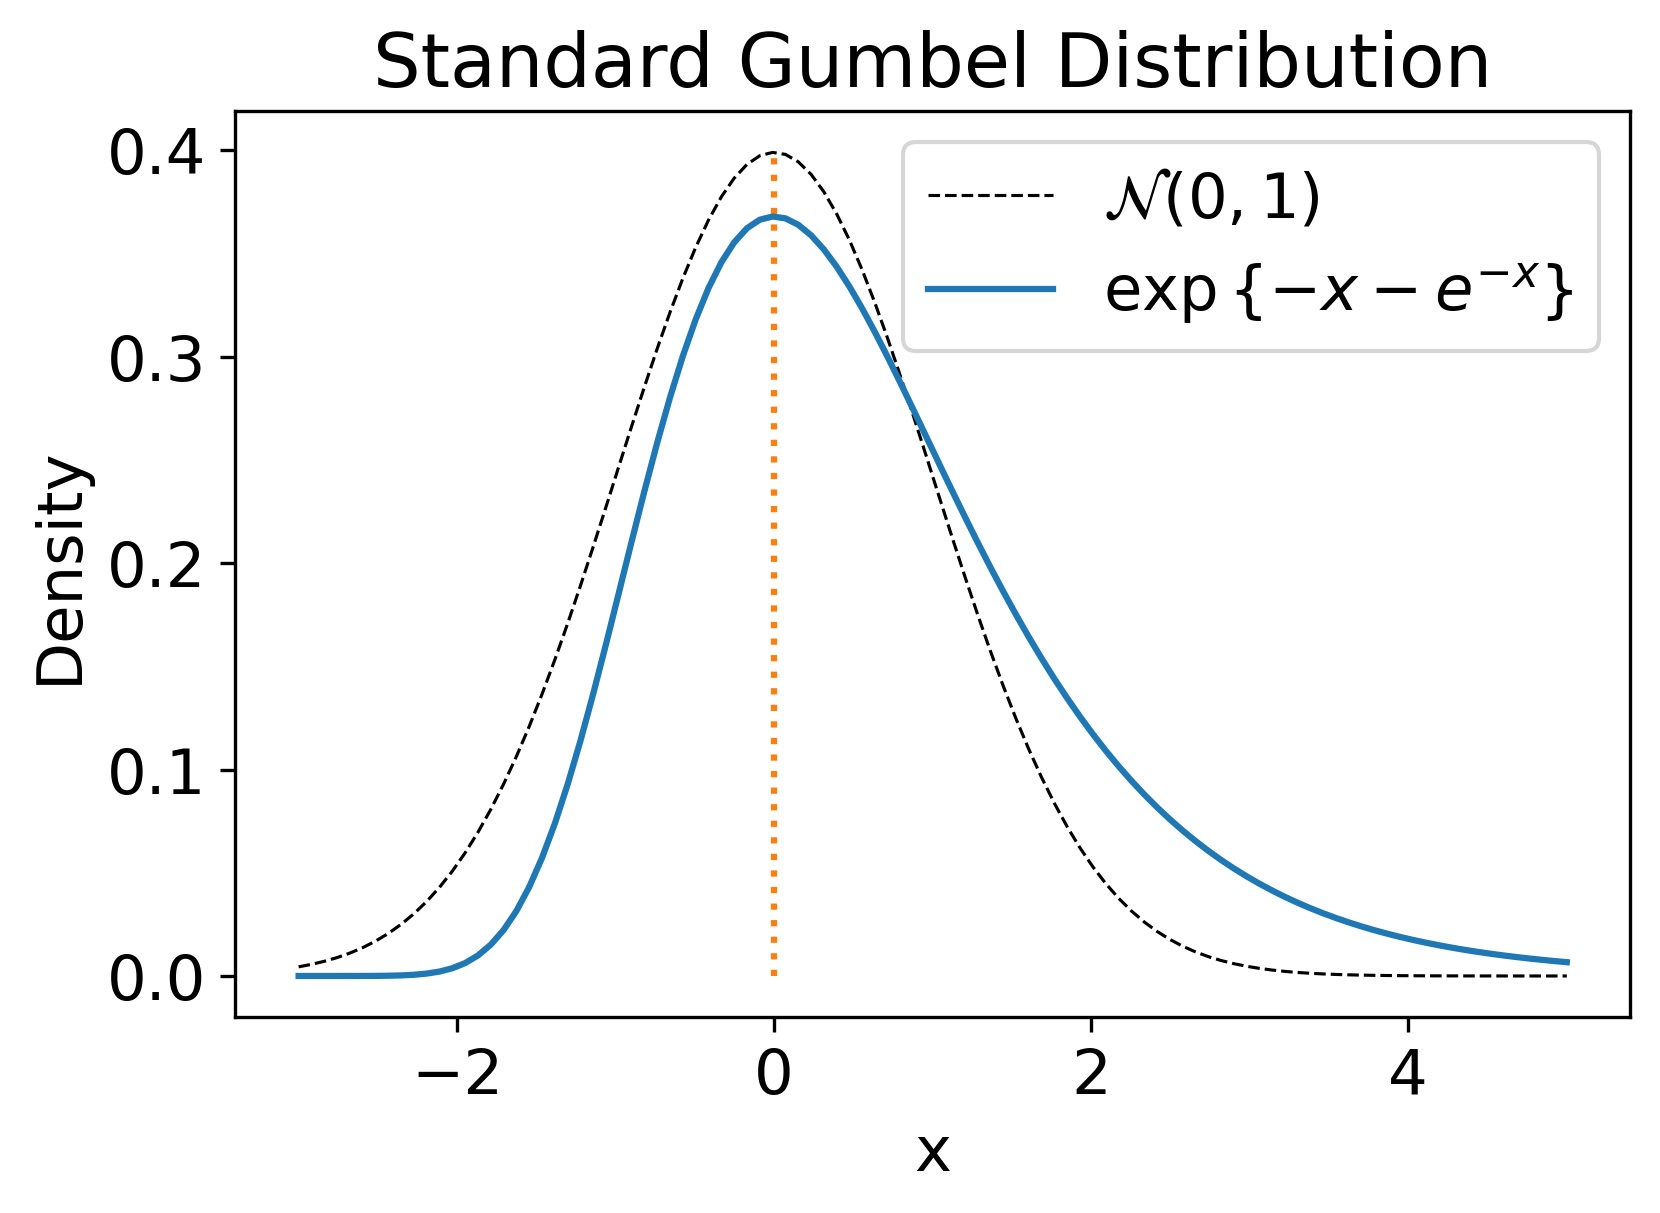

In [61]:
def dgumbel(x, scale=1., loc=0.):
    z = (x - loc) / scale  # z-score
    return np.exp(-z - np.exp(-z))/scale

def dnorm(x, scale=1., loc=0.):
    z = (x - loc) / scale  # z-score
    const = np.sqrt(2*np.pi) * scale  # normalizing constant
    return np.exp(-0.5 * z**2) / const

x = np.linspace(-3, 5, num=100)
plt.vlines(0., 0., dnorm(0.), color='C1', linestyles='dotted')
plt.plot(x, dnorm(x), '--k', label='$\mathcal{N}(0, 1)$', linewidth=.75)
plt.plot(x, dgumbel(x), label='$\exp\{-x-e^{-x}\}$', color='C0')
plt.legend()
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Standard Gumbel Distribution')
plt.show()

### BLAST Variants

![blast commands](https://open.oregonstate.education/app/uploads/sites/6/2016/10/I.7_2_blast_types.png#fixme)

## Resources

Obviously you do not have to write these algorithms yourselves:

- [BLAST Online](https://blast.ncbi.nlm.nih.gov/Blast.cgi)
- [BLAST executables](https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Web&PAGE_TYPE=BlastDocs&DOC_TYPE=Download) and [walkthrough](https://dbsloan.github.io/TS2019/exercises/local_blast.html)
- On BigPurple: `module add ncbi-blast`
- [Biopython Pairwise Alignment](https://biopython.org/docs/1.76/api/Bio.pairwise2.html)
- [BLAST Python wrapper](https://biopython.org/docs/1.76/api/Bio.Blast.Applications.html)
- [Bioconductor Biostrings](https://bioconductor.org/packages/Biostrings/) see vignette for
  [Pairwise Sequence Alignments](https://bioconductor.org/packages/release/bioc/vignettes/Biostrings/inst/doc/PairwiseAlignments.pdf)

To learn more/better about Pairwise Alignment and BLAST:

- NCBI's [BLAST tutorial](https://www.ncbi.nlm.nih.gov/BLAST/tutorial/)
- [Sequencing Alignment Theory](https://www.ncbi.nlm.nih.gov/books/NBK464187/)
- Stephen Altschul Webinar: 
  [Part 1](https://youtu.be/fkRteePMdz8) and [Part 2](https://youtu.be/tXUA20213TM).
- Original [paper](https://pubmed.ncbi.nlm.nih.gov/2315319/) for E-value statistic.
- [Notes](https://cs.brown.edu/courses/csci1820/notes/CH1_Notes.pdf) explaining the 
  E-value in more detail
- From a biological perspective, the most interesting question is defining the right
  similarity scoring matrices. Some resources:
    + [Theory of Similarity-Scoring Matrices](https://pubmed.ncbi.nlm.nih.gov/2051488/)
    + [Adaptive Similarity-Scoring Matrices](https://link.springer.com/article/10.1007/BF00160485)
    + [Selecting the Right Similarity-Scoring Matrix](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3848038/)